In [ ]:
import warnings
warnings.filterwarnings("ignore")

# Section 1: Imports & Configuration

In [13]:
import torch
import torch.nn.functional as F
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import cross_val_score, StratifiedKFold
import sys
import os

sys.path.insert(0, '/home/ehtesamul/sc_st/model')
from core_models_et_p1 import SharedEncoder, train_encoder
from ssl_utils import set_seed
import utils_et as uet

device = 'cuda' if torch.cuda.is_available() else 'cpu'
SEED = 42
set_seed(SEED)

print("=" * 70)
print("CROSS-SLIDE ALIGNMENT: Mouse Liver")
print("ST training = ST1, ST2, ST3 | Inference target = ST4")
print("Same patient (mouse) — cross-slide gap only")
print("=" * 70)

# Load data
ST_PATHS = {
    'liver_ST1': '/home/ehtesamul/sc_st/data/liver/stadata1.h5ad',
    'liver_ST2': '/home/ehtesamul/sc_st/data/liver/stadata2.h5ad',
    'liver_ST3': '/home/ehtesamul/sc_st/data/liver/stadata3.h5ad',
}
INF_PATHS = {
    'liver_ST4': '/home/ehtesamul/sc_st/data/liver/stadata4.h5ad',
}

st_data = {}
for name, path in ST_PATHS.items():
    st_data[name] = sc.read_h5ad(path)
    print(f"  {name}: {st_data[name].n_obs} spots")

inf_data = {}
for name, path in INF_PATHS.items():
    inf_data[name] = sc.read_h5ad(path)
    print(f"  {name}: {inf_data[name].n_obs} spots")

# Normalize
all_data = list(st_data.values()) + list(inf_data.values())
for adata in all_data:
    sc.pp.normalize_total(adata)
    sc.pp.log1p(adata)

# Common genes
common_genes = sorted(set.intersection(*[set(a.var_names) for a in all_data]))
n_genes = len(common_genes)
print(f"\n✓ Common genes: {n_genes}")

# Extract expression
def extract_expr(adata, genes):
    X = adata[:, genes].X
    return X.toarray() if hasattr(X, "toarray") else X

X_st = {name: extract_expr(st_data[name], common_genes) for name in ST_PATHS}
X_inf = {name: extract_expr(inf_data[name], common_genes) for name in INF_PATHS}

for name, X in {**X_st, **X_inf}.items():
    print(f"  {name}: {X.shape}")

labels_str = list(ST_PATHS.keys()) + list(INF_PATHS.keys())

colors_map = {
    'liver_ST1': '#e74c3c',
    'liver_ST2': '#3498db',
    'liver_ST3': '#2ecc71',
    'liver_ST4': '#f39c12',
}

[set_seed] Random seed set to 42 (deterministic=True)
CROSS-SLIDE ALIGNMENT: Mouse Liver
ST training = ST1, ST2, ST3 | Inference target = ST4
Same patient (mouse) — cross-slide gap only
  liver_ST1: 1293 spots
  liver_ST2: 1363 spots
  liver_ST3: 1316 spots
  liver_ST4: 1011 spots

✓ Common genes: 4866
  liver_ST1: (1293, 4866)
  liver_ST2: (1363, 4866)
  liver_ST3: (1316, 4866)
  liver_ST4: (1011, 4866)


# Section 2: Training Data Preparation

In [14]:
print("\n" + "=" * 70)
print("PREPARING TRAINING DATA")
print("=" * 70)

# ST domain (training slides with coords)
st_expr = torch.tensor(
    np.vstack([X_st[n] for n in ST_PATHS]),
    dtype=torch.float32, device=device
)

st_coords_list = [st_data[n].obsm['spatial'] for n in ST_PATHS]
st_coords_raw = torch.tensor(
    np.vstack(st_coords_list), dtype=torch.float32, device=device
)

ns = [X_st[n].shape[0] for n in ST_PATHS]
slide_ids = torch.tensor(
    np.concatenate([np.full(n, i, dtype=int) for i, n in enumerate(ns)]),
    dtype=torch.long, device=device
)

st_coords, st_mu, st_scale = uet.canonicalize_st_coords_per_slide(st_coords_raw, slide_ids)

print(f"✓ ST expr: {st_expr.shape}")
for i, (name, n) in enumerate(zip(ST_PATHS, ns)):
    print(f"  - {name}: {n} spots (slide {i})")
print(f"✓ ST coords: {st_coords.shape} (canonicalized per-slide)")

# Inference domain (ST4 treated as "SC")
inf_expr = torch.tensor(X_inf['liver_ST4'], dtype=torch.float32, device=device)
n_inf = X_inf['liver_ST4'].shape[0]
inf_slide_ids = torch.zeros(n_inf, dtype=torch.long, device=device)
inf_patient_ids = torch.zeros(n_inf, dtype=torch.long, device=device)  # same patient

print(f"\n✓ Inference expr: {inf_expr.shape}")
print(f"  - liver_ST4: {n_inf} spots (inference domain)")

# Source IDs for adversary
st_source_ids = torch.tensor(
    np.concatenate([np.full(n, i, dtype=int) for i, n in enumerate(ns)]),
    dtype=torch.long
)
inf_source_ids = torch.full((n_inf,), len(ns), dtype=torch.long)

print(f"\n✓ ST source IDs: {st_source_ids.unique().tolist()}, counts: {ns}")
print(f"✓ Inf source IDs: {inf_source_ids.unique().tolist()}, count: {n_inf}")
print(f"\nTotal for Stage A: {st_expr.shape[0] + n_inf}")


PREPARING TRAINING DATA
✓ ST expr: torch.Size([3972, 4866])
  - liver_ST1: 1293 spots (slide 0)
  - liver_ST2: 1363 spots (slide 1)
  - liver_ST3: 1316 spots (slide 2)
✓ ST coords: torch.Size([3972, 2]) (canonicalized per-slide)

✓ Inference expr: torch.Size([1011, 4866])
  - liver_ST4: 1011 spots (inference domain)

✓ ST source IDs: [0, 1, 2], counts: [1293, 1363, 1316]
✓ Inf source IDs: [3], count: 1011

Total for Stage A: 4983


# hypothesis 1 verification

In [ ]:
# ===================================================================
# HYPOTHESIS H1 TEST: Can QC covariates alone predict slide identity?
# ===================================================================
# Falsification: if QC-only accuracy ≈ chance (0.33), H1 is wrong.
# If QC-only accuracy >> chance, slide identity leaks through cheap features.
# ===================================================================

import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

st_np = st_expr.cpu().numpy()          # (N_st, G) — already normalize_total + log1p
labels = slide_ids.cpu().numpy()       # (N_st,)  — 0, 1, 2

# ── 1. Compute per-cell QC features from the SAME input the encoder sees ──
n_detected   = (st_np > 0).sum(axis=1).astype(np.float64)      # genes detected per cell
total_expr   = st_np.sum(axis=1)                                 # total expression (post log1p)
mean_expr    = st_np.mean(axis=1)                                # mean expression
zero_frac    = (st_np == 0).mean(axis=1)                         # fraction of zeros
var_expr     = st_np.var(axis=1)                                 # variance per cell
max_expr     = st_np.max(axis=1)                                 # max gene value
nonzero_mask = st_np > 0
mean_nonzero = np.where(nonzero_mask.sum(axis=1) > 0,
                        (st_np * nonzero_mask).sum(axis=1) / nonzero_mask.sum(axis=1),
                        0.0)                                     # mean of nonzero genes

QC_features = np.column_stack([
    n_detected, total_expr, mean_expr, zero_frac,
    var_expr, max_expr, mean_nonzero
])
qc_names = ['n_detected', 'total_expr', 'mean_expr', 'zero_frac',
            'var_expr', 'max_expr', 'mean_nonzero']

print("=" * 70)
print("HYPOTHESIS H1: QC-only slide classification")
print("=" * 70)
print(f"  Cells: {st_np.shape[0]}, Genes: {st_np.shape[1]}")
print(f"  Slides: {np.unique(labels).tolist()}, counts: {[int((labels==s).sum()) for s in np.unique(labels)]}")
print(f"  QC features: {qc_names}")
print(f"  Chance level: {1/len(np.unique(labels)):.3f}\n")

# ── 2. Per-feature stats by slide ──
print("Per-slide QC stats (mean ± std):")
print(f"  {'Feature':<14s}  {'Slide 0':>16s}  {'Slide 1':>16s}  {'Slide 2':>16s}")
print("  " + "-" * 64)
for j, name in enumerate(qc_names):
    vals = []
    for s in range(3):
        m = labels == s
        vals.append(f"{QC_features[m, j].mean():.3f}±{QC_features[m, j].std():.3f}")
    print(f"  {name:<14s}  {vals[0]:>16s}  {vals[1]:>16s}  {vals[2]:>16s}")

# ── 3. QC-only classifier ──
scaler_qc = StandardScaler()
QC_scaled = scaler_qc.fit_transform(QC_features)

clf_qc = LogisticRegression(max_iter=2000, solver='lbfgs', multi_class='multinomial')
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores_qc = cross_val_score(clf_qc, QC_scaled, labels, cv=cv, scoring='accuracy')

print(f"\n  QC-only 5-fold accuracy: {scores_qc.mean():.3f} ± {scores_qc.std():.3f}")
print(f"  Per-fold: {[f'{s:.3f}' for s in scores_qc]}")

# ── 4. Raw expression PCA → slide classifier (upper bound without encoder) ──
pca = PCA(n_components=50, random_state=42)
X_pca = pca.fit_transform(st_np)

scaler_pca = StandardScaler()
X_pca_scaled = scaler_pca.fit_transform(X_pca)

clf_pca = LogisticRegression(max_iter=2000, solver='lbfgs', multi_class='multinomial')
scores_pca = cross_val_score(clf_pca, X_pca_scaled, labels, cv=cv, scoring='accuracy')

print(f"\n  Raw-PCA(50) 5-fold accuracy: {scores_pca.mean():.3f} ± {scores_pca.std():.3f}")
print(f"  Per-fold: {[f'{s:.3f}' for s in scores_pca]}")

# ── 5. QC + PCA combined → slide classifier (everything available pre-encoder) ──
X_combined = np.hstack([QC_scaled, X_pca_scaled])
clf_comb = LogisticRegression(max_iter=2000, solver='lbfgs', multi_class='multinomial', C=0.1)
scores_comb = cross_val_score(clf_comb, X_combined, labels, cv=cv, scoring='accuracy')

print(f"\n  QC+PCA combined 5-fold accuracy: {scores_comb.mean():.3f} ± {scores_comb.std():.3f}")

# ── 6. Summary ──
print("\n" + "=" * 70)
print("INTERPRETATION:")
if scores_qc.mean() < 0.45:
    print("  → QC-only ≈ chance: H1 FALSIFIED. QC covariates don't drive slide separation.")
elif scores_qc.mean() < 0.70:
    print("  → QC-only moderate: H1 PARTIALLY CONFIRMED. QC is a factor but not dominant.")
else:
    print("  → QC-only high: H1 CONFIRMED. Slide identity is cheaply available from QC features.")

print(f"\n  Compare to your encoder slide-classifier accuracy (~0.95+):")
print(f"    QC-only:       {scores_qc.mean():.3f}")
print(f"    Raw-PCA(50):   {scores_pca.mean():.3f}")
print(f"    QC+PCA:        {scores_comb.mean():.3f}")
print(f"    Encoder (ref): ~0.95+")
print(f"\n  If Raw-PCA >> QC-only: the expression PROFILE (not just summary stats)")
print(f"  already encodes slide identity — this is likely biological or systematic")
print(f"  gene-level batch effects, not just library-size-type covariates.")
print("=" * 70)

# ── 7. Boxplots ──
fig, axes = plt.subplots(2, 4, figsize=(18, 8))
axes = axes.flatten()
slide_names = ['ST1', 'ST2', 'ST3']
colors = ['#e74c3c', '#3498db', '#2ecc71']

for j, name in enumerate(qc_names):
    ax = axes[j]
    data_by_slide = [QC_features[labels == s, j] for s in range(3)]
    bp = ax.boxplot(data_by_slide, labels=slide_names, patch_artist=True)
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.6)
    ax.set_title(name, fontsize=11)
    ax.grid(True, alpha=0.3)

# Last subplot: accuracy comparison bar chart
ax = axes[7]
bars = ax.bar(['QC-only', 'Raw-PCA', 'QC+PCA'],
              [scores_qc.mean(), scores_pca.mean(), scores_comb.mean()],
              color=['#9b59b6', '#e67e22', '#1abc9c'], alpha=0.7)
ax.axhline(y=1/3, color='gray', linestyle='--', label='Chance')
ax.axhline(y=0.95, color='red', linestyle='--', alpha=0.5, label='Encoder (~0.95)')
ax.set_ylabel('Slide classification accuracy')
ax.set_title('Slide predictability comparison')
ax.legend(fontsize=9)
ax.set_ylim(0, 1.05)
ax.grid(True, alpha=0.3)

plt.suptitle('H1 Test: QC Covariate Leakage into Slide Identity', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()


# hypothesis 2 test

HYPOTHESIS H2: Per-gene mean/variance shifts (batch effect)
  Spots: 3972, Genes: 4866, Slides: 3
  Chance level: 0.333

----------------------------------------------------------------------
TEST 2a: Per-gene Kruskal-Wallis DE across slides
----------------------------------------------------------------------
  Significant DE genes (FDR < 0.05): 3138/4866 (64.5%)
  Strong DE genes (FDR < 0.01):      2507/4866

  Top 30 DE genes across slides:
  Rank  Gene            Class             H-stat        FDR  FC-range     ST1     ST2     ST3
  ------------------------------------------------------------------------------------------
  1     mt-Co1          Mito              2346.5   0.00e+00      1.18   4.667   4.211   3.953
  2     Gstp1           Other             2346.3   0.00e+00      1.34   3.767   2.814   3.241
  3     mt-Atp6         Mito              1653.3   0.00e+00      1.15   3.998   3.517   3.464
  4     Mup1            Ambient/Hepato    1630.0   0.00e+00      1.19   2.900   3.

2026-02-14 21:24:45,103 - harmonypy - INFO - Running Harmony (PyTorch on cuda)
2026-02-14 21:24:45,104 - harmonypy - INFO -   Parameters:
2026-02-14 21:24:45,104 - harmonypy - INFO -     max_iter_harmony: 20
2026-02-14 21:24:45,105 - harmonypy - INFO -     max_iter_kmeans: 20
2026-02-14 21:24:45,105 - harmonypy - INFO -     epsilon_cluster: 1e-05
2026-02-14 21:24:45,106 - harmonypy - INFO -     epsilon_harmony: 0.0001
2026-02-14 21:24:45,106 - harmonypy - INFO -     nclust: 100
2026-02-14 21:24:45,107 - harmonypy - INFO -     block_size: 0.05
2026-02-14 21:24:45,107 - harmonypy - INFO -     lamb: [1. 1. 1.]
2026-02-14 21:24:45,108 - harmonypy - INFO -     theta: [2. 2. 2.]
2026-02-14 21:24:45,108 - harmonypy - INFO -     sigma: [0.1 0.1 0.1 0.1 0.1]...
2026-02-14 21:24:45,109 - harmonypy - INFO -     verbose: True
2026-02-14 21:24:45,109 - harmonypy - INFO -     random_state: 0
2026-02-14 21:24:45,109 - harmonypy - INFO -   Data: 50 PCs × 3972 cells
2026-02-14 21:24:45,110 - harmonypy 

  Harmony PCA(50) slide acc:    0.411 +/- 0.006
  Mean-centered PCA(50) slide acc: 0.263 +/- 0.013
  Z-scored PCA(50) slide acc:      0.263 +/- 0.013

  Baseline Raw PCA(50) slide acc:  0.985 +/- 0.004
  Chance:                           0.333


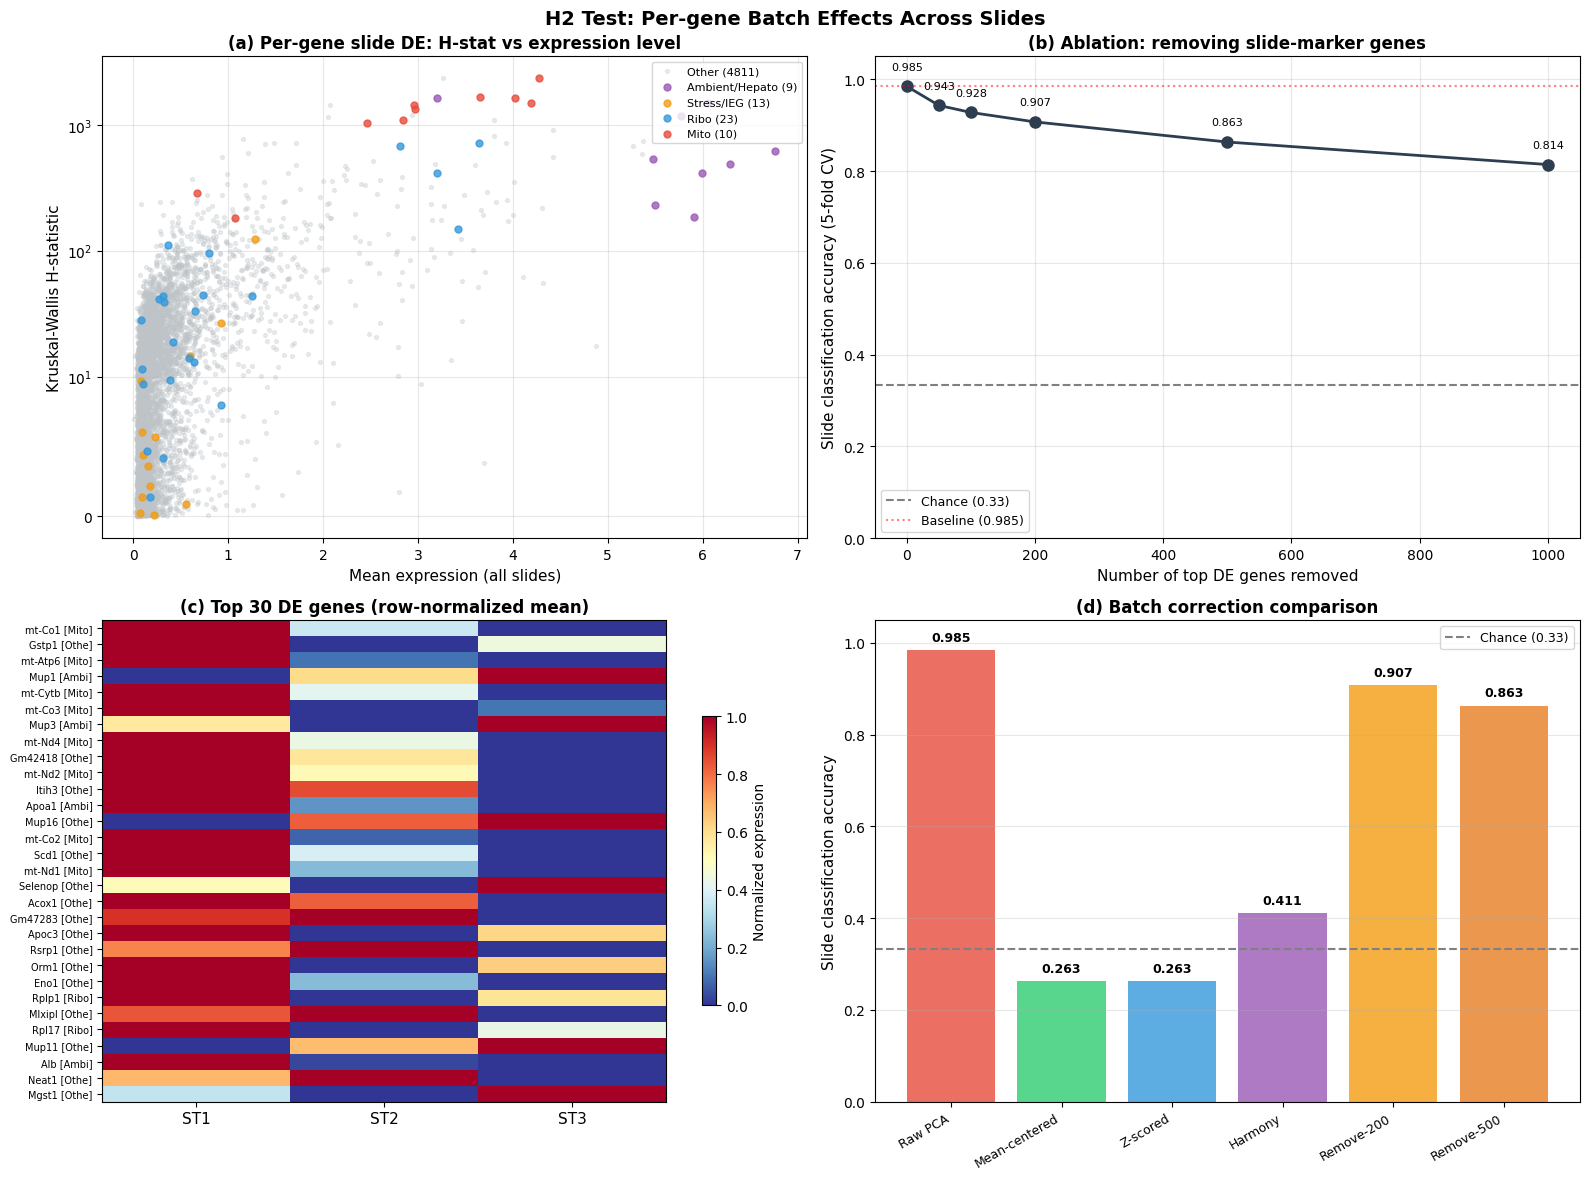


H2 SUMMARY
  DE genes (FDR<0.05):     3138/4866 (64.5%)
  Top 100 breakdown:       {'Other': np.int64(80), 'Mito': np.int64(9), 'Ambient/Hepato': np.int64(8), 'Ribo': np.int64(3)}
  Raw PCA slide acc:       0.985
  Mean-centered acc:       0.263
  Z-scored acc:            0.263
  Harmony acc:             0.411
  Remove-500 DE genes acc: 0.863
  Chance:                  0.333

INTERPRETATION:
  -> 20% of top 100 DE genes are technical
  -> Top DE genes are mostly 'Other' -- could be real biology or unknown batch

  Mean-centering drops acc by 0.721
  Z-scoring drops acc by     0.722
  -> H2 CONFIRMED: Per-gene location+scale shifts ARE the batch effect, removable


In [5]:
# ===================================================================
# HYPOTHESIS H2 TEST: Per-gene mean/variance shifts across slides
# ===================================================================
# Three sub-tests:
#   2a. Kruskal-Wallis DE across slides → classify top DE genes
#   2b. Remove top N slide-marker genes → re-test PCA slide separability
#   2c. Harmony / mean-centering batch correction → check if leakage drops
# ===================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import kruskal
from statsmodels.stats.multitest import multipletests
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.spatial import cKDTree

# Recreate from earlier cells (safe even if H1 already defined these)
st_np = st_expr.cpu().numpy()          # (N_st, G) — normalize_total + log1p
labels = slide_ids.cpu().numpy()       # (N_st,) — 0, 1, 2
n_slides = len(np.unique(labels))
slide_names_short = ['ST1', 'ST2', 'ST3']

print("=" * 70)
print("HYPOTHESIS H2: Per-gene mean/variance shifts (batch effect)")
print("=" * 70)
print(f"  Spots: {st_np.shape[0]}, Genes: {st_np.shape[1]}, Slides: {n_slides}")
print(f"  Chance level: {1/n_slides:.3f}\n")

# ── 2a. Per-gene Kruskal-Wallis test ─────────────────────────────────
print("-" * 70)
print("TEST 2a: Per-gene Kruskal-Wallis DE across slides")
print("-" * 70)

slide_masks = {s: labels == s for s in range(n_slides)}
n_genes_total = st_np.shape[1]

h_stats = np.zeros(n_genes_total)
p_vals = np.zeros(n_genes_total)

for g in range(n_genes_total):
    groups = [st_np[slide_masks[s], g] for s in range(n_slides)]
    if all(np.std(grp) < 1e-12 for grp in groups):
        h_stats[g] = 0.0
        p_vals[g] = 1.0
        continue
    h_stats[g], p_vals[g] = kruskal(*groups)

# FDR correction
_, p_fdr, _, _ = multipletests(p_vals, method='fdr_bh')
n_sig = (p_fdr < 0.05).sum()
n_strong = (p_fdr < 0.01).sum()

print(f"  Significant DE genes (FDR < 0.05): {n_sig}/{n_genes_total} ({100*n_sig/n_genes_total:.1f}%)")
print(f"  Strong DE genes (FDR < 0.01):      {n_strong}/{n_genes_total}")

# Per-slide means for fold-change
slide_means = np.array([st_np[slide_masks[s]].mean(axis=0) for s in range(n_slides)])
fold_range = slide_means.max(axis=0) / (slide_means.min(axis=0) + 1e-8)

# ── Classify genes (mouse naming conventions) ──
STRESS_IEG = {'Fos', 'Jun', 'Junb', 'Jund', 'Egr1', 'Egr2', 'Atf3', 'Atf4',
              'Dusp1', 'Dusp2', 'Btg2', 'Nr4a1', 'Nr4a2', 'Nr4a3',
              'Ier2', 'Ier3', 'Ier5', 'Hspa1a', 'Hspa1b', 'Hspa5', 'Hspa8',
              'Hsp90aa1', 'Hsp90ab1', 'Fosb', 'Fosl2', 'Zfp36', 'Nfkbia',
              'Cyr61', 'Ctgf', 'Gadd45b', 'Gadd45g', 'Ppp1r15a', 'Ddit3'}

AMBIENT_HEPATO = {'Alb', 'Apoa1', 'Apoa2', 'Ttr', 'Hp', 'Gc', 'Serpina1e',
                  'Serpina1a', 'Serpina1b', 'Serpina1c', 'Serpina1d',
                  'Fga', 'Fgb', 'Fgg', 'Tf', 'Rbp4', 'Ambp', 'Ahsg',
                  'Mup1', 'Mup2', 'Mup3', 'Mup20'}

def classify_gene(g):
    if g.startswith('mt-') or g.startswith('Mt-') or g.startswith('MT-'):
        return 'Mito'
    elif g.startswith('Rpl') or g.startswith('Rps') or g.startswith('Mrpl') or g.startswith('Mrps'):
        return 'Ribo'
    elif g in STRESS_IEG:
        return 'Stress/IEG'
    elif g in AMBIENT_HEPATO:
        return 'Ambient/Hepato'
    else:
        return 'Other'

gene_classes = np.array([classify_gene(g) for g in common_genes])

# Build results table
de_results = pd.DataFrame({
    'gene': common_genes,
    'H_stat': h_stats,
    'p_fdr': p_fdr,
    'fold_range': fold_range,
    'class': gene_classes,
    'mean_all': st_np.mean(axis=0),
    'mean_ST1': slide_means[0],
    'mean_ST2': slide_means[1],
    'mean_ST3': slide_means[2],
}).sort_values('H_stat', ascending=False).reset_index(drop=True)

# Top 30 table
print(f"\n  Top 30 DE genes across slides:")
print(f"  {'Rank':<5} {'Gene':<15} {'Class':<15} {'H-stat':>8} {'FDR':>10} {'FC-range':>9} {'ST1':>7} {'ST2':>7} {'ST3':>7}")
print("  " + "-" * 90)
for i in range(min(30, len(de_results))):
    r = de_results.iloc[i]
    print(f"  {i+1:<5} {r['gene']:<15} {r['class']:<15} {r['H_stat']:>8.1f} {r['p_fdr']:>10.2e} {r['fold_range']:>9.2f} {r['mean_ST1']:>7.3f} {r['mean_ST2']:>7.3f} {r['mean_ST3']:>7.3f}")

# Category breakdown in top 100
top100 = de_results.head(100)
cat_counts = top100['class'].value_counts()
print(f"\n  Category breakdown in top 100 DE genes:")
for cat in ['Mito', 'Ribo', 'Stress/IEG', 'Ambient/Hepato', 'Other']:
    c = cat_counts.get(cat, 0)
    print(f"    {cat:<15s}: {c:>3d}/100")

# ── 2b. Ablation: remove top N DE genes, re-test separability ────────
print("\n" + "-" * 70)
print("TEST 2b: Remove top N slide-marker genes -> re-test PCA separability")
print("-" * 70)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
de_gene_ranking = de_results['gene'].values

ablation_Ns = [0, 50, 100, 200, 500, 1000]
ablation_accs = []

for N_remove in ablation_Ns:
    if N_remove == 0:
        mask_genes = np.ones(n_genes_total, dtype=bool)
    else:
        genes_to_remove = set(de_gene_ranking[:N_remove])
        mask_genes = np.array([g not in genes_to_remove for g in common_genes])

    X_ablated = st_np[:, mask_genes]
    n_pcs = min(50, X_ablated.shape[1] - 1)

    pca_abl = PCA(n_components=n_pcs, random_state=42)
    X_pca_abl = StandardScaler().fit_transform(pca_abl.fit_transform(X_ablated))

    clf = LogisticRegression(max_iter=2000, solver='lbfgs', multi_class='multinomial')
    scores = cross_val_score(clf, X_pca_abl, labels, cv=cv, scoring='accuracy')
    ablation_accs.append(scores.mean())

    print(f"  Remove top {N_remove:>4d} DE genes -> {X_ablated.shape[1]:>5d} genes left -> "
          f"PCA({n_pcs}) slide acc: {scores.mean():.3f} +/- {scores.std():.3f}")

# Spatial sanity: Moran's I on PCs after removing 500 DE genes (ST1 only)
print(f"\n  Spatial sanity check (remove top 500 DE genes, Moran's I on ST1):")
genes_removed_500 = set(de_gene_ranking[:500])
mask_500 = np.array([g not in genes_removed_500 for g in common_genes])

X_st1_abl = st_np[labels == 0][:, mask_500]
coords_st1 = st_data['liver_ST1'].obsm['spatial']
n_st1 = X_st1_abl.shape[0]

pcs_st1 = PCA(n_components=min(10, X_st1_abl.shape[1]-1), random_state=42).fit_transform(X_st1_abl)
tree_st1 = cKDTree(coords_st1)
_, knn_idx_st1 = tree_st1.query(coords_st1, k=11)
knn_idx_st1 = knn_idx_st1[:, 1:]

morans_pcs = []
for j in range(pcs_st1.shape[1]):
    x = pcs_st1[:, j]
    xm = x - x.mean()
    denom = np.sum(xm ** 2)
    if denom < 1e-12:
        morans_pcs.append(0.0)
        continue
    num = np.einsum('i,ij->', xm, xm[knn_idx_st1])
    W = n_st1 * 10
    I = (n_st1 / W) * (num / denom)
    morans_pcs.append(I)

print(f"    Moran's I of top {len(morans_pcs)} PCs (ablated): {[f'{m:.3f}' for m in morans_pcs]}")
print(f"    Mean Moran's I: {np.mean(morans_pcs):.4f}")
if np.mean(morans_pcs) > 0.05:
    print(f"    -> Spatial structure PRESERVED after removing batch genes")
else:
    print(f"    -> Warning: spatial structure may be degraded")

# ── 2c. Batch correction -> check if slide leakage drops ─────────────
print("\n" + "-" * 70)
print("TEST 2c: Batch correction -> re-test PCA slide separability")
print("-" * 70)

# Try harmonypy first
harmony_available = False
scores_harmony = None
try:
    import harmonypy as hm

    pca_raw = PCA(n_components=50, random_state=42)
    X_pca_raw = pca_raw.fit_transform(st_np)

    meta = pd.DataFrame({'slide': labels.astype(str)})
    ho = hm.run_harmony(X_pca_raw, meta, 'slide', max_iter_harmony=20)
    X_harmony = ho.Z_corr
    if X_harmony.shape[0] != st_np.shape[0]:
        X_harmony = X_harmony.T  # only transpose if harmonypy returns (pcs, cells)


    X_harmony_scaled = StandardScaler().fit_transform(X_harmony)
    clf_h = LogisticRegression(max_iter=2000, solver='lbfgs', multi_class='multinomial')
    scores_harmony = cross_val_score(clf_h, X_harmony_scaled, labels, cv=cv, scoring='accuracy')
    harmony_available = True
    print(f"  Harmony PCA(50) slide acc:    {scores_harmony.mean():.3f} +/- {scores_harmony.std():.3f}")

except ImportError:
    print("  [harmonypy not installed -- run: pip install harmonypy]")

# Per-slide-per-gene mean centering (location-only ComBat equivalent)
st_centered = st_np.copy()
global_mean = st_np.mean(axis=0)
for s in range(n_slides):
    m = labels == s
    st_centered[m] = st_np[m] - st_np[m].mean(axis=0) + global_mean

X_pca_cent = StandardScaler().fit_transform(
    PCA(n_components=50, random_state=42).fit_transform(st_centered))
clf_c = LogisticRegression(max_iter=2000, solver='lbfgs', multi_class='multinomial')
scores_centered = cross_val_score(clf_c, X_pca_cent, labels, cv=cv, scoring='accuracy')
print(f"  Mean-centered PCA(50) slide acc: {scores_centered.mean():.3f} +/- {scores_centered.std():.3f}")

# Per-slide-per-gene z-score (location + scale correction)
st_zscore = st_np.copy()
global_std = st_np.std(axis=0) + 1e-8
for s in range(n_slides):
    m = labels == s
    slide_mean = st_np[m].mean(axis=0)
    slide_std = st_np[m].std(axis=0) + 1e-8
    st_zscore[m] = (st_np[m] - slide_mean) / slide_std * global_std + global_mean

X_pca_zs = StandardScaler().fit_transform(
    PCA(n_components=50, random_state=42).fit_transform(st_zscore))
clf_zs = LogisticRegression(max_iter=2000, solver='lbfgs', multi_class='multinomial')
scores_zscore = cross_val_score(clf_zs, X_pca_zs, labels, cv=cv, scoring='accuracy')
print(f"  Z-scored PCA(50) slide acc:      {scores_zscore.mean():.3f} +/- {scores_zscore.std():.3f}")

# Raw baseline
X_pca_base = StandardScaler().fit_transform(
    PCA(n_components=50, random_state=42).fit_transform(st_np))
clf_base = LogisticRegression(max_iter=2000, solver='lbfgs', multi_class='multinomial')
scores_raw = cross_val_score(clf_base, X_pca_base, labels, cv=cv, scoring='accuracy')
print(f"\n  Baseline Raw PCA(50) slide acc:  {scores_raw.mean():.3f} +/- {scores_raw.std():.3f}")
print(f"  Chance:                           {1/n_slides:.3f}")

# ===================================================================
# VISUALIZATION (2x2)
# ===================================================================
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# (a) H-stat vs mean expression, colored by gene category
ax = axes[0, 0]
cat_colors = {'Mito': '#e74c3c', 'Ribo': '#3498db', 'Stress/IEG': '#f39c12',
              'Ambient/Hepato': '#9b59b6', 'Other': '#bdc3c7'}
for cat in ['Other', 'Ambient/Hepato', 'Stress/IEG', 'Ribo', 'Mito']:
    mask_cat = de_results['class'] == cat
    ax.scatter(de_results.loc[mask_cat, 'mean_all'],
               de_results.loc[mask_cat, 'H_stat'],
               c=cat_colors[cat], label=f"{cat} ({mask_cat.sum()})",
               s=8 if cat == 'Other' else 25,
               alpha=0.3 if cat == 'Other' else 0.8,
               zorder=1 if cat == 'Other' else 3)
ax.set_xlabel('Mean expression (all slides)', fontsize=11)
ax.set_ylabel('Kruskal-Wallis H-statistic', fontsize=11)
ax.set_title('(a) Per-gene slide DE: H-stat vs expression level', fontweight='bold')
ax.legend(fontsize=8, loc='upper right')
ax.set_yscale('symlog', linthresh=10)
ax.grid(True, alpha=0.3)

# (b) Ablation curve
ax = axes[0, 1]
ax.plot(ablation_Ns, ablation_accs, 'o-', color='#2c3e50', linewidth=2, markersize=8)
ax.axhline(y=1/n_slides, color='gray', linestyle='--', label=f'Chance ({1/n_slides:.2f})')
ax.axhline(y=ablation_accs[0], color='red', linestyle=':', alpha=0.5,
           label=f'Baseline ({ablation_accs[0]:.3f})')
ax.set_xlabel('Number of top DE genes removed', fontsize=11)
ax.set_ylabel('Slide classification accuracy (5-fold CV)', fontsize=11)
ax.set_title('(b) Ablation: removing slide-marker genes', fontweight='bold')
ax.legend(fontsize=9)
ax.set_ylim(0, 1.05)
ax.grid(True, alpha=0.3)
for n_rem, acc in zip(ablation_Ns, ablation_accs):
    ax.annotate(f'{acc:.3f}', (n_rem, acc), textcoords="offset points",
                xytext=(0, 12), ha='center', fontsize=8)

# (c) Heatmap of top 30 DE genes
ax = axes[1, 0]
top30 = de_results.head(30)
heatmap_data = top30[['mean_ST1', 'mean_ST2', 'mean_ST3']].values
row_max = heatmap_data.max(axis=1, keepdims=True)
row_min = heatmap_data.min(axis=1, keepdims=True)
heatmap_norm = (heatmap_data - row_min) / (row_max - row_min + 1e-8)

im = ax.imshow(heatmap_norm, aspect='auto', cmap='RdYlBu_r', interpolation='nearest')
ax.set_yticks(range(30))
gene_labels_h = [f"{r['gene']} [{r['class'][:4]}]" for _, r in top30.iterrows()]
ax.set_yticklabels(gene_labels_h, fontsize=7)
ax.set_xticks([0, 1, 2])
ax.set_xticklabels(slide_names_short, fontsize=11)
ax.set_title('(c) Top 30 DE genes (row-normalized mean)', fontweight='bold')
plt.colorbar(im, ax=ax, shrink=0.6, label='Normalized expression')

# (d) Batch correction comparison
ax = axes[1, 1]
method_names = ['Raw PCA', 'Mean-centered', 'Z-scored']
method_accs = [scores_raw.mean(), scores_centered.mean(), scores_zscore.mean()]
bar_colors = ['#e74c3c', '#2ecc71', '#3498db']

if harmony_available:
    method_names.append('Harmony')
    method_accs.append(scores_harmony.mean())
    bar_colors.append('#9b59b6')

method_names.extend([f'Remove-{n}' for n in [200, 500]])
method_accs.extend([ablation_accs[ablation_Ns.index(200)],
                    ablation_accs[ablation_Ns.index(500)]])
bar_colors.extend(['#f39c12', '#e67e22'])

bars = ax.bar(range(len(method_names)), method_accs, color=bar_colors, alpha=0.8)
ax.axhline(y=1/n_slides, color='gray', linestyle='--', label=f'Chance ({1/n_slides:.2f})')
ax.set_xticks(range(len(method_names)))
ax.set_xticklabels(method_names, rotation=30, ha='right', fontsize=9)
ax.set_ylabel('Slide classification accuracy', fontsize=11)
ax.set_title('(d) Batch correction comparison', fontweight='bold')
ax.set_ylim(0, 1.05)
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3, axis='y')
for bar, acc in zip(bars, method_accs):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
            f'{acc:.3f}', ha='center', fontsize=9, fontweight='bold')

plt.suptitle('H2 Test: Per-gene Batch Effects Across Slides', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# ===================================================================
# SUMMARY
# ===================================================================
print("\n" + "=" * 70)
print("H2 SUMMARY")
print("=" * 70)
print(f"  DE genes (FDR<0.05):     {n_sig}/{n_genes_total} ({100*n_sig/n_genes_total:.1f}%)")
print(f"  Top 100 breakdown:       {dict(cat_counts)}")
print(f"  Raw PCA slide acc:       {scores_raw.mean():.3f}")
print(f"  Mean-centered acc:       {scores_centered.mean():.3f}")
print(f"  Z-scored acc:            {scores_zscore.mean():.3f}")
if harmony_available:
    print(f"  Harmony acc:             {scores_harmony.mean():.3f}")
print(f"  Remove-500 DE genes acc: {ablation_accs[ablation_Ns.index(500)]:.3f}")
print(f"  Chance:                  {1/n_slides:.3f}")

print("\nINTERPRETATION:")
pct_technical = 100 - cat_counts.get('Other', 0)
if pct_technical > 50:
    print(f"  -> {pct_technical}% of top 100 DE genes are technical (mito/ribo/stress/ambient)")
    print(f"  -> H2 CONFIRMED: Slide separation is driven by TECHNICAL batch genes")
else:
    print(f"  -> {pct_technical}% of top 100 DE genes are technical")
    print(f"  -> Top DE genes are mostly 'Other' -- could be real biology or unknown batch")

drop_mc = scores_raw.mean() - scores_centered.mean()
drop_zs = scores_raw.mean() - scores_zscore.mean()
print(f"\n  Mean-centering drops acc by {drop_mc:.3f}")
print(f"  Z-scoring drops acc by     {drop_zs:.3f}")

if drop_zs > 0.3:
    print(f"  -> H2 CONFIRMED: Per-gene location+scale shifts ARE the batch effect, removable")
elif drop_zs > 0.1:
    print(f"  -> H2 PARTIALLY CONFIRMED: Gene shifts explain some but not all slide signal")
else:
    print(f"  -> H2 WEAK: Gene-level mean/var shifts don't account for most slide separability")
    print(f"     (higher-order patterns like gene-gene correlations may drive it instead)")
print("=" * 70)


# hypothesis 3 testing and verifictaion

HYPOTHESIS H3: Slide separability from composition differences
  Spots: 3972, Genes: 4866, Slides: 3
  Chance level: 0.333

----------------------------------------------------------------------
TEST 3a: Within-cluster slide classification
----------------------------------------------------------------------

  Global baseline (all spots): 0.985 +/- 0.004
  Global mean-centered:        0.263 +/- 0.013

  --- K=10 clusters (KMeans on raw PCA) ---
    Valid clusters (>=2 slides, >=5/slide): 6/10
    Within-cluster slide acc (raw PCA):
      Mean: 0.841, Median: 0.937, Weighted-mean: 0.942
    Within-cluster slide acc (mean-centered PCA):
      Mean: 0.456, Median: 0.457, Weighted-mean: 0.495
    Chance: 0.333

  --- K=20 clusters (KMeans on raw PCA) ---
    Valid clusters (>=2 slides, >=5/slide): 13/20
    Within-cluster slide acc (raw PCA):
      Mean: 0.915, Median: 0.924, Weighted-mean: 0.939
    Within-cluster slide acc (mean-centered PCA):
      Mean: 0.479, Median: 0.453, Weighted

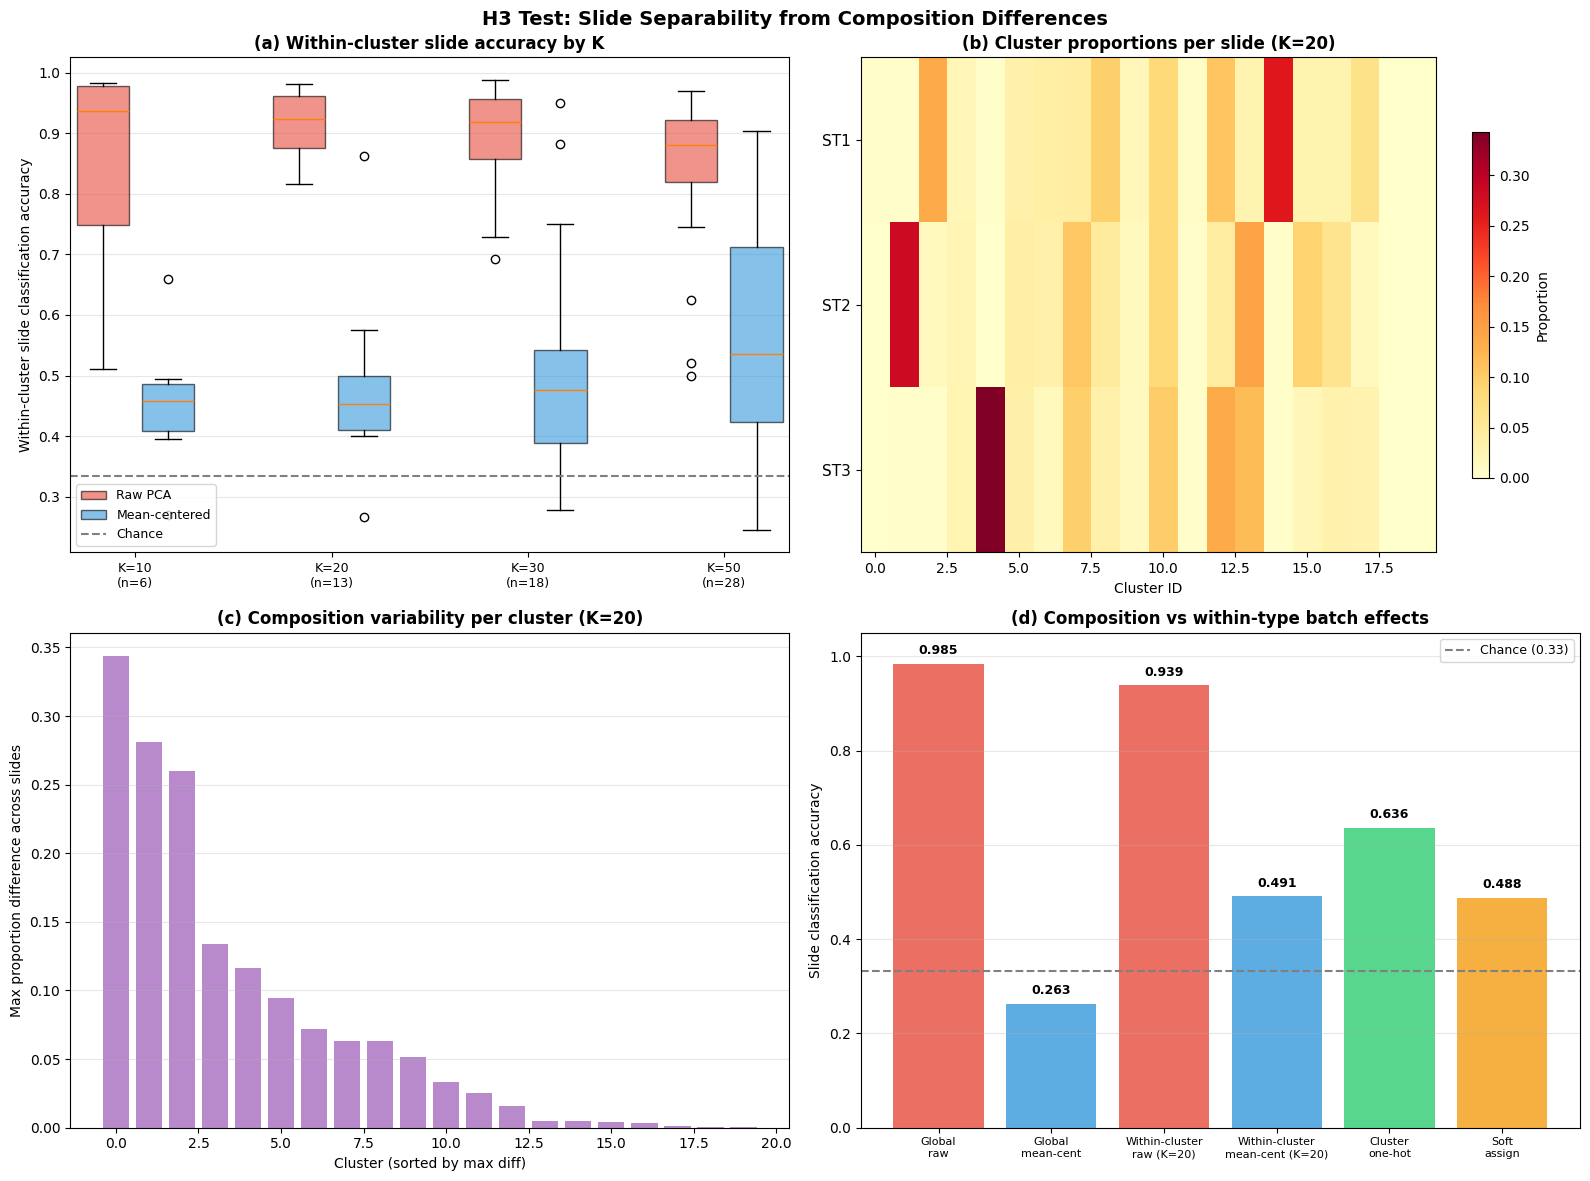


H3 SUMMARY
  Global slide acc (raw PCA):           0.985
  Global slide acc (mean-centered):     0.263
  Within-cluster acc (raw, K=20):       0.939 (weighted mean)
  Within-cluster acc (centered, K=20):  0.491 (weighted mean)
  Cluster one-hot slide acc:            0.636
  Soft assignment slide acc:            0.488
  Cramer's V (cluster x slide):         0.617
  Chance:                               0.333

INTERPRETATION:
  -> Within-cluster slide acc is HIGH (0.939)
     Slide identity is detectable WITHIN same pseudo-type
     -> NOT just composition: within-type batch shifts dominate
  -> Cluster assignment alone predicts slide (0.636)
     -> Composition IS a significant contributor

  BOTH composition AND within-type batch contribute to slide separability

  Mean-centering drops within-cluster acc by 0.448
  (consistent with H2: per-gene mean shift is the main batch mechanism)


In [6]:
# ===================================================================
# HYPOTHESIS H3 TEST: Slide separability from composition differences
# ===================================================================
# Two sub-tests:
#   3a. Cluster spots into pseudo-types, train slide classifier WITHIN
#       each cluster. If accuracy stays high within clusters → not just
#       composition, it's within-type batch shift.
#   3b. Compare cluster proportions per slide. If proportions differ
#       a lot → composition is a major driver of slide separability.
# ===================================================================

import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from collections import Counter

# Recreate from earlier cells
st_np = st_expr.cpu().numpy()
labels = slide_ids.cpu().numpy()
n_slides = len(np.unique(labels))
slide_names_short = ['ST1', 'ST2', 'ST3']

print("=" * 70)
print("HYPOTHESIS H3: Slide separability from composition differences")
print("=" * 70)
print(f"  Spots: {st_np.shape[0]}, Genes: {st_np.shape[1]}, Slides: {n_slides}")
print(f"  Chance level: {1/n_slides:.3f}\n")

# ── Shared PCA for clustering and classification ──
pca_full = PCA(n_components=50, random_state=42)
X_pca = pca_full.fit_transform(st_np)
X_pca_scaled = StandardScaler().fit_transform(X_pca)

# ── Also prepare MEAN-CENTERED version (from H2 finding) ──
global_mean = st_np.mean(axis=0)
st_centered = st_np.copy()
for s in range(n_slides):
    m = labels == s
    st_centered[m] = st_np[m] - st_np[m].mean(axis=0) + global_mean

X_pca_cent = PCA(n_components=50, random_state=42).fit_transform(st_centered)
X_pca_cent_scaled = StandardScaler().fit_transform(X_pca_cent)

# ── 3a. Within-cluster slide classification ──────────────────────────
print("-" * 70)
print("TEST 3a: Within-cluster slide classification")
print("-" * 70)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
K_VALUES = [10, 20, 30, 50]

# Global baseline (all spots)
clf_global = LogisticRegression(max_iter=2000, solver='lbfgs', multi_class='multinomial')
scores_global = cross_val_score(clf_global, X_pca_scaled, labels, cv=cv, scoring='accuracy')
print(f"\n  Global baseline (all spots): {scores_global.mean():.3f} +/- {scores_global.std():.3f}")

clf_global_cent = LogisticRegression(max_iter=2000, solver='lbfgs', multi_class='multinomial')
scores_global_cent = cross_val_score(clf_global_cent, X_pca_cent_scaled, labels, cv=cv, scoring='accuracy')
print(f"  Global mean-centered:        {scores_global_cent.mean():.3f} +/- {scores_global_cent.std():.3f}")

results_by_K = {}

for K in K_VALUES:
    print(f"\n  --- K={K} clusters (KMeans on raw PCA) ---")

    km = KMeans(n_clusters=K, random_state=42, n_init=10)
    cluster_labels = km.fit_predict(X_pca_scaled)

    within_accs_raw = []
    within_accs_cent = []
    cluster_sizes = []
    cluster_slide_counts = []

    for c in range(K):
        mask_c = cluster_labels == c
        n_c = mask_c.sum()
        labels_c = labels[mask_c]

        # Need at least 2 slides present and enough spots per slide for CV
        slides_present = np.unique(labels_c)
        min_per_slide = min(Counter(labels_c).values())

        if len(slides_present) < 2 or min_per_slide < 5:
            continue

        cluster_sizes.append(n_c)
        cluster_slide_counts.append(len(slides_present))

        # Raw PCA within cluster
        X_c = X_pca_scaled[mask_c]
        try:
            n_folds = min(5, min_per_slide)
            cv_c = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)
            clf_c = LogisticRegression(max_iter=2000, solver='lbfgs',
                                       multi_class='multinomial' if len(slides_present) > 2 else 'auto')
            sc = cross_val_score(clf_c, X_c, labels_c, cv=cv_c, scoring='accuracy')
            within_accs_raw.append(sc.mean())
        except Exception:
            pass

        # Mean-centered PCA within cluster
        X_c_cent = X_pca_cent_scaled[mask_c]
        try:
            clf_c2 = LogisticRegression(max_iter=2000, solver='lbfgs',
                                        multi_class='multinomial' if len(slides_present) > 2 else 'auto')
            sc2 = cross_val_score(clf_c2, X_c_cent, labels_c, cv=cv_c, scoring='accuracy')
            within_accs_cent.append(sc2.mean())
        except Exception:
            pass

    n_valid = len(within_accs_raw)
    mean_raw = np.mean(within_accs_raw) if within_accs_raw else float('nan')
    mean_cent = np.mean(within_accs_cent) if within_accs_cent else float('nan')
    median_raw = np.median(within_accs_raw) if within_accs_raw else float('nan')
    median_cent = np.median(within_accs_cent) if within_accs_cent else float('nan')

    # Size-weighted mean
    if within_accs_raw and cluster_sizes:
        weights = np.array(cluster_sizes[:len(within_accs_raw)], dtype=float)
        weights /= weights.sum()
        wmean_raw = np.average(within_accs_raw, weights=weights)
    else:
        wmean_raw = float('nan')

    if within_accs_cent and cluster_sizes:
        weights_c = np.array(cluster_sizes[:len(within_accs_cent)], dtype=float)
        weights_c /= weights_c.sum()
        wmean_cent = np.average(within_accs_cent, weights=weights_c)
    else:
        wmean_cent = float('nan')

    results_by_K[K] = {
        'n_valid': n_valid,
        'raw_accs': within_accs_raw,
        'cent_accs': within_accs_cent,
        'mean_raw': mean_raw,
        'mean_cent': mean_cent,
        'wmean_raw': wmean_raw,
        'wmean_cent': wmean_cent,
        'sizes': cluster_sizes,
    }

    print(f"    Valid clusters (>=2 slides, >=5/slide): {n_valid}/{K}")
    print(f"    Within-cluster slide acc (raw PCA):")
    print(f"      Mean: {mean_raw:.3f}, Median: {median_raw:.3f}, Weighted-mean: {wmean_raw:.3f}")
    print(f"    Within-cluster slide acc (mean-centered PCA):")
    print(f"      Mean: {mean_cent:.3f}, Median: {median_cent:.3f}, Weighted-mean: {wmean_cent:.3f}")
    print(f"    Chance: {1/n_slides:.3f}")

# ── 3b. Cluster proportion analysis ──────────────────────────────────
print("\n" + "-" * 70)
print("TEST 3b: Cluster proportions per slide")
print("-" * 70)

K_PROP = 20  # use K=20 for proportion analysis
km_prop = KMeans(n_clusters=K_PROP, random_state=42, n_init=10)
cl_prop = km_prop.fit_predict(X_pca_scaled)

# Build proportion matrix (slides x clusters)
prop_matrix = np.zeros((n_slides, K_PROP))
for s in range(n_slides):
    counts = Counter(cl_prop[labels == s])
    total = (labels == s).sum()
    for c in range(K_PROP):
        prop_matrix[s, c] = counts.get(c, 0) / total

print(f"\n  Cluster proportions (K={K_PROP}):")
print(f"  {'Cluster':<10s}", end='')
for sn in slide_names_short:
    print(f"  {sn:>8s}", end='')
print(f"  {'Max diff':>10s}")
print("  " + "-" * 50)
for c in range(K_PROP):
    print(f"  {'C'+str(c):<10s}", end='')
    for s in range(n_slides):
        print(f"  {prop_matrix[s, c]:>8.3f}", end='')
    diff = prop_matrix[:, c].max() - prop_matrix[:, c].min()
    print(f"  {diff:>10.3f}")

# Total variation distance between slides
print(f"\n  Total Variation Distance (TVD) between slides:")
for i in range(n_slides):
    for j in range(i + 1, n_slides):
        tvd = 0.5 * np.abs(prop_matrix[i] - prop_matrix[j]).sum()
        print(f"    {slide_names_short[i]} vs {slide_names_short[j]}: TVD = {tvd:.3f}")

# Chi-squared test for independence of cluster x slide
from scipy.stats import chi2_contingency
contingency = np.zeros((n_slides, K_PROP), dtype=int)
for s in range(n_slides):
    counts = Counter(cl_prop[labels == s])
    for c in range(K_PROP):
        contingency[s, c] = counts.get(c, 0)

chi2, p_chi2, dof, _ = chi2_contingency(contingency)
cramers_v = np.sqrt(chi2 / (st_np.shape[0] * (min(n_slides, K_PROP) - 1)))
print(f"\n  Chi-squared test (cluster x slide independence):")
print(f"    Chi2 = {chi2:.1f}, p = {p_chi2:.2e}, dof = {dof}")
print(f"    Cramer's V = {cramers_v:.3f} (0=independent, 1=perfectly associated)")

# ── 3c. Composition-only slide classifier ─────────────────────────────
print("\n" + "-" * 70)
print("TEST 3c: Can cluster proportions alone predict slide identity?")
print("-" * 70)

# Per-spot: one-hot cluster assignment as features
cl_onehot = np.zeros((st_np.shape[0], K_PROP))
for i in range(st_np.shape[0]):
    cl_onehot[i, cl_prop[i]] = 1.0

clf_comp = LogisticRegression(max_iter=2000, solver='lbfgs', multi_class='multinomial')
scores_comp = cross_val_score(clf_comp, cl_onehot, labels, cv=cv, scoring='accuracy')
print(f"  Cluster one-hot (K={K_PROP}) slide acc: {scores_comp.mean():.3f} +/- {scores_comp.std():.3f}")

# Soft assignment (distance to each centroid)
centroids = km_prop.cluster_centers_
dists_to_centroids = np.zeros((st_np.shape[0], K_PROP))
for i in range(st_np.shape[0]):
    dists_to_centroids[i] = np.linalg.norm(X_pca_scaled[i] - centroids, axis=1)
soft_assign = 1.0 / (dists_to_centroids + 1e-8)
soft_assign = soft_assign / soft_assign.sum(axis=1, keepdims=True)

clf_soft = LogisticRegression(max_iter=2000, solver='lbfgs', multi_class='multinomial')
scores_soft = cross_val_score(clf_soft, soft_assign, labels, cv=cv, scoring='accuracy')
print(f"  Soft assignment (K={K_PROP}) slide acc:  {scores_soft.mean():.3f} +/- {scores_soft.std():.3f}")
print(f"  Chance: {1/n_slides:.3f}")

# ===================================================================
# VISUALIZATION (2x2)
# ===================================================================
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# (a) Within-cluster accuracy distribution for each K
ax = axes[0, 0]
positions = []
data_raw = []
data_cent = []
tick_labels = []
for i, K in enumerate(K_VALUES):
    r = results_by_K[K]
    if r['raw_accs']:
        data_raw.append(r['raw_accs'])
        data_cent.append(r['cent_accs'])
        tick_labels.append(f'K={K}\n(n={r["n_valid"]})')

bp1 = ax.boxplot(data_raw, positions=np.arange(len(data_raw)) * 3,
                 widths=0.8, patch_artist=True,
                 boxprops=dict(facecolor='#e74c3c', alpha=0.6))
bp2 = ax.boxplot(data_cent, positions=np.arange(len(data_cent)) * 3 + 1,
                 widths=0.8, patch_artist=True,
                 boxprops=dict(facecolor='#3498db', alpha=0.6))
ax.axhline(y=1/n_slides, color='gray', linestyle='--', label=f'Chance ({1/n_slides:.2f})')
ax.set_xticks(np.arange(len(tick_labels)) * 3 + 0.5)
ax.set_xticklabels(tick_labels, fontsize=9)
ax.set_ylabel('Within-cluster slide classification accuracy')
ax.set_title('(a) Within-cluster slide accuracy by K', fontweight='bold')
ax.legend([bp1['boxes'][0], bp2['boxes'][0], ax.lines[-1]],
          ['Raw PCA', 'Mean-centered', 'Chance'], fontsize=9)
ax.grid(True, alpha=0.3, axis='y')

# (b) Cluster proportions heatmap
ax = axes[0, 1]
im = ax.imshow(prop_matrix, aspect='auto', cmap='YlOrRd', interpolation='nearest')
ax.set_yticks(range(n_slides))
ax.set_yticklabels(slide_names_short, fontsize=11)
ax.set_xlabel('Cluster ID')
ax.set_title(f'(b) Cluster proportions per slide (K={K_PROP})', fontweight='bold')
plt.colorbar(im, ax=ax, shrink=0.7, label='Proportion')

# (c) Per-cluster max proportion difference across slides
ax = axes[1, 0]
max_diffs = prop_matrix.max(axis=0) - prop_matrix.min(axis=0)
sorted_idx = np.argsort(max_diffs)[::-1]
ax.bar(range(K_PROP), max_diffs[sorted_idx], color='#9b59b6', alpha=0.7)
ax.set_xlabel('Cluster (sorted by max diff)')
ax.set_ylabel('Max proportion difference across slides')
ax.set_title(f'(c) Composition variability per cluster (K={K_PROP})', fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

# (d) Summary comparison bar chart
ax = axes[1, 1]
# Pick K=20 for the summary
r20 = results_by_K.get(20, results_by_K.get(K_VALUES[0]))
bar_labels = ['Global\nraw', 'Global\nmean-cent', 'Within-cluster\nraw (K=20)',
              'Within-cluster\nmean-cent (K=20)', 'Cluster\none-hot', 'Soft\nassign']
bar_vals = [scores_global.mean(), scores_global_cent.mean(),
            r20['wmean_raw'], r20['wmean_cent'],
            scores_comp.mean(), scores_soft.mean()]
bar_colors = ['#e74c3c', '#3498db', '#e74c3c', '#3498db', '#2ecc71', '#f39c12']
bars = ax.bar(range(len(bar_labels)), bar_vals, color=bar_colors, alpha=0.8)
ax.axhline(y=1/n_slides, color='gray', linestyle='--', label=f'Chance ({1/n_slides:.2f})')
ax.set_xticks(range(len(bar_labels)))
ax.set_xticklabels(bar_labels, fontsize=8)
ax.set_ylabel('Slide classification accuracy')
ax.set_title('(d) Composition vs within-type batch effects', fontweight='bold')
ax.set_ylim(0, 1.05)
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3, axis='y')
for bar, val in zip(bars, bar_vals):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
            f'{val:.3f}', ha='center', fontsize=9, fontweight='bold')

plt.suptitle('H3 Test: Slide Separability from Composition Differences',
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# ===================================================================
# SUMMARY
# ===================================================================
print("\n" + "=" * 70)
print("H3 SUMMARY")
print("=" * 70)
print(f"  Global slide acc (raw PCA):           {scores_global.mean():.3f}")
print(f"  Global slide acc (mean-centered):     {scores_global_cent.mean():.3f}")
r20 = results_by_K.get(20, results_by_K.get(K_VALUES[0]))
print(f"  Within-cluster acc (raw, K=20):       {r20['wmean_raw']:.3f} (weighted mean)")
print(f"  Within-cluster acc (centered, K=20):  {r20['wmean_cent']:.3f} (weighted mean)")
print(f"  Cluster one-hot slide acc:            {scores_comp.mean():.3f}")
print(f"  Soft assignment slide acc:            {scores_soft.mean():.3f}")
print(f"  Cramer's V (cluster x slide):         {cramers_v:.3f}")
print(f"  Chance:                               {1/n_slides:.3f}")

print("\nINTERPRETATION:")
if r20['wmean_raw'] > 0.6:
    print(f"  -> Within-cluster slide acc is HIGH ({r20['wmean_raw']:.3f})")
    print(f"     Slide identity is detectable WITHIN same pseudo-type")
    print(f"     -> NOT just composition: within-type batch shifts dominate")
else:
    print(f"  -> Within-cluster slide acc is LOW ({r20['wmean_raw']:.3f})")
    print(f"     -> Composition differences ARE the main driver")

if scores_comp.mean() > 0.5:
    print(f"  -> Cluster assignment alone predicts slide ({scores_comp.mean():.3f})")
    print(f"     -> Composition IS a significant contributor")
else:
    print(f"  -> Cluster assignment barely predicts slide ({scores_comp.mean():.3f})")
    print(f"     -> Composition is NOT a major factor")

if r20['wmean_raw'] > 0.6 and scores_comp.mean() > 0.5:
    print(f"\n  BOTH composition AND within-type batch contribute to slide separability")
elif r20['wmean_raw'] > 0.6:
    print(f"\n  H3 FALSIFIED: Within-type batch shift is the dominant factor, not composition")
else:
    print(f"\n  H3 CONFIRMED: Composition differences are the main driver")

drop = r20['wmean_raw'] - r20['wmean_cent']
print(f"\n  Mean-centering drops within-cluster acc by {drop:.3f}")
print(f"  (consistent with H2: per-gene mean shift is the main batch mechanism)")
print("=" * 70)


# train encoder without spatial nce for Hypothesis 4

In [7]:
# ===================================================================
# HYPOTHESIS H4 — STEP 1: Train VICReg-only encoder (no Spatial NCE)
# ===================================================================
# Compare to v3 (VICReg + spatial_nce=5.0) to isolate NCE's contribution
# to slide-specific structure.
# ===================================================================

print("=" * 70)
print("H4: Training VICReg-only encoder (spatial_nce_weight = 0)")
print("    Comparison baseline: v3 encoder (spatial_nce_weight = 5.0)")
print("=" * 70)

set_seed(SEED)
encoder_h4 = SharedEncoder(n_genes=n_genes, n_embedding=[512, 256, 128], dropout=0.1)

outdir_h4 = '/home/ehtesamul/sc_st/model/gems_liver_crossslide_h4_vicreg_only'
os.makedirs(outdir_h4, exist_ok=True)

encoder_h4, projector_h4, discriminator_h4, hist_h4 = train_encoder(
    inference_dropout_prob=0.0,
    model=encoder_h4,
    st_gene_expr=st_expr,
    st_coords=st_coords,
    sc_gene_expr=inf_expr,
    slide_ids=slide_ids,
    sc_slide_ids=inf_slide_ids,
    sc_patient_ids=inf_patient_ids,
    n_epochs=1200,
    batch_size=256,
    lr=1e-4,
    device=device,
    outf=outdir_h4,
    st_source_ids=st_source_ids,
    sc_source_ids=inf_source_ids,
    use_source_adversary=False,
    source_coral_weight=0.0,
    stageA_obj='vicreg_adv',
    # ---- VICReg: identical to v3 ----
    vicreg_lambda_inv=25.0,
    vicreg_lambda_var=50.0,
    vicreg_lambda_cov=1.0,
    vicreg_inv_warmup_frac=0.3,
    vicreg_inv_start=5.0,
    vicreg_gamma=1.0,
    vicreg_eps=1e-4,
    vicreg_project_dim=256,
    vicreg_use_projector=False,
    vicreg_float32_stats=True,
    vicreg_ddp_gather=False,
    aug_gene_dropout=0.25,
    aug_gauss_std=0.01,
    aug_scale_jitter=0.1,
    # ---- ALL alignment OFF (same as v3) ----
    adv_slide_weight=0.0,
    patient_coral_weight=0.0,
    mmd_weight=0.0,
    mmd_use_l2norm=True,
    mmd_ramp=True,
    adv_warmup_epochs=50,
    adv_ramp_epochs=200,
    grl_alpha_max=1.0,
    disc_hidden=512,
    disc_dropout=0.1,
    stageA_balanced_slides=True,
    adv_representation_mode='clean',
    adv_use_layernorm=False,
    adv_log_diagnostics=False,
    adv_log_grad_norms=False,
    use_local_align=False,
    return_aux=True,
    local_align_bidirectional=True,
    local_align_weight=0.0,
    local_align_tau_z=0.07,
    seed=SEED,
    use_best_checkpoint=True,
    coral_raw_weight=0.0,
    knn_weight=0.0,
    # ==== THE KEY CHANGE: Spatial NCE OFF ====
    spatial_nce_weight=0.0,           # WAS 5.0 in v3
    spatial_nce_k_phys=20,
    spatial_nce_far_mult=4.0,
    spatial_nce_n_hard=20,
    spatial_nce_tau=0.1,
    spatial_nce_n_rand_neg=128,
    spatial_nce_n_anchors=64,
    # ---- NO Phase 2 (same as v3) ----
    two_phase_training=False,
    # ---- Slide-scale regularizer (same as v3) ----
    slide_scale_weight=5.0,
    per_slide_norm=True,
    per_slide_norm_target=1.0,
)

print("\n" + "=" * 70)
print("H4 VICReg-only TRAINING COMPLETE")
print("=" * 70)
torch.save(encoder_h4.state_dict(), f'{outdir_h4}/encoder_h4_vicreg_only.pt')
print(f"Saved: {outdir_h4}/encoder_h4_vicreg_only.pt")


H4: Training VICReg-only encoder (spatial_nce_weight = 0)
    Comparison baseline: v3 encoder (spatial_nce_weight = 5.0)
[set_seed] Random seed set to 42 (deterministic=True)
[Stage A] Random seed set to 42 for reproducibility
  NOTE: For full reproducibility, also call ssl_utils.set_seed(42)
        BEFORE creating the encoder to seed weight initialization.
[Stage A] Using pre-normalized coordinates
Auto-computed sigma (per-slide median) = 0.1000
  Per-slide sigmas: [0.12515772879123688, 0.1246667206287384, 0.12499141693115234]

STAGE A MODE: VICReg + Domain Adversary (ST vs SC)

[VICReg] ST slide_ids already contiguous: 0..2
[VICReg] Balancing ST: 3972 → 1011 (to match SC)
[VICReg] Domain setup: ST(n=1011) vs SC(n=1011) => 2 domains
[VICReg] ST slide balancing: 3 slides
[VICReg] SC slide balancing: 1 slides (hierarchical sampling enabled)
[VICReg] Patient CORAL: disabled (only 1 patient in SC)
  No projector (VICReg on backbone)
  Discriminator: 128 → 2 (ST vs SC)
  VICReg: λ_inv=25.

# hypothesis 4 test

HYPOTHESIS H4: Spatial InfoNCE induces slide-unique anisotropy?
  Spots: 3972, Embedding dim: 128
  Encoder A (v3, VICReg+NCE):  Z shape = (3972, 128)
  Encoder B (H4, VICReg only): Z shape = (3972, 128)

----------------------------------------------------------------------
TEST 4a: Slide separability — VICReg+NCE vs VICReg-only
----------------------------------------------------------------------
  Raw PCA(50) slide acc:       0.985 +/- 0.004
  VICReg+NCE (v3) slide acc:   0.828 +/- 0.011
  VICReg-only (H4) slide acc:  0.773 +/- 0.013
  Chance:                      0.333

  NCE - VICReg-only = +0.056

----------------------------------------------------------------------
TEST 4b: Per-slide embedding norms
----------------------------------------------------------------------

  VICReg+NCE (v3):
    ST1: RMS=9.483, mean L2=9.433
    ST2: RMS=9.699, mean L2=9.643
    ST3: RMS=11.271, mean L2=11.241
    Max/Min RMS ratio: 1.189

  VICReg-only (H4):
    ST1: RMS=10.304, mean L2=10.240
 

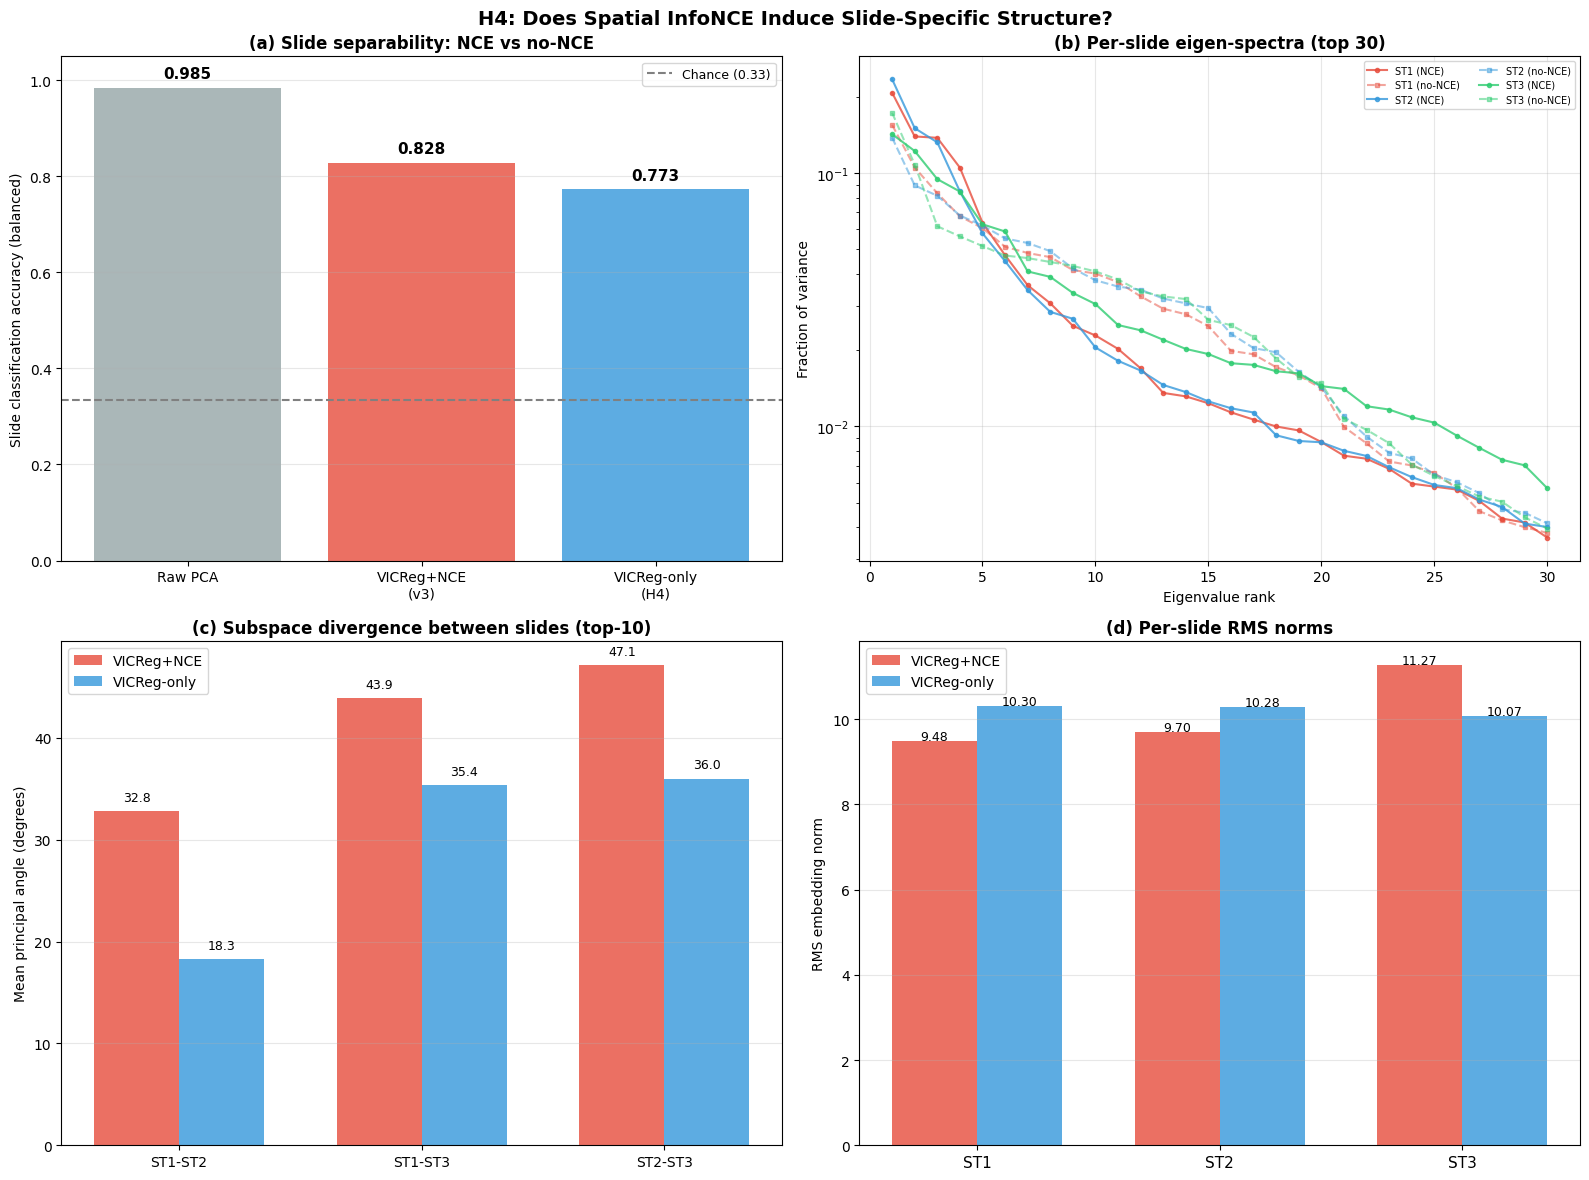


H4 SUMMARY
  Raw PCA slide acc:           0.985
  VICReg+NCE (v3) slide acc:   0.828
  VICReg-only (H4) slide acc:  0.773
  Delta (NCE - no-NCE):        +0.056
  Chance:                      0.333

  RMS norm ratio (max/min across slides):
    VICReg+NCE:  1.189
    VICReg-only: 1.023

  Mean principal angle between slides (top-10 subspace):
    VICReg+NCE:  41.3 deg
    VICReg-only: 29.9 deg

INTERPRETATION:
  -> NCE INCREASES slide separability by 0.056
     H4 CONFIRMED: Spatial InfoNCE contributes to slide confound

  -> NCE creates MORE divergent geometry across slides
     Each slide develops a different covariance structure (anisotropy)


In [8]:
# ===================================================================
# HYPOTHESIS H4 — STEP 2: Compare VICReg-only vs VICReg+NCE
# ===================================================================
# Test 1: Slide separability (linear probe) — does NCE add slide signal?
# Test 2: Per-slide covariance eigen-spectra — does NCE create geometry style?
# ===================================================================

import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from scipy.spatial import cKDTree

print("=" * 70)
print("HYPOTHESIS H4: Spatial InfoNCE induces slide-unique anisotropy?")
print("=" * 70)

# ── Load both encoders ──
# Encoder A: v3 (VICReg + spatial_nce=5.0)
encoder_v3_h4 = SharedEncoder(n_genes=n_genes, n_embedding=[512, 256, 128], dropout=0.1)
encoder_v3_h4.load_state_dict(torch.load(
    '/home/ehtesamul/sc_st/model/gems_liver_crossslide_v3/encoder_v3_final.pt',
    map_location=device
))
encoder_v3_h4.to(device).eval()

# Encoder B: H4 (VICReg only, spatial_nce=0.0)
encoder_h4_loaded = SharedEncoder(n_genes=n_genes, n_embedding=[512, 256, 128], dropout=0.1)
encoder_h4_loaded.load_state_dict(torch.load(
    '/home/ehtesamul/sc_st/model/gems_liver_crossslide_h4_vicreg_only/encoder_h4_vicreg_only.pt',
    map_location=device
))
encoder_h4_loaded.to(device).eval()

# ── Compute embeddings ──
st_np = st_expr.cpu().numpy()
labels = slide_ids.cpu().numpy()
n_slides = len(np.unique(labels))
slide_names_short = ['ST1', 'ST2', 'ST3']

with torch.no_grad():
    Z_nce = encoder_v3_h4(st_expr.to(device)).cpu().numpy()     # VICReg + NCE
    Z_vicreg = encoder_h4_loaded(st_expr.to(device)).cpu().numpy()  # VICReg only

print(f"  Spots: {Z_nce.shape[0]}, Embedding dim: {Z_nce.shape[1]}")
print(f"  Encoder A (v3, VICReg+NCE):  Z shape = {Z_nce.shape}")
print(f"  Encoder B (H4, VICReg only): Z shape = {Z_vicreg.shape}")

# ── TEST 4a: Slide separability comparison ───────────────────────────
print("\n" + "-" * 70)
print("TEST 4a: Slide separability — VICReg+NCE vs VICReg-only")
print("-" * 70)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# VICReg + NCE (v3)
Z_nce_norm = Z_nce / (np.linalg.norm(Z_nce, axis=1, keepdims=True) + 1e-8)
clf_nce = LogisticRegression(max_iter=2000, solver='lbfgs', multi_class='multinomial')
scores_nce = cross_val_score(clf_nce, Z_nce_norm, labels, cv=cv, scoring='balanced_accuracy')

# VICReg only (H4)
Z_vic_norm = Z_vicreg / (np.linalg.norm(Z_vicreg, axis=1, keepdims=True) + 1e-8)
clf_vic = LogisticRegression(max_iter=2000, solver='lbfgs', multi_class='multinomial')
scores_vic = cross_val_score(clf_vic, Z_vic_norm, labels, cv=cv, scoring='balanced_accuracy')

# Raw PCA baseline (expression only)
from sklearn.decomposition import PCA
X_pca_raw = StandardScaler().fit_transform(
    PCA(n_components=50, random_state=42).fit_transform(st_np))
clf_raw = LogisticRegression(max_iter=2000, solver='lbfgs', multi_class='multinomial')
scores_raw = cross_val_score(clf_raw, X_pca_raw, labels, cv=cv, scoring='balanced_accuracy')

print(f"  Raw PCA(50) slide acc:       {scores_raw.mean():.3f} +/- {scores_raw.std():.3f}")
print(f"  VICReg+NCE (v3) slide acc:   {scores_nce.mean():.3f} +/- {scores_nce.std():.3f}")
print(f"  VICReg-only (H4) slide acc:  {scores_vic.mean():.3f} +/- {scores_vic.std():.3f}")
print(f"  Chance:                      {1/n_slides:.3f}")

delta = scores_nce.mean() - scores_vic.mean()
print(f"\n  NCE - VICReg-only = {delta:+.3f}")

# ── TEST 4b: Per-slide embedding norms ───────────────────────────────
print("\n" + "-" * 70)
print("TEST 4b: Per-slide embedding norms")
print("-" * 70)

for enc_name, Z in [("VICReg+NCE (v3)", Z_nce), ("VICReg-only (H4)", Z_vicreg)]:
    print(f"\n  {enc_name}:")
    norms_per_slide = []
    for s in range(n_slides):
        m = labels == s
        rms = np.sqrt(np.mean(np.sum(Z[m] ** 2, axis=1)))
        mean_norm = np.mean(np.linalg.norm(Z[m], axis=1))
        norms_per_slide.append(rms)
        print(f"    {slide_names_short[s]}: RMS={rms:.3f}, mean L2={mean_norm:.3f}")
    ratio = max(norms_per_slide) / (min(norms_per_slide) + 1e-8)
    print(f"    Max/Min RMS ratio: {ratio:.3f}")

# ── TEST 4c: Per-slide covariance eigen-spectra ──────────────────────
print("\n" + "-" * 70)
print("TEST 4c: Per-slide covariance eigen-spectra")
print("-" * 70)

def compute_eigen_spectra(Z, labels, n_slides):
    """Compute eigenvalues and eigenvectors of per-slide covariance matrices."""
    results = {}
    for s in range(n_slides):
        m = labels == s
        Z_s = Z[m]
        Z_s_centered = Z_s - Z_s.mean(axis=0)
        cov = Z_s_centered.T @ Z_s_centered / (Z_s.shape[0] - 1)
        eigenvalues, eigenvectors = np.linalg.eigh(cov)
        # Sort descending
        idx = np.argsort(eigenvalues)[::-1]
        eigenvalues = eigenvalues[idx]
        eigenvectors = eigenvectors[:, idx]
        results[s] = {'eigenvalues': eigenvalues, 'eigenvectors': eigenvectors}
    return results

def principal_angles(V1, V2, k):
    """Compute principal angles between k-dimensional subspaces."""
    Q1, _ = np.linalg.qr(V1[:, :k])
    Q2, _ = np.linalg.qr(V2[:, :k])
    svals = np.linalg.svd(Q1.T @ Q2, compute_uv=False)
    svals = np.clip(svals, -1, 1)
    angles_deg = np.degrees(np.arccos(svals))
    return angles_deg

for enc_name, Z in [("VICReg+NCE (v3)", Z_nce), ("VICReg-only (H4)", Z_vicreg)]:
    print(f"\n  {enc_name}:")
    spectra = compute_eigen_spectra(Z, labels, n_slides)

    # Print top 10 eigenvalues per slide
    print(f"    Top 10 eigenvalues per slide:")
    header = f"    {'Rank':<6}"
    for sn in slide_names_short:
        header += f"  {sn:>10}"
    print(header)
    for i in range(10):
        row = f"    {i+1:<6}"
        for s in range(n_slides):
            row += f"  {spectra[s]['eigenvalues'][i]:>10.4f}"
        print(row)

    # Variance explained by top-k eigenvectors
    for k in [5, 10, 20]:
        print(f"\n    Variance explained by top-{k} eigenvectors:")
        for s in range(n_slides):
            total_var = spectra[s]['eigenvalues'].sum()
            topk_var = spectra[s]['eigenvalues'][:k].sum()
            print(f"      {slide_names_short[s]}: {100*topk_var/total_var:.1f}%")

    # Principal angles between slide subspaces
    print(f"\n    Principal angles (degrees) between slide subspaces (top-10):")
    for i in range(n_slides):
        for j in range(i + 1, n_slides):
            angles = principal_angles(
                spectra[i]['eigenvectors'], spectra[j]['eigenvectors'], k=10)
            print(f"      {slide_names_short[i]} vs {slide_names_short[j]}: "
                  f"mean={np.mean(angles):.1f}, min={np.min(angles):.1f}, max={np.max(angles):.1f}")

# ── TEST 4d: Spatial locality comparison ─────────────────────────────
print("\n" + "-" * 70)
print("TEST 4d: Spatial locality — does NCE actually help?")
print("-" * 70)

K_EVAL = 20
for enc_name, Z in [("VICReg+NCE (v3)", Z_nce), ("VICReg-only (H4)", Z_vicreg)]:
    print(f"\n  {enc_name}:")
    for name_s, s_idx in zip(slide_names_short, range(n_slides)):
        m = labels == s_idx
        Z_s = Z[m]
        coords_s = st_data[list(ST_PATHS.keys())[s_idx]].obsm['spatial']

        tree_emb = cKDTree(Z_s)
        tree_phys = cKDTree(coords_s)

        _, emb_idx = tree_emb.query(Z_s, k=K_EVAL + 1)
        emb_idx = emb_idx[:, 1:]
        _, phys_idx = tree_phys.query(coords_s, k=K_EVAL + 1)
        phys_idx = phys_idx[:, 1:]

        # Physical distance of embedding kNN
        emb_phys_d = np.median([
            np.median(np.linalg.norm(coords_s[emb_idx[i]] - coords_s[i], axis=1))
            for i in range(len(Z_s))
        ])
        # Physical distance of physical kNN
        phys_phys_d = np.median([
            np.median(np.linalg.norm(coords_s[phys_idx[i]] - coords_s[i], axis=1))
            for i in range(len(Z_s))
        ])
        # Overlap
        overlap = np.mean([
            len(set(emb_idx[i]) & set(phys_idx[i])) / K_EVAL
            for i in range(len(Z_s))
        ])

        print(f"    {name_s}: phys_kNN_dist={phys_phys_d:.1f}, emb_kNN_dist={emb_phys_d:.1f}, "
              f"overlap={overlap:.3f}")

# ===================================================================
# VISUALIZATION (2x2)
# ===================================================================
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# (a) Slide classification accuracy comparison
ax = axes[0, 0]
bar_labels = ['Raw PCA', 'VICReg+NCE\n(v3)', 'VICReg-only\n(H4)']
bar_vals = [scores_raw.mean(), scores_nce.mean(), scores_vic.mean()]
bar_colors = ['#95a5a6', '#e74c3c', '#3498db']
bars = ax.bar(range(len(bar_labels)), bar_vals, color=bar_colors, alpha=0.8)
ax.axhline(y=1/n_slides, color='gray', linestyle='--', label=f'Chance ({1/n_slides:.2f})')
ax.set_xticks(range(len(bar_labels)))
ax.set_xticklabels(bar_labels, fontsize=10)
ax.set_ylabel('Slide classification accuracy (balanced)')
ax.set_title('(a) Slide separability: NCE vs no-NCE', fontweight='bold')
ax.set_ylim(0, 1.05)
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3, axis='y')
for bar, val in zip(bars, bar_vals):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
            f'{val:.3f}', ha='center', fontsize=11, fontweight='bold')

# (b) Eigen-spectra comparison
ax = axes[0, 1]
spectra_nce = compute_eigen_spectra(Z_nce, labels, n_slides)
spectra_vic = compute_eigen_spectra(Z_vicreg, labels, n_slides)
colors_slides = ['#e74c3c', '#3498db', '#2ecc71']
for s in range(n_slides):
    ev_nce = spectra_nce[s]['eigenvalues'][:30]
    ev_vic = spectra_vic[s]['eigenvalues'][:30]
    ax.plot(range(1, 31), ev_nce / ev_nce.sum(), '-o', color=colors_slides[s],
            markersize=3, label=f'{slide_names_short[s]} (NCE)', alpha=0.8)
    ax.plot(range(1, 31), ev_vic / ev_vic.sum(), '--s', color=colors_slides[s],
            markersize=3, label=f'{slide_names_short[s]} (no-NCE)', alpha=0.5)
ax.set_xlabel('Eigenvalue rank')
ax.set_ylabel('Fraction of variance')
ax.set_title('(b) Per-slide eigen-spectra (top 30)', fontweight='bold')
ax.legend(fontsize=7, ncol=2)
ax.set_yscale('log')
ax.grid(True, alpha=0.3)

# (c) Principal angles between slides
ax = axes[1, 0]
pairs = [(0, 1), (0, 2), (1, 2)]
pair_labels = ['ST1-ST2', 'ST1-ST3', 'ST2-ST3']
x_pos = np.arange(len(pairs))
width = 0.35

angles_nce = []
angles_vic = []
for i, j in pairs:
    a_nce = principal_angles(spectra_nce[i]['eigenvectors'],
                              spectra_nce[j]['eigenvectors'], k=10)
    a_vic = principal_angles(spectra_vic[i]['eigenvectors'],
                              spectra_vic[j]['eigenvectors'], k=10)
    angles_nce.append(np.mean(a_nce))
    angles_vic.append(np.mean(a_vic))

ax.bar(x_pos - width/2, angles_nce, width, label='VICReg+NCE', color='#e74c3c', alpha=0.8)
ax.bar(x_pos + width/2, angles_vic, width, label='VICReg-only', color='#3498db', alpha=0.8)
ax.set_xticks(x_pos)
ax.set_xticklabels(pair_labels, fontsize=10)
ax.set_ylabel('Mean principal angle (degrees)')
ax.set_title('(c) Subspace divergence between slides (top-10)', fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3, axis='y')
for x, v1, v2 in zip(x_pos, angles_nce, angles_vic):
    ax.text(x - width/2, v1 + 1, f'{v1:.1f}', ha='center', fontsize=9)
    ax.text(x + width/2, v2 + 1, f'{v2:.1f}', ha='center', fontsize=9)

# (d) Per-slide RMS norm comparison
ax = axes[1, 1]
norms_nce = [np.sqrt(np.mean(np.sum(Z_nce[labels == s] ** 2, axis=1))) for s in range(n_slides)]
norms_vic = [np.sqrt(np.mean(np.sum(Z_vicreg[labels == s] ** 2, axis=1))) for s in range(n_slides)]
x_pos = np.arange(n_slides)
ax.bar(x_pos - width/2, norms_nce, width, label='VICReg+NCE', color='#e74c3c', alpha=0.8)
ax.bar(x_pos + width/2, norms_vic, width, label='VICReg-only', color='#3498db', alpha=0.8)
ax.set_xticks(x_pos)
ax.set_xticklabels(slide_names_short, fontsize=11)
ax.set_ylabel('RMS embedding norm')
ax.set_title('(d) Per-slide RMS norms', fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3, axis='y')
for x, v1, v2 in zip(x_pos, norms_nce, norms_vic):
    ax.text(x - width/2, v1 + 0.02, f'{v1:.2f}', ha='center', fontsize=9)
    ax.text(x + width/2, v2 + 0.02, f'{v2:.2f}', ha='center', fontsize=9)

plt.suptitle('H4: Does Spatial InfoNCE Induce Slide-Specific Structure?',
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# ===================================================================
# SUMMARY
# ===================================================================
print("\n" + "=" * 70)
print("H4 SUMMARY")
print("=" * 70)
print(f"  Raw PCA slide acc:           {scores_raw.mean():.3f}")
print(f"  VICReg+NCE (v3) slide acc:   {scores_nce.mean():.3f}")
print(f"  VICReg-only (H4) slide acc:  {scores_vic.mean():.3f}")
print(f"  Delta (NCE - no-NCE):        {delta:+.3f}")
print(f"  Chance:                      {1/n_slides:.3f}")

# RMS norm asymmetry
nce_ratio = max(norms_nce) / min(norms_nce)
vic_ratio = max(norms_vic) / min(norms_vic)
print(f"\n  RMS norm ratio (max/min across slides):")
print(f"    VICReg+NCE:  {nce_ratio:.3f}")
print(f"    VICReg-only: {vic_ratio:.3f}")

# Principal angles
mean_angle_nce = np.mean(angles_nce)
mean_angle_vic = np.mean(angles_vic)
print(f"\n  Mean principal angle between slides (top-10 subspace):")
print(f"    VICReg+NCE:  {mean_angle_nce:.1f} deg")
print(f"    VICReg-only: {mean_angle_vic:.1f} deg")

print("\nINTERPRETATION:")
if delta > 0.05:
    print(f"  -> NCE INCREASES slide separability by {delta:.3f}")
    print(f"     H4 CONFIRMED: Spatial InfoNCE contributes to slide confound")
elif delta < -0.05:
    print(f"  -> NCE DECREASES slide separability by {abs(delta):.3f}")
    print(f"     H4 FALSIFIED: NCE actually reduces slide signal (good!)")
else:
    print(f"  -> NCE has negligible effect on slide separability ({delta:+.3f})")
    print(f"     H4 FALSIFIED: Confound is upstream (H1/H2/H3), NCE is not the issue")

if mean_angle_nce > mean_angle_vic + 5:
    print(f"\n  -> NCE creates MORE divergent geometry across slides")
    print(f"     Each slide develops a different covariance structure (anisotropy)")
elif mean_angle_nce < mean_angle_vic - 5:
    print(f"\n  -> NCE creates MORE aligned geometry across slides")
    print(f"     NCE actually homogenizes covariance structure")
else:
    print(f"\n  -> Covariance geometry is similar with and without NCE")
print("=" * 70)


# check hypothesis 5

HYPOTHESIS H5: Slide separability from biological section differences
  Pericentral: 6/6 present
  Periportal: 7/7 present
  Kupffer: 5/5 present
  Endothelial: 5/5 present
  Stellate: 5/5 present
  Mito: 5/5 present
  Ribo: 0/5 present  (missing: ['Rpl13', 'Rps18', 'Rpl4', 'Rps3', 'Rpl10'])
  Hepatocyte_core: 2/5 present  (missing: ['Ttr', 'Apoa2', 'Fabp1'])

----------------------------------------------------------------------
TEST 5a: What genes separate slides? Do they overlap with biology?
----------------------------------------------------------------------

  Top 30 slide-separating genes (by LogReg weight magnitude):
  Rank   Gene            Importance   Category
  --------------------------------------------------
  1      Gstp1           0.6299       Other
  2      Apoc3           0.3481       Other
  3      Mup3            0.3460       Other
  4      Serpina1a       0.3332       Other
  5      Serpina1c       0.3243       Hepatocyte_core
  6      Orm1            0.3126    

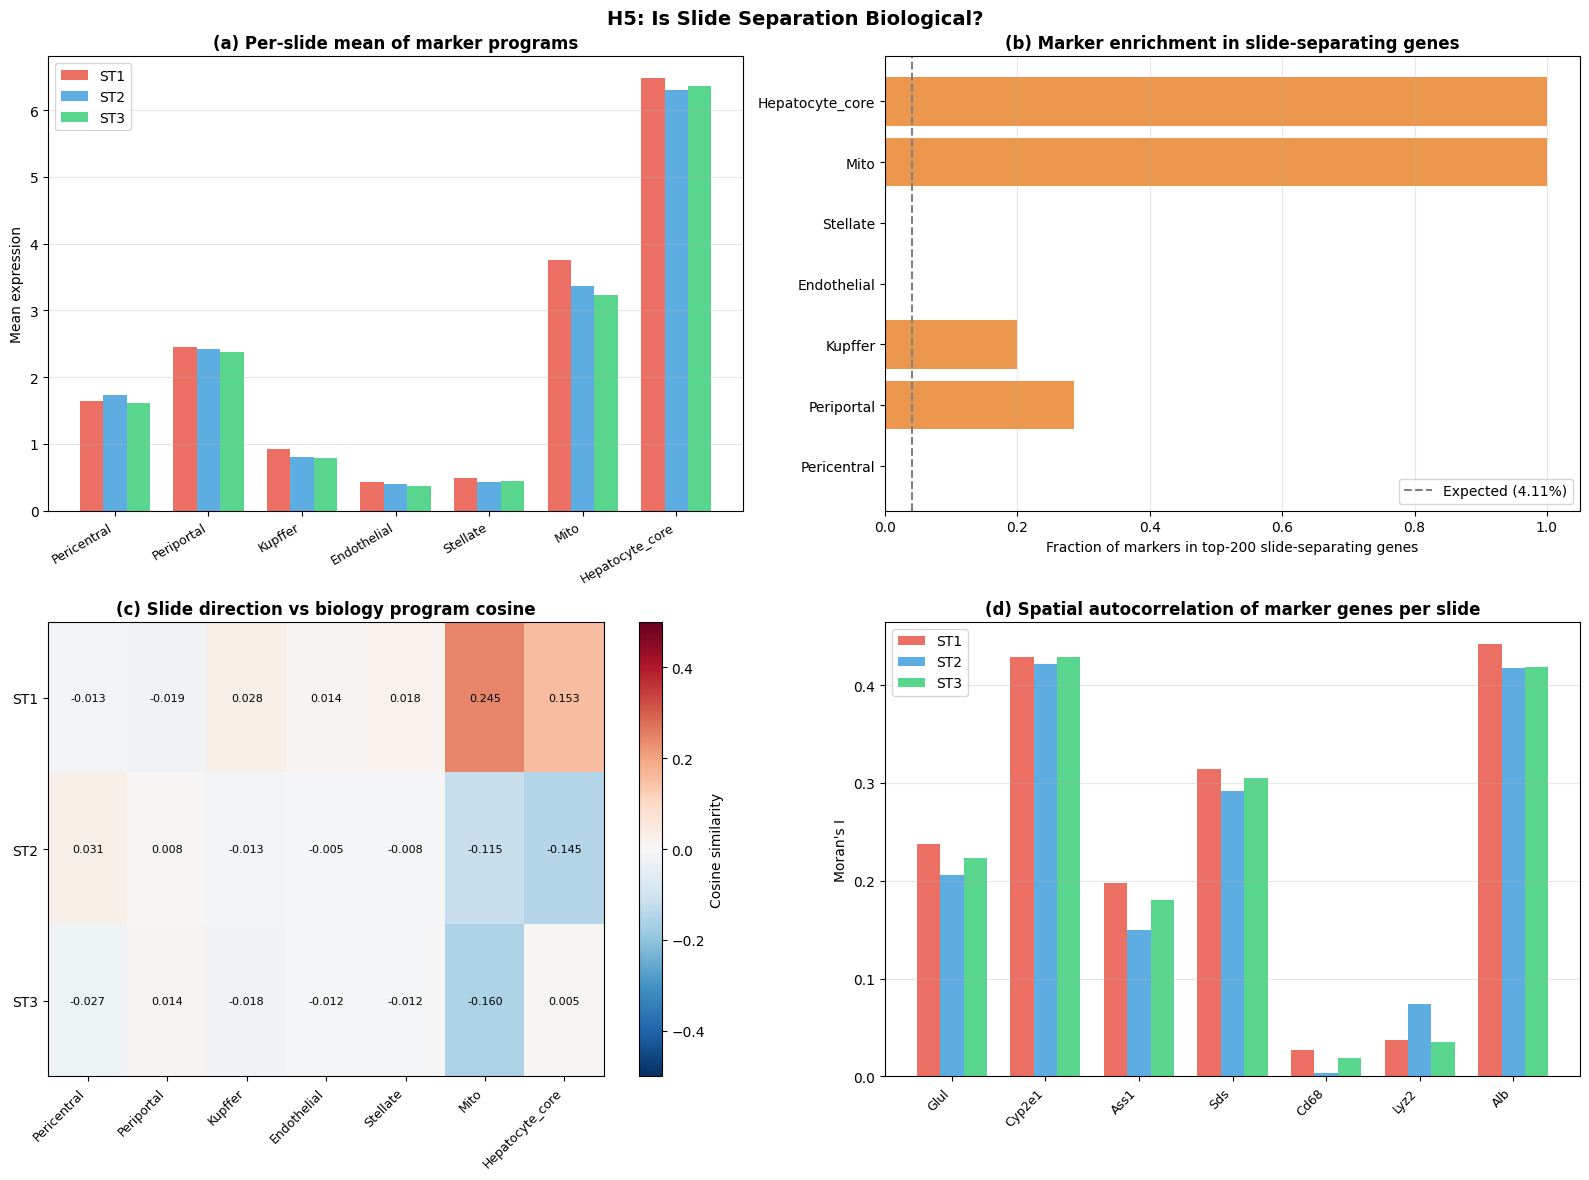


H5 SUMMARY
  Raw slide acc:           0.985
  Mean-centered slide acc: 0.006
  Chance:                  0.333

  Biology markers in top-100 slide-separating genes: 9/35
  Expected by chance: 0.7/35
  Enrichment: 12.5x

INTERPRETATION:
  If biology markers are enriched → slide differences are partly real biology
  If markers are NOT enriched → batch is technical, not biological
  If Moran's I differs across slides → spatial biology genuinely differs


In [9]:
# ===================================================================
# HYPOTHESIS H5: Slide clustering correlates with known biology?
# ===================================================================
# Do the directions that separate slides correspond to real biology
# (zonation, immune, endothelial) rather than pure technical artifact?
# ===================================================================

import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from scipy.spatial import cKDTree
from scipy.stats import spearmanr

print("=" * 70)
print("HYPOTHESIS H5: Slide separability from biological section differences")
print("=" * 70)

st_np = st_expr.cpu().numpy()
labels = slide_ids.cpu().numpy()
n_slides = len(np.unique(labels))
slide_names = ['ST1', 'ST2', 'ST3']

# ── Known mouse liver marker genes ──────────────────────────────────
MARKER_SETS = {
    'Pericentral': ['Glul', 'Cyp2e1', 'Cyp1a2', 'Oat', 'Aldh1b1', 'Slc1a2'],
    'Periportal':  ['Ass1', 'Sds', 'Hal', 'Arg1', 'Cyp2f2', 'Hamp', 'Hamp2'],
    'Kupffer':     ['Cd68', 'Lyz2', 'Clec4f', 'Adgre1', 'Csf1r'],
    'Endothelial': ['Pecam1', 'Kdr', 'Lyve1', 'Stab2', 'Ehd3'],
    'Stellate':    ['Dcn', 'Col1a1', 'Col3a1', 'Lrat', 'Rgs5'],
    'Mito':        ['mt-Co1', 'mt-Co2', 'mt-Cytb', 'mt-Nd1', 'mt-Atp6'],
    'Ribo':        ['Rpl13', 'Rps18', 'Rpl4', 'Rps3', 'Rpl10'],
    'Hepatocyte_core': ['Alb', 'Ttr', 'Apoa2', 'Serpina1c', 'Fabp1'],
}

# Filter to genes present in common_genes
gene_list = list(common_genes) if isinstance(common_genes, (list, np.ndarray)) else common_genes
gene_to_idx = {g: i for i, g in enumerate(gene_list)}

marker_presence = {}
for cat, genes in MARKER_SETS.items():
    present = [g for g in genes if g in gene_to_idx]
    absent = [g for g in genes if g not in gene_to_idx]
    marker_presence[cat] = present
    print(f"  {cat}: {len(present)}/{len(genes)} present", end="")
    if absent:
        print(f"  (missing: {absent})", end="")
    print()

# ── TEST 5a: Slide-separating genes vs biology markers ──────────────
print("\n" + "-" * 70)
print("TEST 5a: What genes separate slides? Do they overlap with biology?")
print("-" * 70)

# Train LogReg on raw expression → get weights
scaler = StandardScaler()
X_scaled = scaler.fit_transform(st_np)
clf = LogisticRegression(max_iter=2000, solver='lbfgs', multi_class='multinomial', C=1.0)
clf.fit(X_scaled, labels)

# clf.coef_ shape: (n_slides, n_genes) — each row separates one slide from rest
# Compute "importance" per gene: L2 norm across slide directions
gene_importance = np.linalg.norm(clf.coef_, axis=0)  # (n_genes,)
gene_rank = np.argsort(gene_importance)[::-1]

print(f"\n  Top 30 slide-separating genes (by LogReg weight magnitude):")
print(f"  {'Rank':<6} {'Gene':<15} {'Importance':<12} {'Category'}")
print(f"  {'-'*50}")
for i in range(30):
    idx = gene_rank[i]
    gname = gene_list[idx]
    imp = gene_importance[idx]
    cat = 'Other'
    for c, gs in marker_presence.items():
        if gname in gs:
            cat = c
            break
    print(f"  {i+1:<6} {gname:<15} {imp:<12.4f} {cat}")

# Count categories in top-N slide separating genes
for topN in [50, 100, 200]:
    top_genes = set(gene_list[gene_rank[i]] for i in range(topN))
    print(f"\n  Top-{topN} slide-separating genes — marker category counts:")
    for cat, gs in marker_presence.items():
        overlap = top_genes & set(gs)
        frac = len(overlap) / len(gs) if gs else 0
        if overlap:
            print(f"    {cat}: {len(overlap)}/{len(gs)} ({frac:.0%}) — {sorted(overlap)}")

# ── TEST 5b: Per-slide mean expression of marker programs ───────────
print("\n" + "-" * 70)
print("TEST 5b: Per-slide mean expression of biological marker programs")
print("-" * 70)

print(f"\n  {'Program':<20}", end="")
for sn in slide_names:
    print(f"  {sn:>8}", end="")
print(f"  {'Max diff':>10}  {'Fold':>6}")
print(f"  {'-'*70}")

program_diffs = {}
for cat, genes in marker_presence.items():
    if not genes:
        continue
    idxs = [gene_to_idx[g] for g in genes]
    means = []
    for s in range(n_slides):
        m = labels == s
        slide_mean = st_np[m][:, idxs].mean()
        means.append(slide_mean)
    max_diff = max(means) - min(means)
    fold = max(means) / (min(means) + 1e-8)
    program_diffs[cat] = {'means': means, 'max_diff': max_diff, 'fold': fold}
    print(f"  {cat:<20}", end="")
    for v in means:
        print(f"  {v:>8.3f}", end="")
    print(f"  {max_diff:>10.3f}  {fold:>6.2f}x")

# ── TEST 5c: Per-slide spatial autocorrelation (Moran's I) ──────────
print("\n" + "-" * 70)
print("TEST 5c: Spatial autocorrelation of biology markers per slide")
print("-" * 70)
print("  (Moran's I > 0 = spatially structured; different I across slides")
print("   means slides capture different spatial biology)")

def morans_i_knn(vals, coords, k=10):
    """Compute Moran's I using kNN spatial weights."""
    n = len(vals)
    tree = cKDTree(coords)
    _, idx = tree.query(coords, k=k+1)
    idx = idx[:, 1:]  # exclude self
    x = vals - vals.mean()
    var = np.var(vals)
    if var < 1e-12:
        return 0.0
    W = 0.0
    num = 0.0
    for i in range(n):
        for j in idx[i]:
            W += 1.0
            num += x[i] * x[j]
    return (n / W) * (num / (n * var))

# Select representative markers for Moran's I
test_markers = {
    'Pericentral': ['Glul', 'Cyp2e1'],
    'Periportal': ['Ass1', 'Sds'],
    'Kupffer': ['Cd68', 'Lyz2'],
    'Hepatocyte': ['Alb', 'Ttr'],
}

print(f"\n  {'Gene':<12} {'Category':<15}", end="")
for sn in slide_names:
    print(f" {sn:>8}", end="")
print(f"  {'Max-Min':>8}")
print(f"  {'-'*65}")

for cat, genes in test_markers.items():
    for gname in genes:
        if gname not in gene_to_idx:
            continue
        gidx = gene_to_idx[gname]
        morans = []
        for s, sn in enumerate(slide_names):
            m = labels == s
            coords_s = st_data[list(ST_PATHS.keys())[s]].obsm['spatial']
            vals_s = st_np[m, gidx]
            mi = morans_i_knn(vals_s, coords_s, k=10)
            morans.append(mi)
        diff = max(morans) - min(morans)
        print(f"  {gname:<12} {cat:<15}", end="")
        for mi in morans:
            print(f" {mi:>8.3f}", end="")
        print(f"  {diff:>8.3f}")

# ── TEST 5d: After mean-centering, what separates slides? ───────────
print("\n" + "-" * 70)
print("TEST 5d: After mean-centering — residual slide signal is biological?")
print("-" * 70)

# Mean-center per slide
X_mc = st_np.copy()
for s in range(n_slides):
    m = labels == s
    X_mc[m] -= X_mc[m].mean(axis=0)
global_mean = st_np.mean(axis=0)
X_mc += global_mean

# Retrain classifier on mean-centered data
X_mc_scaled = StandardScaler().fit_transform(X_mc)
clf_mc = LogisticRegression(max_iter=2000, solver='lbfgs', multi_class='multinomial', C=1.0)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores_mc = cross_val_score(clf_mc, X_mc_scaled, labels, cv=cv, scoring='balanced_accuracy')
clf_mc.fit(X_mc_scaled, labels)

print(f"  Mean-centered slide acc: {scores_mc.mean():.3f} +/- {scores_mc.std():.3f}")
print(f"  (Recall: raw slide acc = 0.985, chance = 0.333)")

gene_imp_mc = np.linalg.norm(clf_mc.coef_, axis=0)
gene_rank_mc = np.argsort(gene_imp_mc)[::-1]

print(f"\n  Top 30 slide-separating genes AFTER mean-centering:")
print(f"  {'Rank':<6} {'Gene':<15} {'Importance':<12} {'Category'}")
print(f"  {'-'*50}")
for i in range(30):
    idx = gene_rank_mc[i]
    gname = gene_list[idx]
    imp = gene_imp_mc[idx]
    cat = 'Other'
    for c, gs in marker_presence.items():
        if gname in gs:
            cat = c
            break
    print(f"  {i+1:<6} {gname:<15} {imp:<12.4f} {cat}")

# Count biology markers in post-MC top genes
for topN in [50, 100]:
    top_genes = set(gene_list[gene_rank_mc[i]] for i in range(topN))
    print(f"\n  Top-{topN} AFTER mean-centering — marker counts:")
    for cat, gs in marker_presence.items():
        overlap = top_genes & set(gs)
        if overlap:
            frac = len(overlap) / len(gs) if gs else 0
            print(f"    {cat}: {len(overlap)}/{len(gs)} ({frac:.0%}) — {sorted(overlap)}")

# ── TEST 5e: Per-slide LogReg directions — cosine with biology ──────
print("\n" + "-" * 70)
print("TEST 5e: Slide-separating directions vs biology program vectors")
print("-" * 70)

# Build "program vectors" — average expression profile of each marker set
program_vectors = {}
for cat, genes in marker_presence.items():
    if len(genes) < 2:
        continue
    idxs = [gene_to_idx[g] for g in genes]
    pvec = np.zeros(n_genes)
    for i in idxs:
        pvec[i] = 1.0
    pvec /= (np.linalg.norm(pvec) + 1e-8)
    program_vectors[cat] = pvec

# Slide separation direction: mean of absolute coef across classes
slide_sep_dir = np.mean(np.abs(clf.coef_), axis=0)
slide_sep_dir /= (np.linalg.norm(slide_sep_dir) + 1e-8)

# Also per-slide directions
print(f"\n  Cosine similarity: slide-separation direction vs biology programs")
print(f"  {'Program':<20} {'Global sep':>12}", end="")
for sn in slide_names:
    print(f"  {sn+' coef':>10}", end="")
print()
print(f"  {'-'*65}")

for cat, pvec in program_vectors.items():
    cos_global = np.dot(slide_sep_dir, pvec)
    print(f"  {cat:<20} {cos_global:>12.4f}", end="")
    for s in range(n_slides):
        w_s = clf.coef_[s]
        w_s_norm = w_s / (np.linalg.norm(w_s) + 1e-8)
        cos_s = np.dot(w_s_norm, pvec)
        print(f"  {cos_s:>10.4f}", end="")
    print()

# ===================================================================
# VISUALIZATION
# ===================================================================
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# (a) Per-slide mean of marker programs
ax = axes[0, 0]
cats = list(program_diffs.keys())
x = np.arange(len(cats))
width = 0.25
colors = ['#e74c3c', '#3498db', '#2ecc71']
for s in range(n_slides):
    vals = [program_diffs[c]['means'][s] for c in cats]
    ax.bar(x + s * width, vals, width, label=slide_names[s], color=colors[s], alpha=0.8)
ax.set_xticks(x + width)
ax.set_xticklabels(cats, rotation=30, ha='right', fontsize=9)
ax.set_ylabel('Mean expression')
ax.set_title('(a) Per-slide mean of marker programs', fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# (b) Gene importance distribution by category
ax = axes[0, 1]
top200 = set(gene_rank[:200])
cat_counts_raw = {}
cat_counts_top = {}
for cat, genes in marker_presence.items():
    if not genes:
        continue
    idxs_set = set(gene_to_idx[g] for g in genes)
    cat_counts_raw[cat] = len(genes)
    cat_counts_top[cat] = len(idxs_set & top200)

cats_plot = [c for c in cat_counts_raw if cat_counts_raw[c] > 0]
enrichment = [cat_counts_top[c] / cat_counts_raw[c] for c in cats_plot]
ax.barh(cats_plot, enrichment, color='#e67e22', alpha=0.8)
ax.axvline(x=200/n_genes, color='gray', linestyle='--', label=f'Expected ({200/n_genes:.2%})')
ax.set_xlabel('Fraction of markers in top-200 slide-separating genes')
ax.set_title('(b) Marker enrichment in slide-separating genes', fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3, axis='x')

# (c) Cosine similarity heatmap
ax = axes[1, 0]
programs = list(program_vectors.keys())
cos_matrix = np.zeros((n_slides, len(programs)))
for s in range(n_slides):
    w_s = clf.coef_[s] / (np.linalg.norm(clf.coef_[s]) + 1e-8)
    for j, cat in enumerate(programs):
        cos_matrix[s, j] = np.dot(w_s, program_vectors[cat])
im = ax.imshow(cos_matrix, cmap='RdBu_r', vmin=-0.5, vmax=0.5, aspect='auto')
ax.set_xticks(range(len(programs)))
ax.set_xticklabels(programs, rotation=45, ha='right', fontsize=9)
ax.set_yticks(range(n_slides))
ax.set_yticklabels(slide_names)
for i in range(n_slides):
    for j in range(len(programs)):
        ax.text(j, i, f'{cos_matrix[i,j]:.3f}', ha='center', va='center', fontsize=8)
plt.colorbar(im, ax=ax, label='Cosine similarity')
ax.set_title('(c) Slide direction vs biology program cosine', fontweight='bold')

# (d) Per-slide Moran's I for key markers
ax = axes[1, 1]
test_genes_flat = []
morans_data = {}
for cat, genes in test_markers.items():
    for gname in genes:
        if gname in gene_to_idx:
            test_genes_flat.append(gname)
            morans_data[gname] = []
            gidx = gene_to_idx[gname]
            for s in range(n_slides):
                m = labels == s
                coords_s = st_data[list(ST_PATHS.keys())[s]].obsm['spatial']
                mi = morans_i_knn(st_np[m, gidx], coords_s, k=10)
                morans_data[gname].append(mi)

x = np.arange(len(test_genes_flat))
for s in range(n_slides):
    vals = [morans_data[g][s] for g in test_genes_flat]
    ax.bar(x + s * width, vals, width, label=slide_names[s], color=colors[s], alpha=0.8)
ax.set_xticks(x + width)
ax.set_xticklabels(test_genes_flat, rotation=45, ha='right', fontsize=9)
ax.set_ylabel("Moran's I")
ax.set_title("(d) Spatial autocorrelation of marker genes per slide", fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.suptitle('H5: Is Slide Separation Biological?', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# ===================================================================
# SUMMARY
# ===================================================================
print("\n" + "=" * 70)
print("H5 SUMMARY")
print("=" * 70)
print(f"  Raw slide acc:           0.985")
print(f"  Mean-centered slide acc: {scores_mc.mean():.3f}")
print(f"  Chance:                  {1/n_slides:.3f}")

# Check if biology markers are enriched in top separating genes
total_markers = sum(len(gs) for gs in marker_presence.values())
top100_set = set(gene_list[gene_rank[i]] for i in range(100))
markers_in_top100 = sum(1 for cat, gs in marker_presence.items() for g in gs if g in top100_set)
expected = 100 * total_markers / n_genes
print(f"\n  Biology markers in top-100 slide-separating genes: {markers_in_top100}/{total_markers}")
print(f"  Expected by chance: {expected:.1f}/{total_markers}")
print(f"  Enrichment: {markers_in_top100/expected:.1f}x")

print("\nINTERPRETATION:")
print("  If biology markers are enriched → slide differences are partly real biology")
print("  If markers are NOT enriched → batch is technical, not biological")
print("  If Moran's I differs across slides → spatial biology genuinely differs")
print("=" * 70)


# hypothesis 6 testing

HYPOTHESIS H6: Unconditional alignment fights locality?
  v3 (no alignment):    Z shape = (3972, 128)
  v4 (source_coral=2):  Z shape = (3972, 128)

----------------------------------------------------------------------
TEST 6a: Spatial locality — v3 (no alignment) vs v4 (global CORAL)
----------------------------------------------------------------------

  Slide      v3 overlap   v4 overlap    Delta     v3 dist    v4 dist
  -----------------------------------------------------------------
  liver_ST1        0.669        0.268   -0.401        66.3      226.6
  liver_ST2        0.680        0.258   -0.422        65.9      227.1
  liver_ST3        0.691        0.225   -0.466        65.9      277.4

  Mean overlap: v3=0.680, v4=0.250, delta=-0.430

  Slide acc: v3=0.828, v4=0.775
  (v4 should have LOWER slide acc if CORAL worked, but may lose locality)

----------------------------------------------------------------------
TEST 6b: Post-hoc GLOBAL CORAL correction on v3 embeddings
------

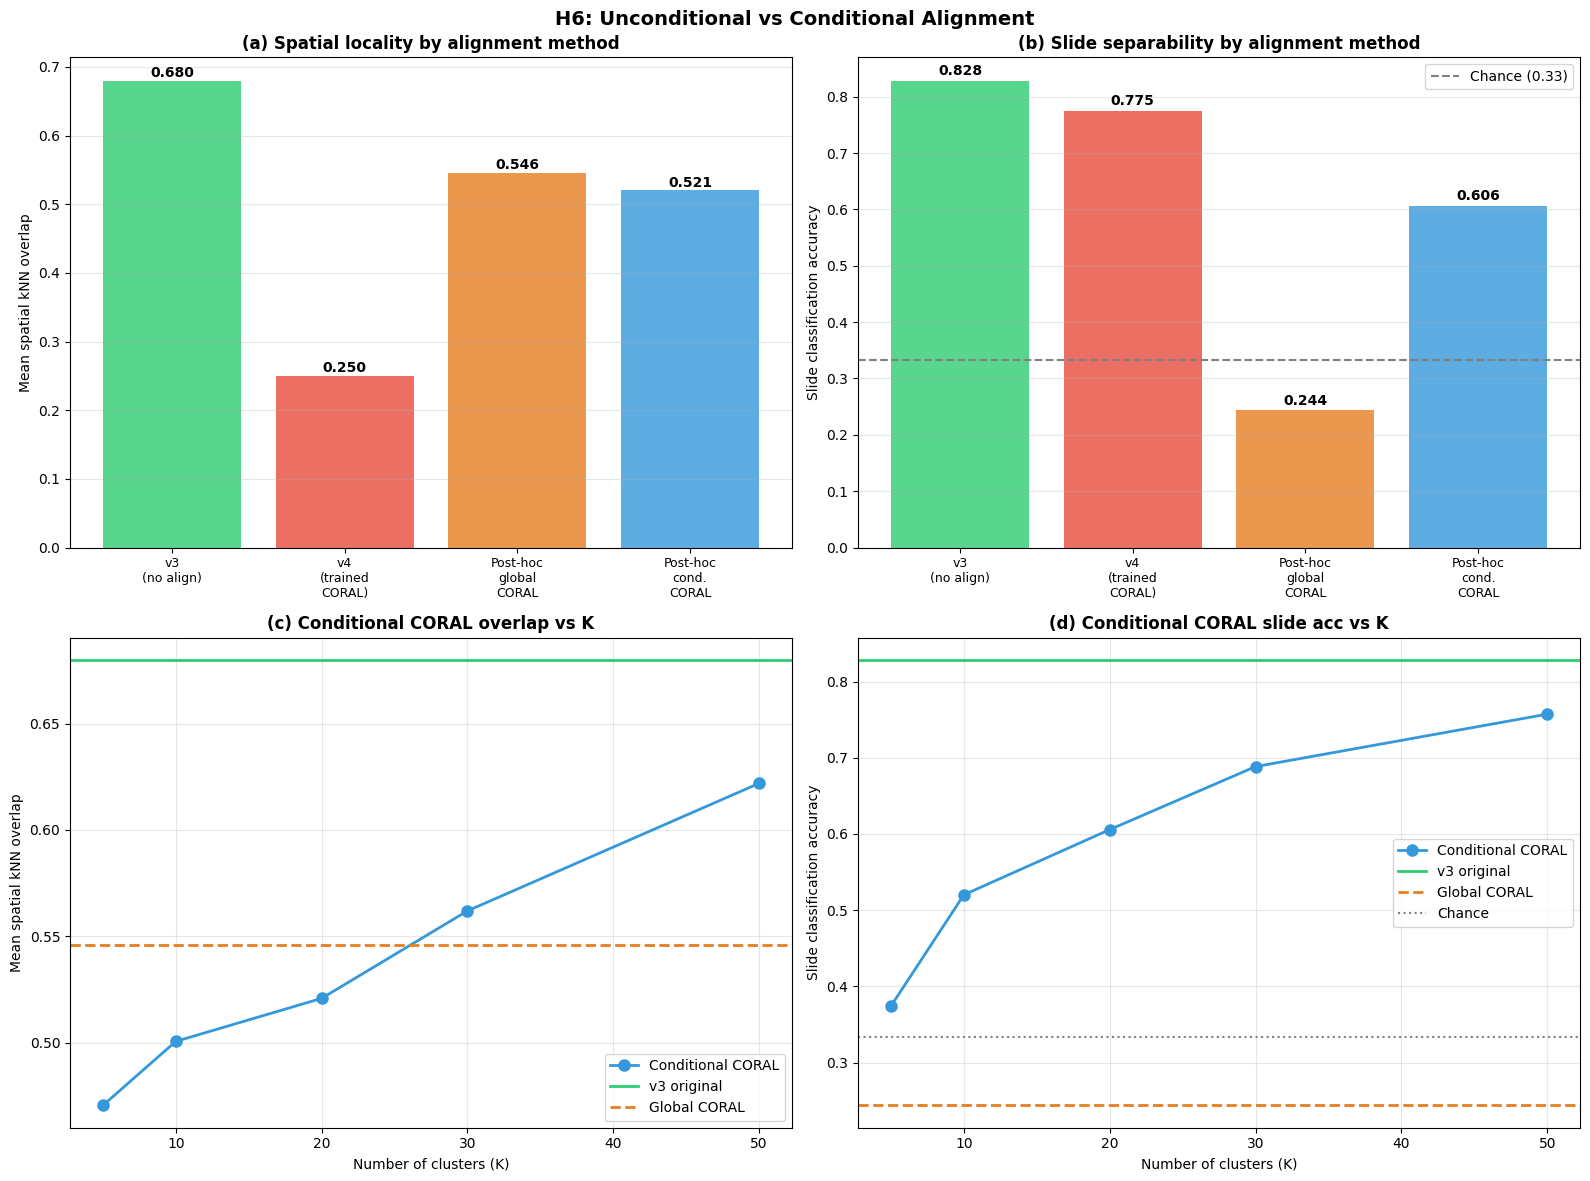


H6 SUMMARY
  v3 (no alignment):       overlap=0.680, slide_acc=0.828
  v4 (trained CORAL):      overlap=0.250, slide_acc=0.775
  Post-hoc global CORAL:   overlap=0.546, slide_acc=0.244
  Post-hoc cond. CORAL:    overlap=0.521, slide_acc=0.606
  Chance: 0.333

  Locality change from alignment:
    Trained CORAL:      -0.430
    Post-hoc global:    -0.134
    Post-hoc cond (20): -0.159

  Slide acc change from alignment:
    Trained CORAL:      -0.054
    Post-hoc global:    -0.585
    Post-hoc cond (20): -0.222

INTERPRETATION:
  -> Both global and conditional hurt locality
     H6 PARTIALLY CONFIRMED: alignment itself is the issue, not just conditioning


In [10]:
# ===================================================================
# HYPOTHESIS H6: Global alignment distorts geometry, conditional doesn't?
# ===================================================================
# Global CORAL/MMD matches marginal distributions across slides.
# With multi-modal ST (by slide), the cheapest way to match marginals
# is to distort the geometry-bearing space.
# Test: post-hoc global vs conditional CORAL on v3 embeddings.
# ===================================================================

import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold
from scipy.spatial import cKDTree
from scipy.linalg import sqrtm, inv

print("=" * 70)
print("HYPOTHESIS H6: Unconditional alignment fights locality?")
print("=" * 70)

labels = slide_ids.cpu().numpy()
n_slides = len(np.unique(labels))
slide_names = ['ST1', 'ST2', 'ST3']

# ── Load v3 (no alignment) and v4 (source_coral=2.0) ────────────────
# v3: already loaded from H4 as encoder_v3_h4, or reload
encoder_v3_h6 = SharedEncoder(n_genes=n_genes, n_embedding=[512, 256, 128], dropout=0.1)
encoder_v3_h6.load_state_dict(torch.load(
    '/home/ehtesamul/sc_st/model/gems_liver_crossslide_v3/encoder_v3_final.pt',
    map_location=device))
encoder_v3_h6.to(device).eval()

encoder_v4_h6 = SharedEncoder(n_genes=n_genes, n_embedding=[512, 256, 128], dropout=0.1)
encoder_v4_h6.load_state_dict(torch.load(
    '/home/ehtesamul/sc_st/model/gems_liver_crossslide_v4/gems_liver_crossslide_v4/encoder_v4_final.pt',
    map_location=device))
encoder_v4_h6.to(device).eval()

with torch.no_grad():
    Z_v3 = encoder_v3_h6(st_expr.to(device)).cpu().numpy()
    Z_v4 = encoder_v4_h6(st_expr.to(device)).cpu().numpy()

print(f"  v3 (no alignment):    Z shape = {Z_v3.shape}")
print(f"  v4 (source_coral=2):  Z shape = {Z_v4.shape}")

# ── Helper: spatial locality metrics ─────────────────────────────────
def spatial_locality(Z, labels, coords_dict, slide_keys, k=20):
    """Compute per-slide spatial locality metrics."""
    results = {}
    for s, skey in enumerate(slide_keys):
        m = labels == s
        Z_s = Z[m]
        coords_s = coords_dict[skey]
        tree_emb = cKDTree(Z_s)
        tree_phys = cKDTree(coords_s)
        _, emb_idx = tree_emb.query(Z_s, k=k+1)
        emb_idx = emb_idx[:, 1:]
        _, phys_idx = tree_phys.query(coords_s, k=k+1)
        phys_idx = phys_idx[:, 1:]
        overlap = np.mean([
            len(set(emb_idx[i]) & set(phys_idx[i])) / k
            for i in range(len(Z_s))
        ])
        emb_d = np.median([
            np.median(np.linalg.norm(coords_s[emb_idx[i]] - coords_s[i], axis=1))
            for i in range(len(Z_s))
        ])
        results[skey] = {'overlap': overlap, 'emb_phys_dist': emb_d}
    return results

slide_keys = list(ST_PATHS.keys())
coords_dict = {name: st_data[name].obsm['spatial'] for name in slide_keys}

# ── TEST 6a: v3 vs v4 spatial locality ───────────────────────────────
print("\n" + "-" * 70)
print("TEST 6a: Spatial locality — v3 (no alignment) vs v4 (global CORAL)")
print("-" * 70)

loc_v3 = spatial_locality(Z_v3, labels, coords_dict, slide_keys)
loc_v4 = spatial_locality(Z_v4, labels, coords_dict, slide_keys)

print(f"\n  {'Slide':<8} {'v3 overlap':>12} {'v4 overlap':>12} {'Delta':>8}  "
      f"{'v3 dist':>10} {'v4 dist':>10}")
print(f"  {'-'*65}")
for skey in slide_keys:
    o3 = loc_v3[skey]['overlap']
    o4 = loc_v4[skey]['overlap']
    d3 = loc_v3[skey]['emb_phys_dist']
    d4 = loc_v4[skey]['emb_phys_dist']
    print(f"  {skey:<8} {o3:>12.3f} {o4:>12.3f} {o4-o3:>+8.3f}  {d3:>10.1f} {d4:>10.1f}")

mean_o3 = np.mean([loc_v3[k]['overlap'] for k in slide_keys])
mean_o4 = np.mean([loc_v4[k]['overlap'] for k in slide_keys])
print(f"\n  Mean overlap: v3={mean_o3:.3f}, v4={mean_o4:.3f}, delta={mean_o4-mean_o3:+.3f}")

# Slide separability
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
Z_v3n = Z_v3 / (np.linalg.norm(Z_v3, axis=1, keepdims=True) + 1e-8)
Z_v4n = Z_v4 / (np.linalg.norm(Z_v4, axis=1, keepdims=True) + 1e-8)
acc_v3 = cross_val_score(
    LogisticRegression(max_iter=2000), Z_v3n, labels, cv=cv,
    scoring='balanced_accuracy').mean()
acc_v4 = cross_val_score(
    LogisticRegression(max_iter=2000), Z_v4n, labels, cv=cv,
    scoring='balanced_accuracy').mean()
print(f"\n  Slide acc: v3={acc_v3:.3f}, v4={acc_v4:.3f}")
print(f"  (v4 should have LOWER slide acc if CORAL worked, but may lose locality)")

# ── CORAL transform helpers ──────────────────────────────────────────
def safe_sqrtm(M, eps=1e-6):
    """Numerically stable matrix square root via eigendecomposition."""
    eigvals, eigvecs = np.linalg.eigh(M)
    eigvals = np.maximum(eigvals, eps)
    return eigvecs @ np.diag(np.sqrt(eigvals)) @ eigvecs.T

def safe_inv_sqrtm(M, eps=1e-6):
    """Numerically stable inverse matrix square root."""
    eigvals, eigvecs = np.linalg.eigh(M)
    eigvals = np.maximum(eigvals, eps)
    return eigvecs @ np.diag(1.0 / np.sqrt(eigvals)) @ eigvecs.T

def coral_transform(Z_slide, mu_slide, cov_slide, mu_target, cov_target):
    """Apply CORAL: whiten by source, color by target."""
    W = safe_inv_sqrtm(cov_slide)        # whiten
    C = safe_sqrtm(cov_target)            # color
    Z_centered = Z_slide - mu_slide
    Z_transformed = Z_centered @ W @ C + mu_target
    return Z_transformed

# ── TEST 6b: Post-hoc GLOBAL CORAL on v3 embeddings ─────────────────
print("\n" + "-" * 70)
print("TEST 6b: Post-hoc GLOBAL CORAL correction on v3 embeddings")
print("-" * 70)

# Global target: pool all slides
mu_global = Z_v3.mean(axis=0)
Z_centered_global = Z_v3 - mu_global
cov_global = Z_centered_global.T @ Z_centered_global / (Z_v3.shape[0] - 1)

Z_global_coral = np.zeros_like(Z_v3)
for s in range(n_slides):
    m = labels == s
    Z_s = Z_v3[m]
    mu_s = Z_s.mean(axis=0)
    Z_s_c = Z_s - mu_s
    cov_s = Z_s_c.T @ Z_s_c / (Z_s.shape[0] - 1)
    Z_global_coral[m] = coral_transform(Z_s, mu_s, cov_s, mu_global, cov_global)

# Measure locality after global CORAL
loc_gc = spatial_locality(Z_global_coral, labels, coords_dict, slide_keys)
Z_gcn = Z_global_coral / (np.linalg.norm(Z_global_coral, axis=1, keepdims=True) + 1e-8)
acc_gc = cross_val_score(
    LogisticRegression(max_iter=2000), Z_gcn, labels, cv=cv,
    scoring='balanced_accuracy').mean()

print(f"  Slide acc after global CORAL: {acc_gc:.3f} (was {acc_v3:.3f})")
print(f"\n  {'Slide':<8} {'Before':>10} {'After':>10} {'Delta':>8}")
print(f"  {'-'*40}")
for skey in slide_keys:
    o_before = loc_v3[skey]['overlap']
    o_after = loc_gc[skey]['overlap']
    print(f"  {skey:<8} {o_before:>10.3f} {o_after:>10.3f} {o_after-o_before:>+8.3f}")

mean_gc = np.mean([loc_gc[k]['overlap'] for k in slide_keys])
print(f"\n  Mean overlap: before={mean_o3:.3f}, after global CORAL={mean_gc:.3f}, "
      f"delta={mean_gc-mean_o3:+.3f}")

# ── TEST 6c: Post-hoc CONDITIONAL CORAL (per pseudo-type) ───────────
print("\n" + "-" * 70)
print("TEST 6c: Post-hoc CONDITIONAL CORAL (per pseudo-type, K=20)")
print("-" * 70)

K = 20
kmeans = KMeans(n_clusters=K, n_init=10, random_state=42)
cluster_labels = kmeans.fit_predict(Z_v3)

Z_cond_coral = np.zeros_like(Z_v3)
n_corrected = 0
n_fallback = 0

for c in range(K):
    c_mask = cluster_labels == c

    # Check which slides have enough spots in this cluster
    slides_in_cluster = []
    for s in range(n_slides):
        n_cs = np.sum(c_mask & (labels == s))
        if n_cs >= 10:  # need enough for stable covariance
            slides_in_cluster.append(s)

    if len(slides_in_cluster) < 2:
        # Only one slide in cluster — no alignment needed, keep original
        Z_cond_coral[c_mask] = Z_v3[c_mask]
        n_fallback += c_mask.sum()
        continue

    # Compute cluster-level target (pooled across slides that have this cluster)
    Z_cluster = Z_v3[c_mask]
    mu_cluster = Z_cluster.mean(axis=0)
    Z_cc = Z_cluster - mu_cluster
    cov_cluster = Z_cc.T @ Z_cc / max(Z_cluster.shape[0] - 1, 1)

    for s in range(n_slides):
        cs_mask = c_mask & (labels == s)
        if cs_mask.sum() < 10:
            # Not enough spots — keep original
            Z_cond_coral[cs_mask] = Z_v3[cs_mask]
            n_fallback += cs_mask.sum()
            continue
        Z_cs = Z_v3[cs_mask]
        mu_cs = Z_cs.mean(axis=0)
        Z_cs_c = Z_cs - mu_cs
        cov_cs = Z_cs_c.T @ Z_cs_c / max(Z_cs.shape[0] - 1, 1)
        Z_cond_coral[cs_mask] = coral_transform(Z_cs, mu_cs, cov_cs, mu_cluster, cov_cluster)
        n_corrected += cs_mask.sum()

print(f"  Spots corrected: {n_corrected}, fallback (kept original): {n_fallback}")

# Measure locality after conditional CORAL
loc_cc = spatial_locality(Z_cond_coral, labels, coords_dict, slide_keys)
Z_ccn = Z_cond_coral / (np.linalg.norm(Z_cond_coral, axis=1, keepdims=True) + 1e-8)
acc_cc = cross_val_score(
    LogisticRegression(max_iter=2000), Z_ccn, labels, cv=cv,
    scoring='balanced_accuracy').mean()

print(f"  Slide acc after conditional CORAL: {acc_cc:.3f} (was {acc_v3:.3f})")
print(f"\n  {'Slide':<8} {'Original':>10} {'Global':>10} {'Conditional':>12} {'G delta':>8} {'C delta':>8}")
print(f"  {'-'*65}")
for skey in slide_keys:
    o0 = loc_v3[skey]['overlap']
    og = loc_gc[skey]['overlap']
    oc = loc_cc[skey]['overlap']
    print(f"  {skey:<8} {o0:>10.3f} {og:>10.3f} {oc:>12.3f} {og-o0:>+8.3f} {oc-o0:>+8.3f}")

mean_cc = np.mean([loc_cc[k]['overlap'] for k in slide_keys])

# ── TEST 6d: Try multiple K values for conditional CORAL ─────────────
print("\n" + "-" * 70)
print("TEST 6d: Conditional CORAL at different granularities")
print("-" * 70)

results_by_k = {}
for K_test in [5, 10, 20, 30, 50]:
    km = KMeans(n_clusters=K_test, n_init=10, random_state=42)
    cl = km.fit_predict(Z_v3)

    Z_cc_k = np.zeros_like(Z_v3)
    for c in range(K_test):
        c_mask = cl == c
        slides_in = [s for s in range(n_slides) if np.sum(c_mask & (labels == s)) >= 10]
        if len(slides_in) < 2:
            Z_cc_k[c_mask] = Z_v3[c_mask]
            continue
        Z_cl = Z_v3[c_mask]
        mu_cl = Z_cl.mean(axis=0)
        cov_cl = (Z_cl - mu_cl).T @ (Z_cl - mu_cl) / max(Z_cl.shape[0] - 1, 1)
        for s in range(n_slides):
            cs_mask = c_mask & (labels == s)
            if cs_mask.sum() < 10:
                Z_cc_k[cs_mask] = Z_v3[cs_mask]
                continue
            Z_cs = Z_v3[cs_mask]
            mu_cs = Z_cs.mean(axis=0)
            cov_cs = (Z_cs - mu_cs).T @ (Z_cs - mu_cs) / max(Z_cs.shape[0] - 1, 1)
            Z_cc_k[cs_mask] = coral_transform(Z_cs, mu_cs, cov_cs, mu_cl, cov_cl)

    loc_k = spatial_locality(Z_cc_k, labels, coords_dict, slide_keys)
    mean_overlap_k = np.mean([loc_k[sk]['overlap'] for sk in slide_keys])
    Z_kkn = Z_cc_k / (np.linalg.norm(Z_cc_k, axis=1, keepdims=True) + 1e-8)
    acc_k = cross_val_score(
        LogisticRegression(max_iter=2000), Z_kkn, labels, cv=cv,
        scoring='balanced_accuracy').mean()
    results_by_k[K_test] = {'overlap': mean_overlap_k, 'slide_acc': acc_k}

print(f"\n  {'K':<6} {'Overlap':>10} {'Slide acc':>10} {'Overlap Δ':>10} {'Acc Δ':>8}")
print(f"  {'-'*50}")
print(f"  {'orig':<6} {mean_o3:>10.3f} {acc_v3:>10.3f} {'—':>10} {'—':>8}")
print(f"  {'global':<6} {mean_gc:>10.3f} {acc_gc:>10.3f} {mean_gc-mean_o3:>+10.3f} {acc_gc-acc_v3:>+8.3f}")
for K_test in sorted(results_by_k):
    r = results_by_k[K_test]
    print(f"  {K_test:<6} {r['overlap']:>10.3f} {r['slide_acc']:>10.3f} "
          f"{r['overlap']-mean_o3:>+10.3f} {r['slide_acc']-acc_v3:>+8.3f}")

# ===================================================================
# VISUALIZATION
# ===================================================================
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# (a) Locality comparison: v3 vs v4 vs global CORAL vs conditional CORAL
ax = axes[0, 0]
methods = ['v3\n(no align)', 'v4\n(trained\nCORAL)', 'Post-hoc\nglobal\nCORAL', 'Post-hoc\ncond.\nCORAL']
overlaps = [mean_o3, mean_o4, mean_gc, mean_cc]
colors = ['#2ecc71', '#e74c3c', '#e67e22', '#3498db']
bars = ax.bar(range(len(methods)), overlaps, color=colors, alpha=0.8)
ax.set_xticks(range(len(methods)))
ax.set_xticklabels(methods, fontsize=9)
ax.set_ylabel('Mean spatial kNN overlap')
ax.set_title('(a) Spatial locality by alignment method', fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')
for bar, val in zip(bars, overlaps):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
            f'{val:.3f}', ha='center', fontsize=10, fontweight='bold')

# (b) Slide accuracy comparison
ax = axes[0, 1]
accs = [acc_v3, acc_v4, acc_gc, acc_cc]
bars = ax.bar(range(len(methods)), accs, color=colors, alpha=0.8)
ax.axhline(y=1/n_slides, color='gray', linestyle='--', label=f'Chance ({1/n_slides:.2f})')
ax.set_xticks(range(len(methods)))
ax.set_xticklabels(methods, fontsize=9)
ax.set_ylabel('Slide classification accuracy')
ax.set_title('(b) Slide separability by alignment method', fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')
for bar, val in zip(bars, accs):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
            f'{val:.3f}', ha='center', fontsize=10, fontweight='bold')

# (c) Conditional CORAL: overlap vs K
ax = axes[1, 0]
ks = sorted(results_by_k.keys())
ax.plot(ks, [results_by_k[k]['overlap'] for k in ks], '-o', color='#3498db',
        linewidth=2, markersize=8, label='Conditional CORAL')
ax.axhline(y=mean_o3, color='#2ecc71', linestyle='-', linewidth=2, label='v3 original')
ax.axhline(y=mean_gc, color='#e67e22', linestyle='--', linewidth=2, label='Global CORAL')
ax.set_xlabel('Number of clusters (K)')
ax.set_ylabel('Mean spatial kNN overlap')
ax.set_title('(c) Conditional CORAL overlap vs K', fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# (d) Conditional CORAL: slide acc vs K
ax = axes[1, 1]
ax.plot(ks, [results_by_k[k]['slide_acc'] for k in ks], '-o', color='#3498db',
        linewidth=2, markersize=8, label='Conditional CORAL')
ax.axhline(y=acc_v3, color='#2ecc71', linestyle='-', linewidth=2, label='v3 original')
ax.axhline(y=acc_gc, color='#e67e22', linestyle='--', linewidth=2, label='Global CORAL')
ax.axhline(y=1/n_slides, color='gray', linestyle=':', label='Chance')
ax.set_xlabel('Number of clusters (K)')
ax.set_ylabel('Slide classification accuracy')
ax.set_title('(d) Conditional CORAL slide acc vs K', fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.suptitle('H6: Unconditional vs Conditional Alignment', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# ===================================================================
# SUMMARY
# ===================================================================
print("\n" + "=" * 70)
print("H6 SUMMARY")
print("=" * 70)
print(f"  v3 (no alignment):       overlap={mean_o3:.3f}, slide_acc={acc_v3:.3f}")
print(f"  v4 (trained CORAL):      overlap={mean_o4:.3f}, slide_acc={acc_v4:.3f}")
print(f"  Post-hoc global CORAL:   overlap={mean_gc:.3f}, slide_acc={acc_gc:.3f}")
print(f"  Post-hoc cond. CORAL:    overlap={mean_cc:.3f}, slide_acc={acc_cc:.3f}")
print(f"  Chance: {1/n_slides:.3f}")

print(f"\n  Locality change from alignment:")
print(f"    Trained CORAL:      {mean_o4-mean_o3:+.3f}")
print(f"    Post-hoc global:    {mean_gc-mean_o3:+.3f}")
print(f"    Post-hoc cond (20): {mean_cc-mean_o3:+.3f}")

print(f"\n  Slide acc change from alignment:")
print(f"    Trained CORAL:      {acc_v4-acc_v3:+.3f}")
print(f"    Post-hoc global:    {acc_gc-acc_v3:+.3f}")
print(f"    Post-hoc cond (20): {acc_cc-acc_v3:+.3f}")

print("\nINTERPRETATION:")
if mean_gc < mean_o3 - 0.01 and mean_cc > mean_gc + 0.01:
    print("  -> Global CORAL hurts locality, conditional CORAL preserves it")
    print("     H6 CONFIRMED: unconditional alignment fights geometry")
elif mean_gc < mean_o3 - 0.01 and mean_cc < mean_o3 - 0.01:
    print("  -> Both global and conditional hurt locality")
    print("     H6 PARTIALLY CONFIRMED: alignment itself is the issue, not just conditioning")
elif mean_gc >= mean_o3 - 0.01:
    print("  -> Global CORAL does NOT hurt locality significantly")
    print("     H6 FALSIFIED: alignment is not distorting geometry")
else:
    print("  -> Mixed results — see per-K analysis above")
print("=" * 70)


# Step 1 — Mean center ST expression + verify

In [11]:
# ===================================================================
# STEP 1: Input-level per-slide-per-gene mean centering
# ===================================================================
# From H2: batch effect is a per-gene mean shift (98.5% → 0.6% slide acc).
# From H5: slide differences are technical, not biological. Safe to correct.
# ===================================================================

import importlib
import core_models_et_p1 as cme
importlib.reload(cme)
from core_models_et_p1 import mean_center_per_slide

import numpy as np
import torch
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.decomposition import PCA
from scipy.spatial import cKDTree

print("=" * 70)
print("STEP 1: Per-slide-per-gene mean centering of ST expression")
print("=" * 70)

# Apply mean centering
st_expr_mc = mean_center_per_slide(st_expr, slide_ids)

print(f"  ST expression shape: {st_expr_mc.shape}")
print(f"  Original range: [{st_expr.min():.3f}, {st_expr.max():.3f}]")
print(f"  Centered range: [{st_expr_mc.min():.3f}, {st_expr_mc.max():.3f}]")

# Verify: per-slide means should now be identical
labels = slide_ids.cpu().numpy()
slide_names = ['ST1', 'ST2', 'ST3']
print(f"\n  Per-slide gene mean (first 5 genes, before → after):")
for s, sn in enumerate(slide_names):
    m = labels == s
    before = st_expr[m].cpu().numpy().mean(axis=0)[:5]
    after = st_expr_mc[m].cpu().numpy().mean(axis=0)[:5]
    print(f"    {sn} before: {before}")
    print(f"    {sn} after:  {after}")

# ── Diagnostic 1: PCA(50) slide classifier on centered data ─────────
print(f"\n--- Slide classifier on centered input ---")
X_mc_np = st_expr_mc.cpu().numpy()
pca50 = PCA(n_components=50).fit_transform(X_mc_np)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
acc_mc = cross_val_score(
    LogisticRegression(max_iter=2000), pca50, labels, cv=cv,
    scoring='balanced_accuracy').mean()

# Also test raw for comparison
X_raw_np = st_expr.cpu().numpy()
pca50_raw = PCA(n_components=50).fit_transform(X_raw_np)
acc_raw = cross_val_score(
    LogisticRegression(max_iter=2000), pca50_raw, labels, cv=cv,
    scoring='balanced_accuracy').mean()

print(f"  Raw PCA(50) slide acc:      {acc_raw:.3f}")
print(f"  Centered PCA(50) slide acc: {acc_mc:.3f}")
print(f"  Chance:                     {1/3:.3f}")

# ── Diagnostic 2: Moran's I on zonation markers (preserved?) ────────
print(f"\n--- Spatial autocorrelation check (Moran's I) ---")

gene_list = list(common_genes) if isinstance(common_genes, (list, np.ndarray)) else common_genes
gene_to_idx = {g: i for i, g in enumerate(gene_list)}

def morans_i_knn(vals, coords, k=10):
    n = len(vals)
    tree = cKDTree(coords)
    _, idx = tree.query(coords, k=k+1)
    idx = idx[:, 1:]
    x = vals - vals.mean()
    var = np.var(vals)
    if var < 1e-12:
        return 0.0
    W = 0.0
    num = 0.0
    for i in range(n):
        for j in idx[i]:
            W += 1.0
            num += x[i] * x[j]
    return (n / W) * (num / (n * var))

test_genes = {'Glul': 'Pericentral', 'Cyp2e1': 'Pericentral', 'Ass1': 'Periportal', 'Alb': 'Hepatocyte'}
print(f"  {'Gene':<10} {'Category':<14} {'Raw I':>8} {'MC I':>8} {'Delta':>8}")
print(f"  {'-'*55}")
for gname, cat in test_genes.items():
    if gname not in gene_to_idx:
        continue
    gidx = gene_to_idx[gname]
    raw_morans = []
    mc_morans = []
    for s in range(3):
        m = labels == s
        coords_s = st_data[list(ST_PATHS.keys())[s]].obsm['spatial']
        raw_morans.append(morans_i_knn(X_raw_np[m, gidx], coords_s, k=10))
        mc_morans.append(morans_i_knn(X_mc_np[m, gidx], coords_s, k=10))
    raw_mean = np.mean(raw_morans)
    mc_mean = np.mean(mc_morans)
    print(f"  {gname:<10} {cat:<14} {raw_mean:>8.3f} {mc_mean:>8.3f} {mc_mean-raw_mean:>+8.3f}")

# ── Summary ──────────────────────────────────────────────────────────
print(f"\n{'='*70}")
print("STEP 1 SUMMARY")
print(f"{'='*70}")
print(f"  Slide acc: {acc_raw:.3f} → {acc_mc:.3f} (target: ≤ 0.30)")
if acc_mc <= 0.30:
    print(f"  ✓ SUCCESS: slide signal eliminated from input")
else:
    print(f"  ⚠ Slide signal not fully eliminated — check")
print(f"  Moran's I: check deltas above — should be near zero (spatial structure preserved)")
print(f"{'='*70}")


STEP 1: Per-slide-per-gene mean centering of ST expression
  ST expression shape: torch.Size([3972, 4866])
  Original range: [0.000, 7.495]
  Centered range: [-0.324, 7.317]

  Per-slide gene mean (first 5 genes, before → after):
    ST1 before: [0.36779657 0.61985654 0.38531846 0.04499231 0.22074014]
    ST1 after:  [0.3368944  0.5850105  0.36532554 0.04338354 0.20557392]
    ST2 before: [0.37406597 0.5831581  0.35397527 0.04170828 0.18401517]
    ST2 after:  [0.3368966  0.5850102  0.36532518 0.04338315 0.2055746 ]
    ST3 before: [0.26804224 0.55269796 0.3574312  0.04353856 0.21300577]
    ST3 after:  [0.336894   0.5850106  0.36532578 0.04338339 0.20557566]

--- Slide classifier on centered input ---
  Raw PCA(50) slide acc:      0.984
  Centered PCA(50) slide acc: 0.262
  Chance:                     0.333

--- Spatial autocorrelation check (Moran's I) ---
  Gene       Category          Raw I     MC I    Delta
  -------------------------------------------------------
  Glul       Per

#  Step 2 — Train v5 encoder on corrected input

In [22]:
import os
outdir_v5 = 'gems_liver_crossslide_v5'
os.makedirs(outdir_v5, exist_ok=True)

encoder_v5 = SharedEncoder(n_genes=n_genes, n_embedding=[512, 256, 128], dropout=0.1)

encoder_v5, projector_v5, discriminator_v5, hist_v5 = train_encoder(
    model=encoder_v5,
    st_gene_expr=st_expr_mc,          # ← ONLY CHANGE: mean-centered ST1-3
    st_coords=st_coords,
    sc_gene_expr=inf_expr,
    slide_ids=slide_ids,
    sc_slide_ids=inf_slide_ids,
    sc_patient_ids=inf_patient_ids,
    st_source_ids=st_source_ids,
    sc_source_ids=inf_source_ids,
    use_source_adversary=False,
    n_epochs=1200,
    batch_size=256,
    lr=1e-4,                          # v3: 1e-4
    device=device,
    outf=outdir_v5,
    stageA_obj='vicreg_adv',
    # ---- VICReg (exact v3) ----
    vicreg_lambda_inv=25.0,
    vicreg_lambda_var=50.0,           # v3: 50.0
    vicreg_lambda_cov=1.0,
    vicreg_inv_warmup_frac=0.3,       # v3: 0.3
    vicreg_inv_start=5.0,
    vicreg_gamma=1.0,
    vicreg_eps=1e-4,
    vicreg_project_dim=256,
    vicreg_use_projector=False,       # v3: False
    vicreg_float32_stats=True,
    vicreg_ddp_gather=False,
    # ---- Augmentations (exact v3) ----
    aug_gene_dropout=0.25,            # v3: 0.25
    aug_gauss_std=0.01,
    aug_scale_jitter=0.1,             # v3: 0.1
    # ---- ALL alignment OFF ----
    adv_slide_weight=0.0,
    source_coral_weight=0.0,
    patient_coral_weight=0.0,
    mmd_weight=0.0,
    mmd_use_l2norm=True,
    mmd_ramp=True,
    coral_raw_weight=0.0,
    knn_weight=0.0,
    use_local_align=False,
    local_align_weight=0.0,
    centroid_weight=0.0,
    # ---- Adversary (off but configure) ----
    adv_warmup_epochs=50,
    adv_ramp_epochs=200,
    grl_alpha_max=1.0,
    disc_hidden=512,
    disc_dropout=0.1,
    stageA_balanced_slides=True,
    adv_representation_mode='clean',
    adv_use_layernorm=False,
    adv_log_diagnostics=False,
    adv_log_grad_norms=False,
    inference_dropout_prob=0.0,
    # ---- Spatial NCE ----
    spatial_nce_weight=5.0,
    spatial_nce_k_phys=20,
    spatial_nce_far_mult=4.0,
    spatial_nce_n_hard=20,
    spatial_nce_tau=0.1,
    spatial_nce_n_rand_neg=128,
    spatial_nce_n_anchors=64,
    # ---- NO Phase 2 ----
    two_phase_training=False,
    # ---- Slide-scale + per-slide norm ----
    slide_scale_weight=5.0,
    per_slide_norm=True,              # v3: True
    per_slide_norm_target=1.0,
    # ---- Misc ----
    return_aux=True,
    local_align_bidirectional=True,
    local_align_tau_z=0.07,
    seed=42,
    use_best_checkpoint=True,
)

torch.save(encoder_v5.state_dict(), f'{outdir_v5}/encoder_v5_final.pt')
print(f"Saved: {outdir_v5}/encoder_v5_final.pt")


[Stage A] Random seed set to 42 for reproducibility
  NOTE: For full reproducibility, also call ssl_utils.set_seed(42)
        BEFORE creating the encoder to seed weight initialization.
[Stage A] Using pre-normalized coordinates
Auto-computed sigma (per-slide median) = 0.1000
  Per-slide sigmas: [0.12515772879123688, 0.1246667206287384, 0.12499141693115234]

STAGE A MODE: VICReg + Domain Adversary (ST vs SC)

[VICReg] ST slide_ids already contiguous: 0..2
[VICReg] SKIP ST subsampling: keeping all 3972 ST spots (SC=1011). Balanced batch sampling handles imbalance.
[VICReg] Domain setup: ST(n=3972) vs SC(n=1011) => 2 domains
[VICReg] ST slide balancing: 3 slides
[VICReg] SC slide balancing: 1 slides (hierarchical sampling enabled)
[VICReg] Patient CORAL: disabled (only 1 patient in SC)
  No projector (VICReg on backbone)
  Discriminator: 128 → 2 (ST vs SC)
  VICReg: λ_inv=25.0, λ_var=50.0, λ_cov=1.0
  VICReg λ_inv schedule: 5.0 → 25.0 over first 360 epochs (30% warmup)
  Per-slide normal

#  Step 2 — Full diagnostics checklist

In [23]:
import numpy as np
import torch
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold
from scipy.spatial import cKDTree
from scipy.linalg import subspace_angles

print("=" * 70)
print("STEP 2 DIAGNOSTICS: v5 encoder (corrected config, mean-centered input)")
print("=" * 70)

labels = slide_ids.cpu().numpy()
slide_names = ['ST1', 'ST2', 'ST3']
slide_keys = list(ST_PATHS.keys())
coords_dict = {name: st_data[name].obsm['spatial'] for name in slide_keys}

encoder_v5.eval()
with torch.no_grad():
    Z_v5 = encoder_v5(st_expr_mc.to(device)).cpu().numpy()

# 1. Slide acc
Z_norm = Z_v5 / (np.linalg.norm(Z_v5, axis=1, keepdims=True) + 1e-8)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
slide_acc = cross_val_score(
    LogisticRegression(max_iter=2000), Z_norm, labels, cv=cv,
    scoring='balanced_accuracy').mean()
print(f"\n  1. Slide acc:  {slide_acc:.3f}  (v3: 0.812, target: < 0.50)")

# 2. Spatial overlap@20
K_EVAL = 20
overlaps, dists = [], []
for s, skey in enumerate(slide_keys):
    m = labels == s
    Z_s = Z_v5[m]
    coords_s = coords_dict[skey]
    tree_emb = cKDTree(Z_s)
    tree_phys = cKDTree(coords_s)
    _, emb_idx = tree_emb.query(Z_s, k=K_EVAL+1); emb_idx = emb_idx[:, 1:]
    _, phys_idx = tree_phys.query(coords_s, k=K_EVAL+1); phys_idx = phys_idx[:, 1:]
    overlap = np.mean([len(set(emb_idx[i]) & set(phys_idx[i])) / K_EVAL for i in range(len(Z_s))])
    emb_d = np.median([np.median(np.linalg.norm(coords_s[emb_idx[i]] - coords_s[i], axis=1)) for i in range(len(Z_s))])
    overlaps.append(overlap); dists.append(emb_d)
    print(f"     {skey}: overlap={overlap:.3f}, dist={emb_d:.1f}μm")
mean_overlap = np.mean(overlaps)
mean_dist = np.mean(dists)
print(f"     Mean: overlap={mean_overlap:.3f}, dist={mean_dist:.1f}μm  (v3: 0.682, target: ≥ 0.65)")

# 3-4. Norms
print(f"\n  4. Per-slide RMS norms:")
norms = []
for s, sn in enumerate(slide_names):
    m = labels == s
    rms = np.sqrt(np.mean(np.linalg.norm(Z_v5[m], axis=1)**2))
    norms.append(rms)
    print(f"     {sn}: RMS={rms:.3f}")
norm_ratio = max(norms) / min(norms)
print(f"     Ratio: {norm_ratio:.3f}  (v3: 1.203, target: < 1.10)")

# 5. Per-dim std
pds = Z_v5.std(axis=0)
print(f"\n  5. Per-dim std: mean={pds.mean():.4f}, min={pds.min():.4f}, max={pds.max():.4f}")
print(f"     Dims with std < 0.01: {(pds < 0.01).sum()}/128")

# 6. Principal angles
print(f"\n  6. Principal angles (top-10 subspace):")
subs = {}
angles_all = []
for s, sn in enumerate(slide_names):
    m = labels == s
    Z_s = Z_v5[m] - Z_v5[m].mean(axis=0)
    _, _, Vt = np.linalg.svd(Z_s, full_matrices=False)
    subs[sn] = Vt[:10].T
for sn1, sn2 in [('ST1','ST2'), ('ST1','ST3'), ('ST2','ST3')]:
    ang = np.degrees(subspace_angles(subs[sn1], subs[sn2])).mean()
    angles_all.append(ang)
    print(f"     {sn1} vs {sn2}: {ang:.1f}°")
overall_angle = np.mean(angles_all)

# Summary
print(f"\n{'='*70}")
print("STEP 2 SUMMARY (v5 corrected vs v3 verified baseline)")
print(f"{'='*70}")
print(f"  {'Metric':<30} {'v5':>10} {'v3':>10} {'Target':>10}")
print(f"  {'-'*62}")
print(f"  {'Slide acc':<30} {slide_acc:>10.3f} {'0.812':>10} {'< 0.50':>10}")
print(f"  {'Overlap@20':<30} {mean_overlap:>10.3f} {'0.682':>10} {'≥ 0.65':>10}")
print(f"  {'Norm ratio':<30} {norm_ratio:>10.3f} {'1.203':>10} {'< 1.10':>10}")
print(f"  {'Mean principal angle':<30} {overall_angle:>10.1f}° {'42.1°':>10} {'—':>10}")
print(f"  {'Per-dim std min':<30} {pds.min():>10.4f} {'0.699':>10} {'> 0.01':>10}")

print(f"\nGO/NO-GO DECISION:")
if slide_acc < 0.50 and mean_overlap >= 0.65 and norm_ratio < 1.10:
    print(f"  ✓ ALL CRITERIA MET → Skip Steps 3-4, proceed to Step 5 (SC adapter)")
elif mean_overlap < 0.60:
    print(f"  ⚠ Overlap degraded → debug")
elif slide_acc >= 0.60:
    print(f"  → Slide acc still high → proceed to Step 3 (in-training canonicalization)")
else:
    print(f"  → Partial pass — evaluate whether to proceed to Step 3 or Step 5")
print(f"{'='*70}")


STEP 2 DIAGNOSTICS: v5 encoder (corrected config, mean-centered input)

  1. Slide acc:  0.400  (v3: 0.812, target: < 0.50)
     liver_ST1: overlap=0.673, dist=66.4μm
     liver_ST2: overlap=0.666, dist=66.0μm
     liver_ST3: overlap=0.678, dist=65.9μm
     Mean: overlap=0.672, dist=66.1μm  (v3: 0.682, target: ≥ 0.65)

  4. Per-slide RMS norms:
     ST1: RMS=9.639
     ST2: RMS=9.456
     ST3: RMS=9.285
     Ratio: 1.038  (v3: 1.203, target: < 1.10)

  5. Per-dim std: mean=0.7632, min=0.5741, max=0.9764
     Dims with std < 0.01: 0/128

  6. Principal angles (top-10 subspace):
     ST1 vs ST2: 29.7°
     ST1 vs ST3: 30.6°
     ST2 vs ST3: 31.2°

STEP 2 SUMMARY (v5 corrected vs v3 verified baseline)
  Metric                                 v5         v3     Target
  --------------------------------------------------------------
  Slide acc                           0.400      0.812     < 0.50
  Overlap@20                          0.672      0.682     ≥ 0.65
  Norm ratio                 

# Step 5 — Train SC adapter (linear + OT init)

In [ ]:
import importlib
import sc_adapter as sca
importlib.reload(sca)
from sc_adapter import train_sc_adapter
import os

outdir_adapter = 'gems_liver_crossslide_v5/adapter'
os.makedirs(outdir_adapter, exist_ok=True)

adapter_result = train_sc_adapter(
    encoder=encoder_v5,               # frozen v5 encoder
    st_gene_expr=st_expr_mc,          # mean-centered ST1-3
    sc_gene_expr=inf_expr,            # ST4 treated as SC
    st_coords=st_coords,
    slide_ids=slide_ids,
    adapter_mode='linear',            # full 128×128 matrix (not diagonal)
    init_closed_form=True,            # whitening+coloring OT init: W₀ = C_ST^{1/2} · C_SC^{-1/2}
    coral_weight=10.0,
    mmd_weight=10.0,
    identity_weight=1.0,              # g(z_st) ≈ z_st (topology preservation)
    variance_match_weight=0.0,
    n_epochs=500,
    batch_size=256,
    lr=1e-3,
    device=device,
    outf=outdir_adapter,
    seed=42,
)

print(f"\nAdapter saved to: {outdir_adapter}/sc_adapter.pt")


[set_seed] Random seed set to 42 (deterministic=True)
SC ADAPTER TRAINING (ST-Anchored Alignment)
  Encoder: FROZEN (no gradient)
  Adapter: linear (128 -> 128)
  ST: 3972 spots, SC: 1011 cells
  Epochs: 500, LR: 0.001, Batch: 256
  CORAL weight: 10.0, MMD weight: 10.0, Identity weight: 1.0
  Variance match weight: 0.0
  Init: CLOSED-FORM (whitening+coloring, full covariance matching)
  Output: gems_liver_crossslide_v5/adapter

  Pre-computing frozen embeddings...
  z_st_frozen: torch.Size([3972, 128]), z_sc_frozen: torch.Size([1011, 128])
  z_st norms: mean=9.395, std=1.106
  z_sc norms: mean=14.045, std=0.940
  Adapter parameters: 16512
  Closed-form init (whitening+coloring):
    SC eigenvalues: min=0.003960, max=10.6715
    ST eigenvalues: min=0.002215, max=11.3250
    SC covariance condition number: 2694.7
    W matrix: norm=10.7595, diag_mean=0.7758

  --- Pre-Adapter Metrics ---
  Before: centroid_dist=4.1111, CORAL=0.1868, MMD=0.0579
  Before: z_st norms: mean=9.395, z_sc norms

# cell 0: load models + compute all embeddings

In [25]:
# ===================================================================
# CELL 0: Load v5 Encoder + Adapter, Compute All Embeddings
# ===================================================================
import torch
import torch.nn.functional as F
import numpy as np
import os, sys

sys.path.insert(0, os.path.dirname(os.path.abspath('.')))
from core_models_et_p1 import SharedEncoder, mean_center_per_slide
from sc_adapter import SCAdapter

# === Use in-memory models if available, otherwise load from disk ===
outdir_v5 = 'gems_liver_crossslide_v5'

# Encoder
try:
    _test = encoder_v5
    print("Using in-memory encoder_v5")
    encoder_eval = encoder_v5
except NameError:
    encoder_eval = SharedEncoder(n_genes=n_genes, n_embedding=[512, 256, 128], dropout=0.1)
    ckpt = os.path.join(outdir_v5, 'encoder_best.pt')
    if not os.path.exists(ckpt):
        ckpt = os.path.join(outdir_v5, 'encoder_v5_final.pt')
    encoder_eval.load_state_dict(torch.load(ckpt, map_location=device))
    print(f"Loaded encoder from: {ckpt}")

encoder_eval.to(device).eval()
for p in encoder_eval.parameters():
    p.requires_grad = False

# Adapter
try:
    _test = adapter_result
    adapter_eval = adapter_result['adapter']
    print("Using in-memory adapter from adapter_result")
except NameError:
    adapter_eval = SCAdapter(embed_dim=128, mode='linear')
    ckpt = os.path.join(outdir_v5, 'adapter', 'sc_adapter.pt')
    adapter_eval.load_state_dict(torch.load(ckpt, map_location=device))
    print(f"Loaded adapter from: {ckpt}")

adapter_eval.to(device).eval()
for p in adapter_eval.parameters():
    p.requires_grad = False

# === Mean-center ST1-3 (same as training) ===
st_expr_mc = mean_center_per_slide(st_expr, slide_ids)

# === Encode ST1-3 (from mean-centered input) ===
with torch.no_grad():
    parts = []
    for i in range(0, st_expr_mc.shape[0], 512):
        parts.append(encoder_eval(st_expr_mc[i:i+512].to(device)).cpu())
    z_st_raw = torch.cat(parts, dim=0)

# === Encode ST4 (from raw input — no mean centering, matching adapter training) ===
with torch.no_grad():
    parts = []
    for i in range(0, inf_expr.shape[0], 512):
        parts.append(encoder_eval(inf_expr[i:i+512].to(device)).cpu())
    z_inf_raw = torch.cat(parts, dim=0)

# === Adapt ST4 ===
with torch.no_grad():
    z_inf_adapted = adapter_eval(z_inf_raw.to(device)).cpu()

# === Build combined arrays for 4-class analysis ===
z_all_before = torch.cat([z_st_raw, z_inf_raw], dim=0)
z_all_after  = torch.cat([z_st_raw, z_inf_adapted], dim=0)

ns_list = [int((slide_ids == s).sum().item()) for s in range(3)]
ns_list.append(z_inf_raw.shape[0])

labels_4class = torch.cat([
    torch.full((ns_list[0],), 0, dtype=torch.long),
    torch.full((ns_list[1],), 1, dtype=torch.long),
    torch.full((ns_list[2],), 2, dtype=torch.long),
    torch.full((ns_list[3],), 3, dtype=torch.long),
])

slide_names_4 = ['liver_ST1', 'liver_ST2', 'liver_ST3', 'liver_ST4']
slide_colors = {
    'liver_ST1': '#e74c3c', 'liver_ST2': '#3498db',
    'liver_ST3': '#2ecc71', 'liver_ST4': '#f39c12',
}

print(f"\nEmbeddings computed:")
print(f"  z_st_raw:       {z_st_raw.shape}  (ST1-3, mean-centered input)")
print(f"  z_inf_raw:      {z_inf_raw.shape}  (ST4, BEFORE adapter)")
print(f"  z_inf_adapted:  {z_inf_adapted.shape}  (ST4, AFTER adapter)")
print(f"  z_all_before:   {z_all_before.shape}")
print(f"  z_all_after:    {z_all_after.shape}")
print(f"  Spots per slide: {dict(zip(slide_names_4, ns_list))}")

print(f"\nNorm sanity check:")
for name, z in [('ST1-3 (encoded)', z_st_raw),
                ('ST4 BEFORE adapter', z_inf_raw),
                ('ST4 AFTER adapter', z_inf_adapted)]:
    norms = z.norm(dim=1)
    print(f"  {name:25s} norms: mean={norms.mean():.3f}, std={norms.std():.3f}, "
          f"min={norms.min():.3f}, max={norms.max():.3f}")


Using in-memory encoder_v5
Using in-memory adapter from adapter_result

Embeddings computed:
  z_st_raw:       torch.Size([3972, 128])  (ST1-3, mean-centered input)
  z_inf_raw:      torch.Size([1011, 128])  (ST4, BEFORE adapter)
  z_inf_adapted:  torch.Size([1011, 128])  (ST4, AFTER adapter)
  z_all_before:   torch.Size([4983, 128])
  z_all_after:    torch.Size([4983, 128])
  Spots per slide: {'liver_ST1': 1293, 'liver_ST2': 1363, 'liver_ST3': 1316, 'liver_ST4': 1011}

Norm sanity check:
  ST1-3 (encoded)           norms: mean=9.395, std=1.106, min=6.684, max=14.398
  ST4 BEFORE adapter        norms: mean=14.045, std=0.940, min=10.715, max=16.567
  ST4 AFTER adapter         norms: mean=9.310, std=1.044, min=6.957, max=13.359


# Cell 1: 4-Class Slide Classification

In [26]:
# ===================================================================
# CELL 1: 4-Class Slide Classification (Before vs After Adapter)
# ===================================================================
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report

print("=" * 70)
print("ANALYSIS 1: 4-Class Slide Classification (Before vs After Adapter)")
print("=" * 70)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
y = labels_4class.numpy()

# --- (a) Raw expression PCA50 ---
raw_all = torch.cat([st_expr.cpu(), inf_expr.cpu()], dim=0).numpy()
pca50 = PCA(n_components=50, random_state=42).fit_transform(raw_all)
pca50_scaled = StandardScaler().fit_transform(pca50)
scores_raw = cross_val_score(clf, pca50_scaled, y, cv=cv, scoring='balanced_accuracy')

# --- (b) v5 embeddings BEFORE adapter ---
Z_before_norm = F.normalize(z_all_before, dim=1).numpy()
scores_before = cross_val_score(clf, Z_before_norm, y, cv=cv, scoring='balanced_accuracy')

# --- (c) v5 embeddings AFTER adapter ---
Z_after_norm = F.normalize(z_all_after, dim=1).numpy()
scores_after = cross_val_score(clf, Z_after_norm, y, cv=cv, scoring='balanced_accuracy')

print(f"\n  {'Space':<35s} {'Balanced Acc':>12s} {'vs Chance':>10s}")
print("  " + "-" * 60)
print(f"  {'Raw expression PCA(50)':<35s} {scores_raw.mean():>12.4f} {scores_raw.mean()-0.25:>+10.4f}")
print(f"  {'v5 embeddings (BEFORE adapter)':<35s} {scores_before.mean():>12.4f} {scores_before.mean()-0.25:>+10.4f}")
print(f"  {'v5 embeddings (AFTER adapter)':<35s} {scores_after.mean():>12.4f} {scores_after.mean()-0.25:>+10.4f}")
print(f"  {'Chance (4-class)':<35s} {'0.2500':>12s}")

# --- Also: 3-class (ST1-3 only) for comparison with our v3/v5 baselines ---
st_mask = labels_4class < 3
Z_st_norm = F.normalize(z_st_raw, dim=1).numpy()
y_st = slide_ids.cpu().numpy()
scores_st_only = cross_val_score(clf, Z_st_norm, y_st, cv=cv, scoring='balanced_accuracy')
print(f"\n  {'v5 ST-only 3-class acc (reference)':<35s} {scores_st_only.mean():>12.4f} {'(v3=0.812, v5=0.400)':>20s}")

# --- Per-class detail for AFTER adapter ---
clf_detail = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
clf_detail.fit(Z_after_norm, y)
y_pred = clf_detail.predict(Z_after_norm)
print(f"\n  Per-class report (AFTER adapter, full-data fit):")
print(classification_report(y, y_pred, target_names=slide_names_4, digits=3))

# --- Interpretation ---
print(f"  INTERPRETATION:")
if scores_after.mean() < 0.30:
    print(f"    EXCELLENT: 4-class acc = {scores_after.mean():.3f}, near chance (0.25).")
    print(f"    ST4 is fully mixed with ST1-3 after adapter.")
elif scores_after.mean() < 0.40:
    print(f"    GOOD: 4-class acc = {scores_after.mean():.3f}, approaching chance.")
elif scores_after.mean() < 0.50:
    print(f"    ACCEPTABLE: 4-class acc = {scores_after.mean():.3f}, moderate residual signal.")
else:
    print(f"    PARTIAL: 4-class acc = {scores_after.mean():.3f}, still well above chance.")
    print(f"    Some residual domain signal remains after adapter.")


ANALYSIS 1: 4-Class Slide Classification (Before vs After Adapter)

  Space                               Balanced Acc  vs Chance
  ------------------------------------------------------------
  Raw expression PCA(50)                    0.9433    +0.6933
  v5 embeddings (BEFORE adapter)            0.5376    +0.2876
  v5 embeddings (AFTER adapter)             0.2881    +0.0381
  Chance (4-class)                          0.2500

  v5 ST-only 3-class acc (reference)        0.3988 (v3=0.812, v5=0.400)

  Per-class report (AFTER adapter, full-data fit):
              precision    recall  f1-score   support

   liver_ST1      0.377     0.439     0.406      1293
   liver_ST2      0.392     0.377     0.384      1363
   liver_ST3      0.396     0.446     0.419      1316
   liver_ST4      0.266     0.180     0.215      1011

    accuracy                          0.371      4983
   macro avg      0.358     0.360     0.356      4983
weighted avg      0.364     0.371     0.365      4983

  INTERPRE

# Cell 2: Centroid Distance Analysis

ANALYSIS 2: Centroid Distance Analysis (Before vs After Adapter)

  BEFORE adapter:
              ST1       ST2       ST3       ST4
     ST1    0.0000    0.3483    0.3619    4.0384
     ST2    0.3483    0.0000    0.3214    4.1345
     ST3    0.3619    0.3214    0.0000    4.1718
     ST4    4.0384    4.1345    4.1718    0.0000

  AFTER adapter:
              ST1       ST2       ST3       ST4
     ST1    0.0000    0.3483    0.3619    0.3202
     ST2    0.3483    0.0000    0.3214    0.3267
     ST3    0.3619    0.3214    0.0000    0.2129
     ST4    0.3202    0.3267    0.2129    0.0000

  Metric                                  Before      After     Change
  ----------------------------------------------------------------------
  Mean within-ST dist (ST1-2-3)           0.3439     0.3439    +0.0000
  Mean ST4-to-ST dist                     4.1149     0.2866    -3.8283
  Ratio (ST4-to-ST / within-ST)            11.97x       0.83x


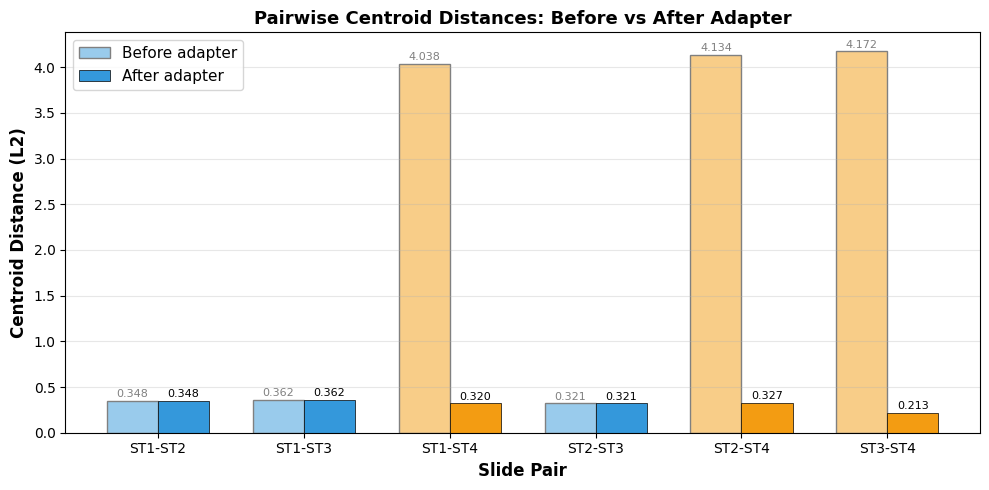


  KEY: Blue = within-ST pairs (should be stable), Orange = ST4-to-ST pairs (should shrink)


In [27]:
# ===================================================================
# CELL 2: Centroid Distance Analysis (Before vs After Adapter)
# ===================================================================
import matplotlib.pyplot as plt

print("=" * 70)
print("ANALYSIS 2: Centroid Distance Analysis (Before vs After Adapter)")
print("=" * 70)

def get_per_slide_embeddings(z_all, labels, names):
    """Split combined embeddings by slide."""
    return {name: z_all[labels == i] for i, name in enumerate(names)}

def compute_centroid_matrix(embs, names):
    """Compute pairwise centroid distance matrix."""
    centroids = {n: embs[n].mean(dim=0) for n in names}
    n = len(names)
    D = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            D[i, j] = (centroids[names[i]] - centroids[names[j]]).norm().item()
    return D, centroids

embs_before = get_per_slide_embeddings(z_all_before, labels_4class, slide_names_4)
embs_after  = get_per_slide_embeddings(z_all_after,  labels_4class, slide_names_4)

D_before, C_before = compute_centroid_matrix(embs_before, slide_names_4)
D_after,  C_after  = compute_centroid_matrix(embs_after,  slide_names_4)

# --- Print matrices ---
short = [n[-3:] for n in slide_names_4]
for label, D in [("BEFORE adapter", D_before), ("AFTER adapter", D_after)]:
    print(f"\n  {label}:")
    print(f"  {'':>6s}", "  ".join([f"{s:>8s}" for s in short]))
    for i, s1 in enumerate(short):
        row = f"  {s1:>6s}"
        for j in range(4):
            row += f"  {D[i,j]:8.4f}"
        print(row)

# --- Summary statistics ---
st_idx = [0, 1, 2]
within_st_before = np.mean([D_before[i,j] for i in st_idx for j in st_idx if i < j])
within_st_after  = np.mean([D_after[i,j]  for i in st_idx for j in st_idx if i < j])
st4_to_st_before = np.mean([D_before[3, i] for i in st_idx])
st4_to_st_after  = np.mean([D_after[3, i]  for i in st_idx])

print(f"\n  {'Metric':<35s} {'Before':>10s} {'After':>10s} {'Change':>10s}")
print("  " + "-" * 70)
print(f"  {'Mean within-ST dist (ST1-2-3)':<35s} {within_st_before:>10.4f} {within_st_after:>10.4f} {within_st_after-within_st_before:>+10.4f}")
print(f"  {'Mean ST4-to-ST dist':<35s} {st4_to_st_before:>10.4f} {st4_to_st_after:>10.4f} {st4_to_st_after-st4_to_st_before:>+10.4f}")
ratio_b = st4_to_st_before / max(within_st_before, 1e-8)
ratio_a = st4_to_st_after / max(within_st_after, 1e-8)
print(f"  {'Ratio (ST4-to-ST / within-ST)':<35s} {ratio_b:>10.2f}x {ratio_a:>10.2f}x")

# --- Bar chart ---
pair_labels, pair_before, pair_after, pair_is_st4 = [], [], [], []
for i in range(4):
    for j in range(i+1, 4):
        pair_labels.append(f"{short[i]}-{short[j]}")
        pair_before.append(D_before[i, j])
        pair_after.append(D_after[i, j])
        pair_is_st4.append(i == 3 or j == 3)

x = np.arange(len(pair_labels))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 5))
colors_before = ['#f39c1280' if is4 else '#3498db80' for is4 in pair_is_st4]
colors_after  = ['#f39c12' if is4 else '#3498db' for is4 in pair_is_st4]

bars1 = ax.bar(x - width/2, pair_before, width, label='Before adapter',
               color=colors_before, edgecolor='gray', linewidth=1)
bars2 = ax.bar(x + width/2, pair_after, width, label='After adapter',
               color=colors_after, edgecolor='black', linewidth=0.5)

ax.set_xlabel('Slide Pair', fontsize=12, fontweight='bold')
ax.set_ylabel('Centroid Distance (L2)', fontsize=12, fontweight='bold')
ax.set_title('Pairwise Centroid Distances: Before vs After Adapter', fontsize=13, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(pair_labels, fontsize=10)
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3)

for bar in bars1:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
            f'{bar.get_height():.3f}', ha='center', va='bottom', fontsize=8, color='gray')
for bar in bars2:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
            f'{bar.get_height():.3f}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

print(f"\n  KEY: Blue = within-ST pairs (should be stable), Orange = ST4-to-ST pairs (should shrink)")


# Cell 3: PCA Visualization (3-Panel)

ANALYSIS 3: PCA Visualization (Raw / Before / After Adapter)


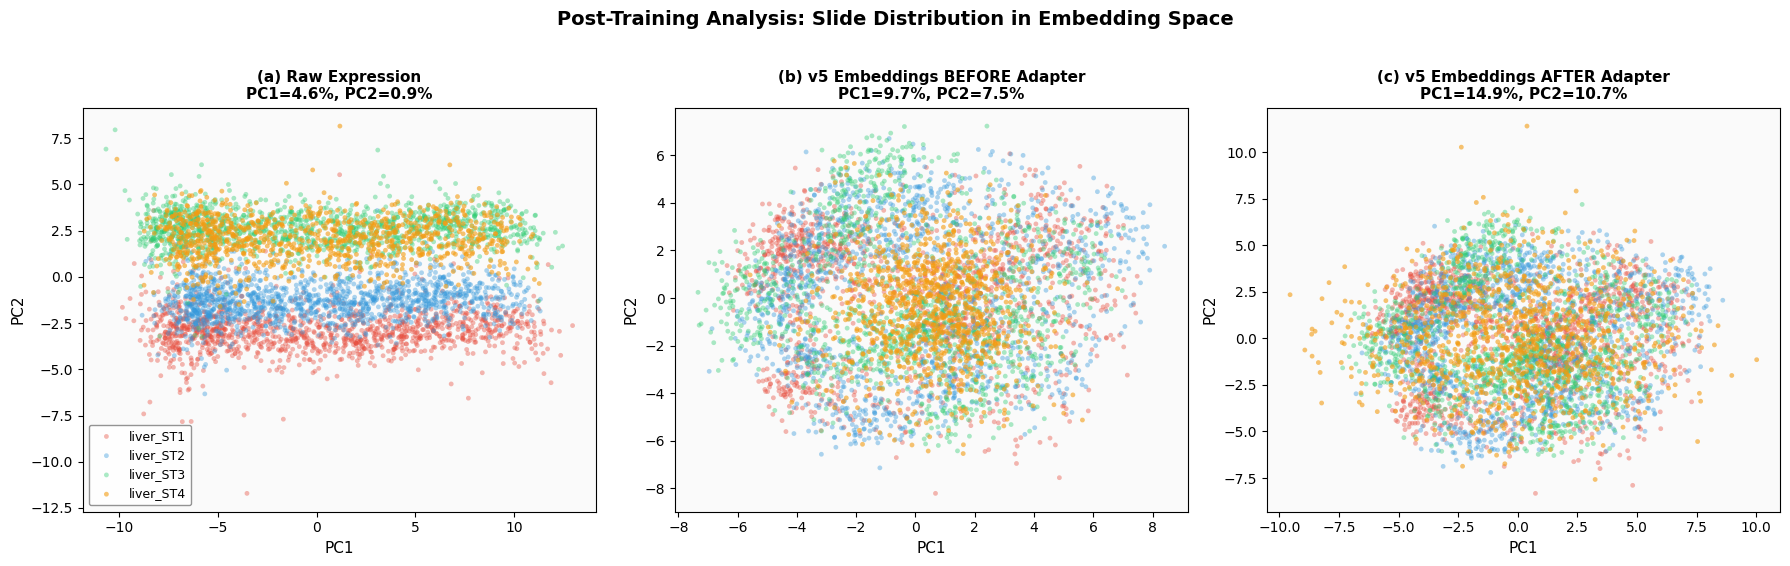

  Raw PCA             : ST4-to-ST centroid separation = 2.570, ST spread = 4.078, ratio = 0.63
  Before adapter      : ST4-to-ST centroid separation = 0.879, ST spread = 3.118, ratio = 0.28
  After adapter       : ST4-to-ST centroid separation = 0.157, ST spread = 3.122, ratio = 0.05


In [28]:
# ===================================================================
# CELL 3: PCA Visualization (Raw / Before / After Adapter)
# ===================================================================
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

print("=" * 70)
print("ANALYSIS 3: PCA Visualization (Raw / Before / After Adapter)")
print("=" * 70)

N_VIS = 3000
np.random.seed(42)

def subsample_per_slide(z_all, labels, n_max, n_slides):
    idx_all = []
    for i in range(n_slides):
        mask_idx = (labels == i).nonzero(as_tuple=True)[0]
        n_take = min(n_max, mask_idx.shape[0])
        perm = mask_idx[torch.randperm(mask_idx.shape[0])[:n_take]]
        idx_all.append(perm)
    idx = torch.cat(idx_all)
    return idx

# Use same subsampled indices for all three panels
idx_sub = subsample_per_slide(z_all_before, labels_4class, N_VIS, 4)
lab_sub = labels_4class[idx_sub].numpy()

raw_all = torch.cat([st_expr.cpu(), inf_expr.cpu()], dim=0)
raw_sub = raw_all[idx_sub].numpy()
bef_sub = z_all_before[idx_sub].numpy()
aft_sub = z_all_after[idx_sub].numpy()

pca_raw = PCA(n_components=2, random_state=42)
pca_bef = PCA(n_components=2, random_state=42)
pca_aft = PCA(n_components=2, random_state=42)

proj_raw = pca_raw.fit_transform(raw_sub)
proj_bef = pca_bef.fit_transform(bef_sub)
proj_aft = pca_aft.fit_transform(aft_sub)

var_raw = pca_raw.explained_variance_ratio_
var_bef = pca_bef.explained_variance_ratio_
var_aft = pca_aft.explained_variance_ratio_

fig, axes = plt.subplots(1, 3, figsize=(18, 5.5))

titles = [
    f"(a) Raw Expression\nPC1={var_raw[0]:.1%}, PC2={var_raw[1]:.1%}",
    f"(b) v5 Embeddings BEFORE Adapter\nPC1={var_bef[0]:.1%}, PC2={var_bef[1]:.1%}",
    f"(c) v5 Embeddings AFTER Adapter\nPC1={var_aft[0]:.1%}, PC2={var_aft[1]:.1%}",
]
projections = [proj_raw, proj_bef, proj_aft]

for ax, proj, title in zip(axes, projections, titles):
    # Plot ST1-3 first, ST4 on top for visibility
    for i in [0, 1, 2, 3]:
        mask = lab_sub == i
        name = slide_names_4[i]
        ax.scatter(proj[mask, 0], proj[mask, 1],
                   c=slide_colors[name], label=name,
                   s=12, alpha=0.4 if i < 3 else 0.6,
                   edgecolors='none',
                   zorder=2 if i < 3 else 3)
    ax.set_xlabel('PC1', fontsize=11)
    ax.set_ylabel('PC2', fontsize=11)
    ax.set_title(title, fontsize=11, fontweight='bold')
    ax.set_facecolor('#FAFAFA')

axes[0].legend(loc='best', fontsize=9, framealpha=0.9, edgecolor='#888888')
plt.suptitle('Post-Training Analysis: Slide Distribution in Embedding Space',
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Quick numerical check: how separated is ST4 in each space?
for name, proj in [('Raw PCA', proj_raw), ('Before adapter', proj_bef), ('After adapter', proj_aft)]:
    st_center = proj[lab_sub < 3].mean(axis=0)
    st4_center = proj[lab_sub == 3].mean(axis=0)
    sep = np.linalg.norm(st4_center - st_center)
    st_spread = np.std(proj[lab_sub < 3], axis=0).mean()
    print(f"  {name:20s}: ST4-to-ST centroid separation = {sep:.3f}, ST spread = {st_spread:.3f}, ratio = {sep/st_spread:.2f}")


# Cell 4: Collapse Check

ANALYSIS 4: Collapse Check (Embedding Health Diagnostics)

[4a] Per-dimension standard deviation:
  Set                       mean_std  min_std  max_std  dims<0.01  dims<0.001
  ---------------------------------------------------------------------------
  ST1-3 (encoded)             0.7633   0.5742   0.9766          0           0
  ST4 BEFORE adapter          1.1907   1.0247   1.3042          0           0
  ST4 AFTER adapter           0.7574   0.5548   0.9236          0           0

[4b] Effective dimensionality (PCA on 128-d embeddings):
  Set                        PCs@90%  PCs@95%   Partic. Ratio
  ------------------------------------------------------------
  ST1-3 (encoded)                 25       36            15.0
  ST4 BEFORE adapter              26       33            27.2
  ST4 AFTER adapter               25       36            17.1

[4c] Per-slide L2 norm statistics:
  Slide          Set                    mean      std      min      max
  ---------------------------------

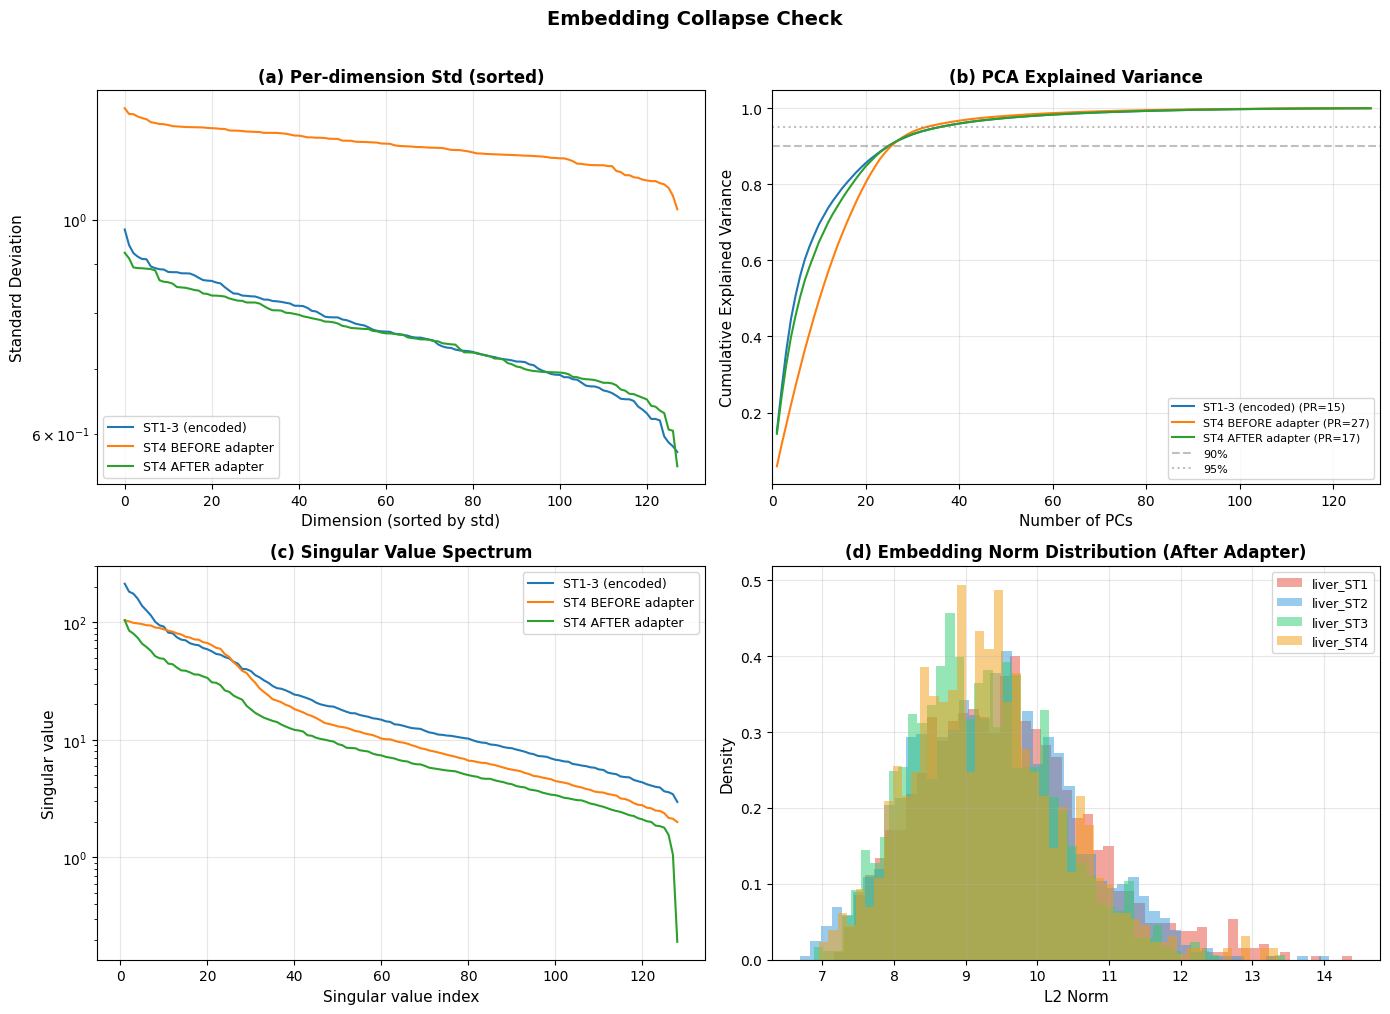

In [29]:
# ===================================================================
# CELL 4: Collapse Check (Embedding Health Diagnostics)
# ===================================================================
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

print("=" * 70)
print("ANALYSIS 4: Collapse Check (Embedding Health Diagnostics)")
print("=" * 70)

emb_sets = {
    'ST1-3 (encoded)':    z_st_raw,
    'ST4 BEFORE adapter': z_inf_raw,
    'ST4 AFTER adapter':  z_inf_adapted,
}

# --- 4a: Per-dimension std ---
print("\n[4a] Per-dimension standard deviation:")
print(f"  {'Set':<25s} {'mean_std':>8s} {'min_std':>8s} {'max_std':>8s} {'dims<0.01':>10s} {'dims<0.001':>11s}")
print("  " + "-" * 75)

for name, z in emb_sets.items():
    stds = z.std(dim=0)
    n_low = (stds < 0.01).sum().item()
    n_very_low = (stds < 0.001).sum().item()
    print(f"  {name:<25s} {stds.mean():>8.4f} {stds.min():>8.4f} {stds.max():>8.4f} {n_low:>10d} {n_very_low:>11d}")

# --- 4b: Effective dimensionality ---
print(f"\n[4b] Effective dimensionality (PCA on 128-d embeddings):")
print(f"  {'Set':<25s} {'PCs@90%':>8s} {'PCs@95%':>8s} {'Partic. Ratio':>15s}")
print("  " + "-" * 60)

pca_results = {}
for name, z in emb_sets.items():
    n_comp = min(128, z.shape[0] - 1)
    pca = PCA(n_components=n_comp, random_state=42)
    pca.fit(z.numpy())
    ev = pca.explained_variance_ratio_
    cumvar = np.cumsum(ev)
    n90 = int(np.searchsorted(cumvar, 0.90)) + 1
    n95 = int(np.searchsorted(cumvar, 0.95)) + 1
    pr = float((ev.sum())**2 / (ev**2).sum())  # participation ratio
    pca_results[name] = (ev, cumvar, n90, n95, pr)
    print(f"  {name:<25s} {n90:>8d} {n95:>8d} {pr:>15.1f}")

# --- 4c: Per-slide norm statistics ---
print(f"\n[4c] Per-slide L2 norm statistics:")
print(f"  {'Slide':<14s} {'Set':<18s} {'mean':>8s} {'std':>8s} {'min':>8s} {'max':>8s}")
print("  " + "-" * 65)

for i, name in enumerate(slide_names_4):
    mask = labels_4class == i
    for set_label, z_all in [('BEFORE adapter', z_all_before), ('AFTER adapter', z_all_after)]:
        z_slide = z_all[mask]
        norms = z_slide.norm(dim=1)
        print(f"  {name[-3:]:<14s} {set_label:<18s} {norms.mean():>8.3f} {norms.std():>8.3f} "
              f"{norms.min():>8.3f} {norms.max():>8.3f}")

# --- 4d: Visualization ---
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# (a) Per-dim std (sorted, log scale)
ax = axes[0, 0]
for name, z in emb_sets.items():
    stds = z.std(dim=0).numpy()
    ax.plot(sorted(stds, reverse=True), label=name, linewidth=1.5)
ax.set_xlabel('Dimension (sorted by std)', fontsize=11)
ax.set_ylabel('Standard Deviation', fontsize=11)
ax.set_title('(a) Per-dimension Std (sorted)', fontweight='bold')
ax.legend(fontsize=9)
ax.set_yscale('log')
ax.grid(alpha=0.3)

# (b) PCA cumulative variance
ax = axes[0, 1]
for name, (ev, cumvar, n90, n95, pr) in pca_results.items():
    ax.plot(range(1, len(cumvar)+1), cumvar, label=f"{name} (PR={pr:.0f})", linewidth=1.5)
ax.axhline(y=0.90, color='gray', linestyle='--', alpha=0.5, label='90%')
ax.axhline(y=0.95, color='gray', linestyle=':', alpha=0.5, label='95%')
ax.set_xlabel('Number of PCs', fontsize=11)
ax.set_ylabel('Cumulative Explained Variance', fontsize=11)
ax.set_title('(b) PCA Explained Variance', fontweight='bold')
ax.legend(fontsize=8)
ax.set_xlim(0, 130)
ax.grid(alpha=0.3)

# (c) Singular value spectrum
ax = axes[1, 0]
for name, z in emb_sets.items():
    z_centered = z - z.mean(dim=0, keepdim=True)
    S = torch.linalg.svdvals(z_centered.float())
    ax.plot(range(1, len(S)+1), S.numpy(), label=name, linewidth=1.5)
ax.set_xlabel('Singular value index', fontsize=11)
ax.set_ylabel('Singular value', fontsize=11)
ax.set_title('(c) Singular Value Spectrum', fontweight='bold')
ax.legend(fontsize=9)
ax.set_yscale('log')
ax.grid(alpha=0.3)

# (d) Norm distributions (after adapter)
ax = axes[1, 1]
for i, name in enumerate(slide_names_4):
    mask = (labels_4class == i).numpy()
    norms_after = z_all_after[labels_4class == i].norm(dim=1).numpy()
    ax.hist(norms_after, bins=50, alpha=0.5, label=name,
            color=slide_colors[name], density=True)
ax.set_xlabel('L2 Norm', fontsize=11)
ax.set_ylabel('Density', fontsize=11)
ax.set_title('(d) Embedding Norm Distribution (After Adapter)', fontweight='bold')
ax.legend(fontsize=9)
ax.grid(alpha=0.3)

plt.suptitle('Embedding Collapse Check', fontsize=14, fontweight='bold', y=1.01)
plt.tight_layout()
plt.show()


# Cell 5: Domain Alignment Metrics

In [30]:
# ===================================================================
# CELL 5: Domain Alignment Metrics (Before vs After Adapter)
# ===================================================================
from adapter_topology_eval import compute_domain_metrics, compute_domain_classifier_acc

print("=" * 70)
print("ANALYSIS 5: Domain Alignment Metrics (Before vs After Adapter)")
print("=" * 70)

z_st_dev = z_st_raw.to(device)
z_inf_before_dev = z_inf_raw.to(device)
z_inf_after_dev = z_inf_adapted.to(device)

metrics_before = compute_domain_metrics(z_st_dev, z_inf_before_dev)
metrics_after  = compute_domain_metrics(z_st_dev, z_inf_after_dev)

domain_acc_before = compute_domain_classifier_acc(z_st_dev, z_inf_before_dev)
domain_acc_after  = compute_domain_classifier_acc(z_st_dev, z_inf_after_dev)

print(f"\n  {'Metric':<30s} {'BEFORE':>12s} {'AFTER':>12s} {'Change':>12s}")
print("  " + "-" * 70)
for key in ['centroid_dist', 'coral', 'mmd', 'norm_gap_pct', 'norm_st_mean', 'norm_sc_mean']:
    b, a = metrics_before[key], metrics_after[key]
    if key == 'norm_gap_pct':
        print(f"  {key:<30s} {b:>11.1f}% {a:>11.1f}% {a-b:>+11.1f}%")
    else:
        print(f"  {key:<30s} {b:>12.4f} {a:>12.4f} {a-b:>+12.4f}")

print(f"  {'domain_classifier_acc':<30s} {domain_acc_before:>12.4f} {domain_acc_after:>12.4f} {domain_acc_after-domain_acc_before:>+12.4f}")
print(f"  {'(chance = 0.5000)':<30s}")

print(f"\n  INTERPRETATION:")
if domain_acc_after < 0.55:
    print(f"    Domain classifier at {domain_acc_after:.3f} -- near chance. Excellent alignment.")
elif domain_acc_after < 0.65:
    print(f"    Domain classifier at {domain_acc_after:.3f} -- good alignment, some residual signal.")
else:
    print(f"    Domain classifier at {domain_acc_after:.3f} -- domain gap remains significant.")

coral_reduction = (1 - metrics_after['coral'] / max(metrics_before['coral'], 1e-8)) * 100
print(f"    CORAL: {metrics_before['coral']:.4f} -> {metrics_after['coral']:.4f} ({coral_reduction:.1f}% reduction)")
print(f"    MMD:   {metrics_before['mmd']:.6f} -> {metrics_after['mmd']:.6f}")
print(f"    Norm gap: {metrics_before['norm_gap_pct']:.1f}% -> {metrics_after['norm_gap_pct']:.1f}%")


ANALYSIS 5: Domain Alignment Metrics (Before vs After Adapter)

  Metric                               BEFORE        AFTER       Change
  ----------------------------------------------------------------------
  centroid_dist                        4.1111       0.2135      -3.8976
  coral                                0.1868       0.0011      -0.1857
  mmd                                  0.0590       0.0013      -0.0578
  norm_gap_pct                          49.5%         0.9%       -48.6%
  norm_st_mean                         9.3950       9.3950      +0.0000
  norm_sc_mean                        14.0445       9.3096      -4.7349
  domain_classifier_acc                0.9858       0.4418      -0.5441
  (chance = 0.5000)             

  INTERPRETATION:
    Domain classifier at 0.442 -- near chance. Excellent alignment.
    CORAL: 0.1868 -> 0.0011 (99.4% reduction)
    MMD:   0.059035 -> 0.001267
    Norm gap: 49.5% -> 0.9%


# Cell 6: Per-Slide CORAL/MMD Breakdown

In [31]:
# ===================================================================
# CELL 6: Per-Slide CORAL/MMD vs ST4 (Before vs After Adapter)
# ===================================================================
from ssl_utils import coral_loss, mmd_rbf_loss

print("=" * 70)
print("ANALYSIS 6: Per-Slide CORAL/MMD vs ST4 (Before vs After Adapter)")
print("=" * 70)

embs_bef = get_per_slide_embeddings(z_all_before, labels_4class, slide_names_4)
embs_aft = get_per_slide_embeddings(z_all_after,  labels_4class, slide_names_4)

print(f"\n  ST-to-ST4 pairs (should improve after adapter):")
print(f"  {'Pair':<12s} {'CORAL_bef':>10s} {'CORAL_aft':>10s} {'MMD_bef':>10s} {'MMD_aft':>10s} {'Cent_bef':>10s} {'Cent_aft':>10s}")
print("  " + "-" * 75)

for st_name in slide_names_4[:3]:
    z_s = embs_bef[st_name].to(device)
    z_inf_b = embs_bef['liver_ST4'].to(device)
    z_inf_a = embs_aft['liver_ST4'].to(device)

    c_before = coral_loss(z_s, z_inf_b).item()
    c_after  = coral_loss(z_s, z_inf_a).item()

    n_sub = min(1000, z_s.shape[0], z_inf_b.shape[0])
    m_before = mmd_rbf_loss(z_s[:n_sub], z_inf_b[:n_sub]).item()
    m_after  = mmd_rbf_loss(z_s[:n_sub], z_inf_a[:n_sub]).item()

    cent_b = (z_s.mean(0) - z_inf_b.mean(0)).norm().item()
    cent_a = (z_s.mean(0) - z_inf_a.mean(0)).norm().item()

    pair = f"{st_name[-3:]}-ST4"
    print(f"  {pair:<12s} {c_before:>10.4f} {c_after:>10.4f} {m_before:>10.6f} {m_after:>10.6f} {cent_b:>10.4f} {cent_a:>10.4f}")

# Within-ST pairs (stability reference)
print(f"\n  Within-ST pairs (should be stable, no adapter effect):")
print(f"  {'Pair':<12s} {'CORAL':>10s} {'MMD':>10s} {'Centroid':>10s}")
print("  " + "-" * 45)

for i in range(3):
    for j in range(i+1, 3):
        z_i = embs_bef[slide_names_4[i]].to(device)
        z_j = embs_bef[slide_names_4[j]].to(device)
        c = coral_loss(z_i, z_j).item()
        n_sub = min(1000, z_i.shape[0], z_j.shape[0])
        m = mmd_rbf_loss(z_i[:n_sub], z_j[:n_sub]).item()
        cent = (z_i.mean(0) - z_j.mean(0)).norm().item()
        pair = f"{slide_names_4[i][-3:]}-{slide_names_4[j][-3:]}"
        print(f"  {pair:<12s} {c:>10.4f} {m:>10.6f} {cent:>10.4f}")


ANALYSIS 6: Per-Slide CORAL/MMD vs ST4 (Before vs After Adapter)

  ST-to-ST4 pairs (should improve after adapter):
  Pair          CORAL_bef  CORAL_aft    MMD_bef    MMD_aft   Cent_bef   Cent_aft
  ---------------------------------------------------------------------------
  ST1-ST4          0.1851     0.0046   0.055310   0.002514     4.0384     0.3202
  ST2-ST4          0.1926     0.0057   0.059757   0.002404     4.1345     0.3267
  ST3-ST4          0.1938     0.0041   0.062657   0.002324     4.1718     0.2129

  Within-ST pairs (should be stable, no adapter effect):
  Pair              CORAL        MMD   Centroid
  ---------------------------------------------
  ST1-ST2          0.0118   0.004514     0.3483
  ST1-ST3          0.0097   0.004136     0.3619
  ST2-ST3          0.0124   0.004510     0.3214


# Cell 7: Summary Dashboard

In [32]:
# ===================================================================
# CELL 7: Summary Dashboard
# ===================================================================

print("=" * 70)
print("POST-TRAINING ANALYSIS SUMMARY")
print("=" * 70)

print(f"\n  {'Metric':<45s} {'Before':>12s} {'After':>12s}")
print("  " + "-" * 72)
print(f"  {'4-class slide accuracy (chance=0.25)':<45s} {scores_before.mean():>12.4f} {scores_after.mean():>12.4f}")
print(f"  {'3-class ST-only accuracy (chance=0.33)':<45s} {scores_st_only.mean():>12.4f} {'(same)':>12s}")
print(f"  {'Domain classifier acc (chance=0.50)':<45s} {domain_acc_before:>12.4f} {domain_acc_after:>12.4f}")
print(f"  {'CORAL loss (ST vs ST4)':<45s} {metrics_before['coral']:>12.4f} {metrics_after['coral']:>12.4f}")
print(f"  {'MMD loss (ST vs ST4)':<45s} {metrics_before['mmd']:>12.6f} {metrics_after['mmd']:>12.6f}")
print(f"  {'Mean ST4-to-ST centroid dist':<45s} {st4_to_st_before:>12.4f} {st4_to_st_after:>12.4f}")
print(f"  {'Mean within-ST centroid dist (stable?)':<45s} {within_st_before:>12.4f} {within_st_after:>12.4f}")
print(f"  {'Norm gap % (ST vs ST4)':<45s} {metrics_before['norm_gap_pct']:>11.1f}% {metrics_after['norm_gap_pct']:>11.1f}%")

# Collapse summary
print(f"\n  Collapse check:")
for name, z in emb_sets.items():
    stds = z.std(dim=0)
    ev, cumvar, n90, n95, pr = pca_results[name]
    print(f"    {name:<25s} min_std={stds.min():.4f}  PR={pr:.0f}  PCs@95%={n95}")

# Pass/fail verdict
print(f"\n  VERDICT:")
checks = []

if scores_after.mean() < 0.40:
    checks.append(("4-class accuracy < 0.40", True, f"{scores_after.mean():.3f}"))
else:
    checks.append(("4-class accuracy < 0.40", False, f"{scores_after.mean():.3f}"))

if domain_acc_after < 0.60:
    checks.append(("Domain classifier < 0.60", True, f"{domain_acc_after:.3f}"))
else:
    checks.append(("Domain classifier < 0.60", False, f"{domain_acc_after:.3f}"))

if metrics_after['coral'] < 0.01:
    checks.append(("CORAL < 0.01", True, f"{metrics_after['coral']:.4f}"))
else:
    checks.append(("CORAL < 0.01", False, f"{metrics_after['coral']:.4f}"))

min_std_all = min(z.std(dim=0).min().item() for z in emb_sets.values())
if min_std_all > 0.001:
    checks.append(("No dimension collapse (min std > 0.001)", True, f"{min_std_all:.4f}"))
else:
    checks.append(("No dimension collapse (min std > 0.001)", False, f"{min_std_all:.4f}"))

if within_st_after / max(within_st_before, 1e-8) > 0.8:
    checks.append(("Within-ST distances stable (>80%)", True,
                    f"{within_st_after/within_st_before*100:.0f}%"))
else:
    checks.append(("Within-ST distances stable (>80%)", False,
                    f"{within_st_after/within_st_before*100:.0f}%"))

for desc, passed, val in checks:
    symbol = "[+]" if passed else "[-]"
    status = "PASS" if passed else "FAIL"
    print(f"    {symbol} {desc}: {status} ({val})")

n_pass = sum(1 for _, p, _ in checks if p)
print(f"\n    {n_pass}/{len(checks)} checks passed.")
print("=" * 70)


POST-TRAINING ANALYSIS SUMMARY

  Metric                                              Before        After
  ------------------------------------------------------------------------
  4-class slide accuracy (chance=0.25)                0.5376       0.2881
  3-class ST-only accuracy (chance=0.33)              0.3988       (same)
  Domain classifier acc (chance=0.50)                 0.9858       0.4418
  CORAL loss (ST vs ST4)                              0.1868       0.0011
  MMD loss (ST vs ST4)                              0.059035     0.001267
  Mean ST4-to-ST centroid dist                        4.1149       0.2866
  Mean within-ST centroid dist (stable?)              0.3439       0.3439
  Norm gap % (ST vs ST4)                               49.5%         0.9%

  Collapse check:
    ST1-3 (encoded)           min_std=0.5742  PR=15  PCs@95%=36
    ST4 BEFORE adapter        min_std=1.0247  PR=27  PCs@95%=33
    ST4 AFTER adapter         min_std=0.5548  PR=17  PCs@95%=36

  VERDICT:
    

# Cell 8: t-SNE Visualization (3-Panel)

ANALYSIS 8: t-SNE Visualization (Raw / Before / After Adapter)
  Running t-SNE on 4983 spots (2000/slide)...
    (a) Raw expression done
    (b) Before adapter done
    (c) After adapter done


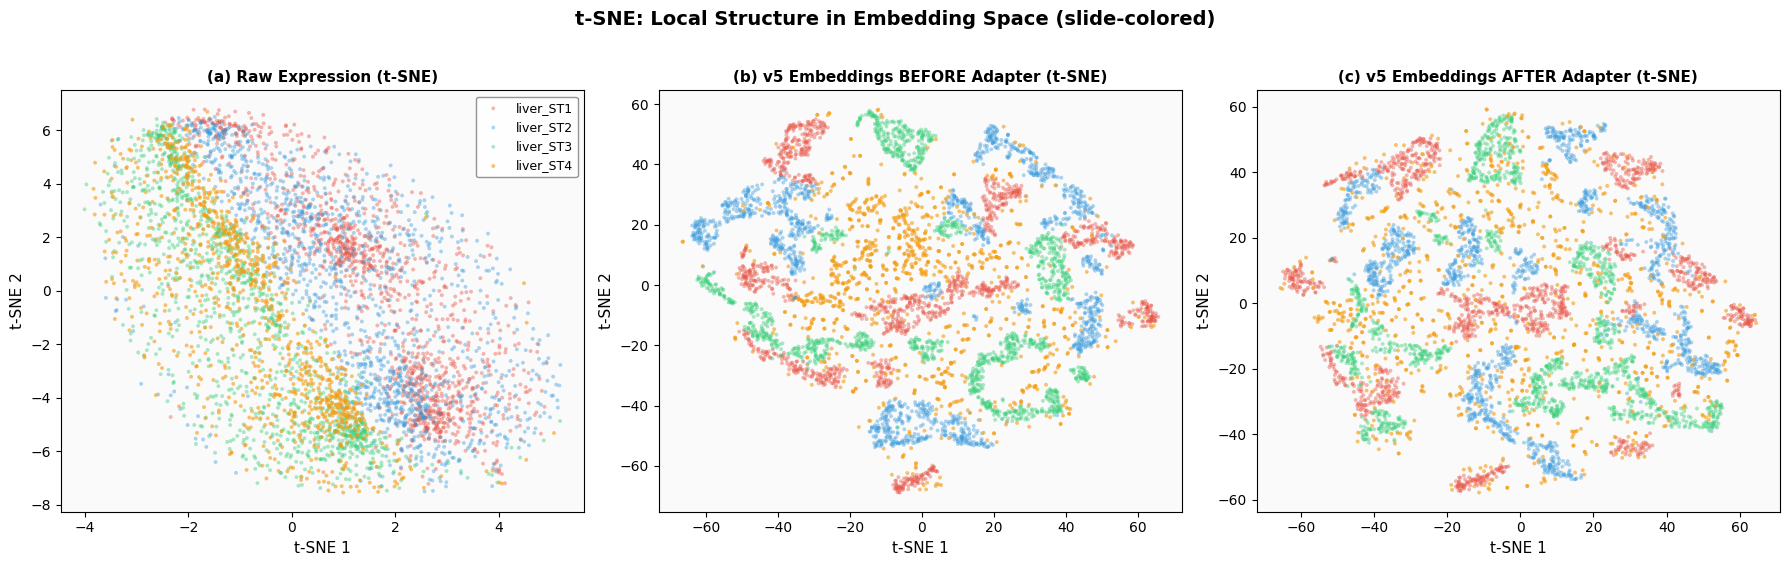


  NOTE: In panel (c), look for mixed-color clusters — these are
  biological neighborhoods where all 4 slides contribute, confirming
  the adapter aligned domains without collapsing biological structure.


In [33]:
# ===================================================================
# CELL 8: t-SNE Visualization (Raw / Before / After Adapter)
# ===================================================================
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

print("=" * 70)
print("ANALYSIS 8: t-SNE Visualization (Raw / Before / After Adapter)")
print("=" * 70)

N_VIS = 2000  # smaller than PCA — t-SNE is O(n²)
np.random.seed(42)

# Subsample (same logic as Cell 3 but fresh indices for smaller N)
def subsample_per_slide_np(n_total, labels, n_max, n_slides):
    idx_all = []
    for i in range(n_slides):
        mask_idx = np.where(labels == i)[0]
        n_take = min(n_max, len(mask_idx))
        perm = np.random.choice(mask_idx, size=n_take, replace=False)
        idx_all.append(perm)
    return np.concatenate(idx_all)

labs_all = labels_4class.numpy()
idx_sub = subsample_per_slide_np(len(labs_all), labs_all, N_VIS, 4)
lab_sub = labs_all[idx_sub]

raw_all = torch.cat([st_expr.cpu(), inf_expr.cpu()], dim=0).numpy()
raw_sub = raw_all[idx_sub]
bef_sub = z_all_before[idx_sub].numpy()
aft_sub = z_all_after[idx_sub].numpy()

print(f"  Running t-SNE on {len(idx_sub)} spots ({N_VIS}/slide)...")

tsne_raw = TSNE(n_components=2, perplexity=30, random_state=42, n_iter=1000,
                init='pca', learning_rate='auto').fit_transform(raw_sub)
print("    (a) Raw expression done")

tsne_bef = TSNE(n_components=2, perplexity=30, random_state=42, n_iter=1000,
                init='pca', learning_rate='auto').fit_transform(bef_sub)
print("    (b) Before adapter done")

tsne_aft = TSNE(n_components=2, perplexity=30, random_state=42, n_iter=1000,
                init='pca', learning_rate='auto').fit_transform(aft_sub)
print("    (c) After adapter done")

fig, axes = plt.subplots(1, 3, figsize=(18, 5.5))

titles = [
    "(a) Raw Expression (t-SNE)",
    "(b) v5 Embeddings BEFORE Adapter (t-SNE)",
    "(c) v5 Embeddings AFTER Adapter (t-SNE)",
]
projections = [tsne_raw, tsne_bef, tsne_aft]

for ax, proj, title in zip(axes, projections, titles):
    for i in [0, 1, 2, 3]:
        mask = lab_sub == i
        name = slide_names_4[i]
        ax.scatter(proj[mask, 0], proj[mask, 1],
                   c=slide_colors[name], label=name,
                   s=8, alpha=0.4 if i < 3 else 0.6,
                   edgecolors='none',
                   zorder=2 if i < 3 else 3)
    ax.set_xlabel('t-SNE 1', fontsize=11)
    ax.set_ylabel('t-SNE 2', fontsize=11)
    ax.set_title(title, fontsize=11, fontweight='bold')
    ax.set_facecolor('#FAFAFA')

axes[0].legend(loc='best', fontsize=9, framealpha=0.9, edgecolor='#888888')
plt.suptitle('t-SNE: Local Structure in Embedding Space (slide-colored)',
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("\n  NOTE: In panel (c), look for mixed-color clusters — these are")
print("  biological neighborhoods where all 4 slides contribute, confirming")
print("  the adapter aligned domains without collapsing biological structure.")


# Cell 9: ST4 Spatial Overlap@20 (Before vs After Adapter)

In [34]:
# ===================================================================
# CELL 9: ST4 Spatial Overlap@20 (Before vs After Adapter)
# ===================================================================
from scipy.spatial import cKDTree
import numpy as np

print("=" * 70)
print("ANALYSIS 9: Spatial Overlap@20 — All Slides (Before vs After)")
print("=" * 70)

K_EVAL = 20

def compute_spatial_overlap(emb_np, coords_np, k=20):
    """Compute embedding-kNN vs physical-kNN overlap."""
    tree_emb = cKDTree(emb_np)
    tree_phys = cKDTree(coords_np)
    _, emb_idx = tree_emb.query(emb_np, k=k+1)
    emb_idx = emb_idx[:, 1:]  # exclude self
    _, phys_idx = tree_phys.query(coords_np, k=k+1)
    phys_idx = phys_idx[:, 1:]

    overlaps = []
    phys_dists = []
    for i in range(len(emb_np)):
        emb_set = set(emb_idx[i])
        phys_set = set(phys_idx[i])
        overlaps.append(len(emb_set & phys_set) / k)
        # median physical distance of embedding kNN
        phys_dists.append(np.median(np.linalg.norm(
            coords_np[emb_idx[i]] - coords_np[i], axis=1)))

    return np.mean(overlaps), np.median(phys_dists)

# --- ST1-3 (reference baseline, embeddings unchanged by adapter) ---
print(f"\n  ST1-3 training slides (embeddings unchanged by adapter):")
print(f"  {'Slide':<14s} {'Overlap@20':>12s} {'Med. Phys Dist':>15s}")
print("  " + "-" * 45)

slide_keys_st = list(ST_PATHS.keys())
labels_np = slide_ids.cpu().numpy()

for s, skey in enumerate(slide_keys_st):
    m = labels_np == s
    z_s = z_st_raw[m].numpy()
    coords_s = st_data[skey].obsm['spatial']
    ov, dist = compute_spatial_overlap(z_s, coords_s, k=K_EVAL)
    print(f"  {skey:<14s} {ov:>12.3f} {dist:>15.1f}")

# --- ST4 BEFORE adapter ---
print(f"\n  ST4 (inference slide):")
print(f"  {'Condition':<25s} {'Overlap@20':>12s} {'Med. Phys Dist':>15s}")
print("  " + "-" * 55)

coords_st4 = inf_data['liver_ST4'].obsm['spatial']

ov_before, dist_before = compute_spatial_overlap(
    z_inf_raw.numpy(), coords_st4, k=K_EVAL)
print(f"  {'BEFORE adapter':<25s} {ov_before:>12.3f} {dist_before:>15.1f}")

ov_after, dist_after = compute_spatial_overlap(
    z_inf_adapted.numpy(), coords_st4, k=K_EVAL)
print(f"  {'AFTER adapter':<25s} {ov_after:>12.3f} {dist_after:>15.1f}")

ov_change = ov_after - ov_before
print(f"  {'Change':<25s} {ov_change:>+12.3f} {dist_after - dist_before:>+15.1f}")

# --- Also check: raw expression overlap (how much spatial signal is in the input?) ---
ov_raw, dist_raw = compute_spatial_overlap(
    inf_expr.cpu().numpy(), coords_st4, k=K_EVAL)
print(f"\n  {'Raw expression (baseline)':<25s} {ov_raw:>12.3f} {dist_raw:>15.1f}")

# --- Interpretation ---
print(f"\n  INTERPRETATION:")
if abs(ov_change) < 0.03:
    print(f"    EXCELLENT: Overlap change = {ov_change:+.3f} (within noise).")
    print(f"    Adapter preserved ST4's internal spatial structure perfectly.")
elif ov_change > -0.05:
    print(f"    GOOD: Overlap change = {ov_change:+.3f} (minor perturbation).")
    print(f"    Adapter mostly preserved ST4's spatial structure.")
else:
    print(f"    WARNING: Overlap change = {ov_change:+.3f} (significant degradation).")
    print(f"    Adapter may be distorting ST4's internal embedding topology.")


ANALYSIS 9: Spatial Overlap@20 — All Slides (Before vs After)

  ST1-3 training slides (embeddings unchanged by adapter):
  Slide            Overlap@20  Med. Phys Dist
  ---------------------------------------------
  liver_ST1             0.673            66.4
  liver_ST2             0.666            66.0
  liver_ST3             0.678            65.9

  ST4 (inference slide):
  Condition                   Overlap@20  Med. Phys Dist
  -------------------------------------------------------
  BEFORE adapter                   0.029           547.6
  AFTER adapter                    0.028           553.0
  Change                          -0.001            +5.4

  Raw expression (baseline)        0.024           614.4

  INTERPRETATION:
    EXCELLENT: Overlap change = -0.001 (within noise).
    Adapter preserved ST4's internal spatial structure perfectly.


# cell 10 do the t-SNE islands correspond to shared cell types across slides

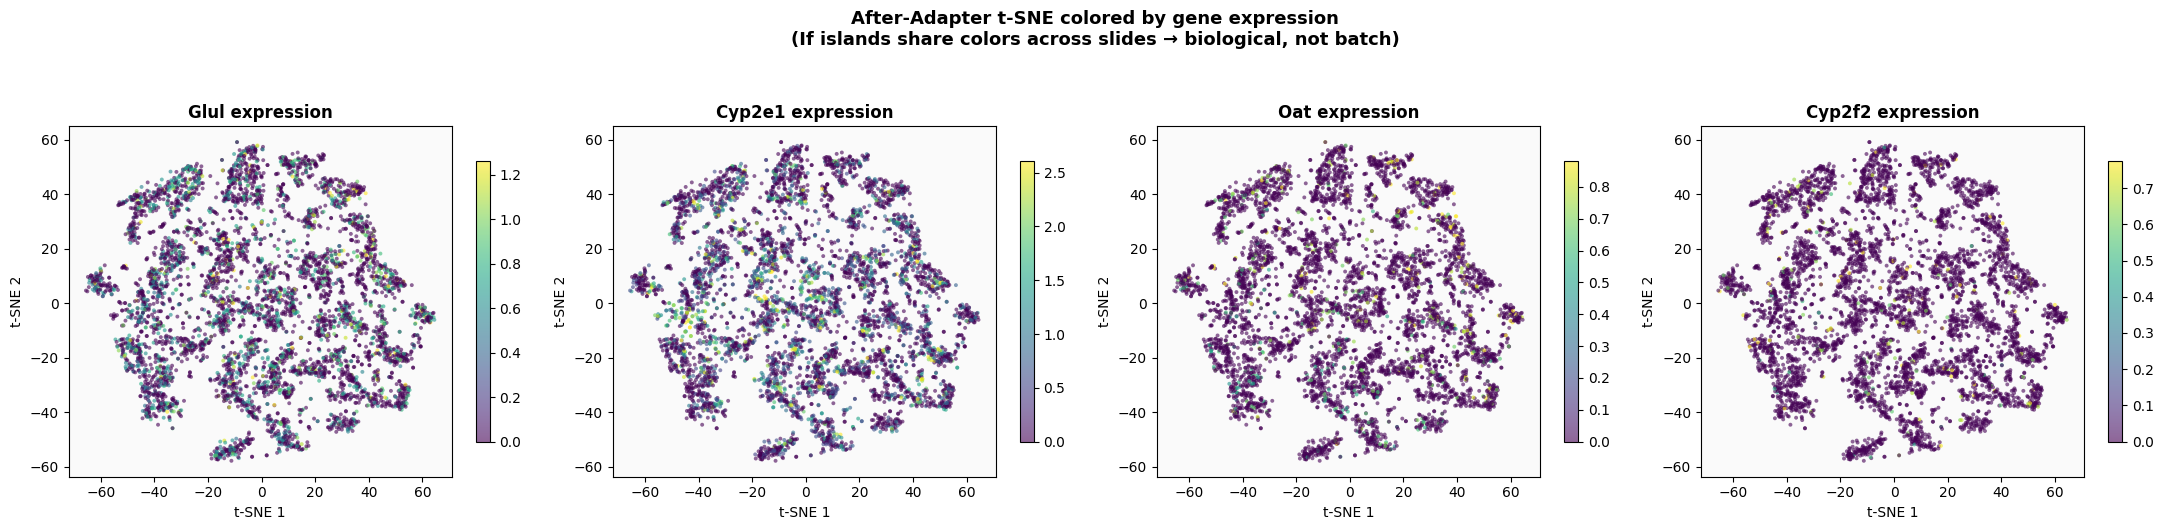


  If islands of DIFFERENT slides light up for the SAME gene →
  the encoder learned biology, not just slide identity.
  If each slide's islands have unique patterns → residual batch.


In [35]:
# ===================================================================
# CELL 10: t-SNE colored by zonation marker (biology check)
# ===================================================================
# Re-use tsne_aft from Cell 8 — color by a hepatocyte zonation gene
# instead of slide ID to see if islands = biological zones
import matplotlib.pyplot as plt
import numpy as np

# Pick a known pericentral marker (Glul/Glu1) and periportal marker (Cyp2f2/Sds)
# Adjust gene names to what's in your var_names
raw_sub_arr = raw_all[idx_sub]  # from Cell 8

# Get gene indices — try common liver zonation markers
var_names = list(st_data[list(ST_PATHS.keys())[0]].var_names)
markers = {}
for gene in ['Glul', 'Cyp2e1', 'Oat', 'Cyp2f2', 'Sds', 'Hal', 'Alb']:
    if gene in var_names:
        markers[gene] = var_names.index(gene)

if len(markers) == 0:
    print("No standard liver markers found in var_names. Available genes (first 20):")
    print(var_names[:20])
else:
    n_markers = min(len(markers), 4)
    fig, axes = plt.subplots(1, n_markers, figsize=(5.5 * n_markers, 5))
    if n_markers == 1:
        axes = [axes]

    for ax, (gene, gidx) in zip(axes, list(markers.items())[:n_markers]):
        expr_vals = raw_sub_arr[:, gidx]
        # Clip to 1st-99th percentile for visualization
        vmin, vmax = np.percentile(expr_vals, [1, 99])
        sc = ax.scatter(tsne_aft[:, 0], tsne_aft[:, 1],
                        c=expr_vals, cmap='viridis', s=8, alpha=0.6,
                        vmin=vmin, vmax=vmax, edgecolors='none')
        ax.set_title(f'{gene} expression', fontsize=12, fontweight='bold')
        ax.set_xlabel('t-SNE 1'); ax.set_ylabel('t-SNE 2')
        ax.set_facecolor('#FAFAFA')
        plt.colorbar(sc, ax=ax, shrink=0.8)

    plt.suptitle('After-Adapter t-SNE colored by gene expression\n'
                 '(If islands share colors across slides → biological, not batch)',
                 fontsize=13, fontweight='bold', y=1.05)
    plt.tight_layout()
    plt.show()

    print("\n  If islands of DIFFERENT slides light up for the SAME gene →")
    print("  the encoder learned biology, not just slide identity.")
    print("  If each slide's islands have unique patterns → residual batch.")


# V3 re-verification training (exact original v3 config, raw input)

In [20]:
import os
outdir_v3_verify = 'gems_liver_crossslide_v3_verify'
os.makedirs(outdir_v3_verify, exist_ok=True)

encoder_v3v = SharedEncoder(n_genes=n_genes, n_embedding=[512, 256, 128], dropout=0.1)

encoder_v3v, projector_v3v, discriminator_v3v, hist_v3v = train_encoder(
    model=encoder_v3v,
    st_gene_expr=st_expr,             # ← RAW input (no mean centering)
    st_coords=st_coords,
    sc_gene_expr=inf_expr,
    slide_ids=slide_ids,
    sc_slide_ids=inf_slide_ids,
    sc_patient_ids=inf_patient_ids,
    st_source_ids=st_source_ids,
    sc_source_ids=inf_source_ids,
    use_source_adversary=False,
    n_epochs=1200,
    batch_size=256,
    lr=1e-4,                          # v3: 1e-4 NOT 1e-3
    device=device,
    outf=outdir_v3_verify,
    stageA_obj='vicreg_adv',
    # ---- VICReg (exact v3) ----
    vicreg_lambda_inv=25.0,
    vicreg_lambda_var=50.0,           # v3: 50.0 NOT 25.0
    vicreg_lambda_cov=1.0,
    vicreg_inv_warmup_frac=0.3,       # v3: 0.3 NOT 0.0
    vicreg_inv_start=5.0,
    vicreg_gamma=1.0,
    vicreg_eps=1e-4,
    vicreg_project_dim=256,
    vicreg_use_projector=False,       # v3: False NOT True
    vicreg_float32_stats=True,
    vicreg_ddp_gather=False,
    # ---- Augmentations (exact v3) ----
    aug_gene_dropout=0.25,            # v3: 0.25 NOT 0.2
    aug_gauss_std=0.01,
    aug_scale_jitter=0.1,             # v3: 0.1 NOT 0.2
    # ---- ALL alignment OFF ----
    adv_slide_weight=0.0,
    source_coral_weight=0.0,
    patient_coral_weight=0.0,
    mmd_weight=0.0,
    mmd_use_l2norm=True,
    mmd_ramp=True,
    coral_raw_weight=0.0,
    knn_weight=0.0,
    use_local_align=False,
    local_align_weight=0.0,
    centroid_weight=0.0,
    # ---- Adversary (off but configure) ----
    adv_warmup_epochs=50,
    adv_ramp_epochs=200,
    grl_alpha_max=1.0,
    disc_hidden=512,                  # v3: 512
    disc_dropout=0.1,
    stageA_balanced_slides=True,
    adv_representation_mode='clean',
    adv_use_layernorm=False,
    adv_log_diagnostics=False,
    adv_log_grad_norms=False,
    inference_dropout_prob=0.0,
    # ---- Spatial NCE ----
    spatial_nce_weight=5.0,
    spatial_nce_k_phys=20,
    spatial_nce_far_mult=4.0,
    spatial_nce_n_hard=20,
    spatial_nce_tau=0.1,
    spatial_nce_n_rand_neg=128,
    spatial_nce_n_anchors=64,
    # ---- NO Phase 2 ----
    two_phase_training=False,
    # ---- Slide-scale + per-slide norm ----
    slide_scale_weight=5.0,
    per_slide_norm=True,              # v3: True NOT False
    per_slide_norm_target=1.0,
    # ---- Misc ----
    return_aux=True,
    local_align_bidirectional=True,
    local_align_tau_z=0.07,
    seed=42,
    use_best_checkpoint=True,
)

torch.save(encoder_v3v.state_dict(), f'{outdir_v3_verify}/encoder_v3v_final.pt')
print(f"Saved: {outdir_v3_verify}/encoder_v3v_final.pt")


[Stage A] Random seed set to 42 for reproducibility
  NOTE: For full reproducibility, also call ssl_utils.set_seed(42)
        BEFORE creating the encoder to seed weight initialization.
[Stage A] Using pre-normalized coordinates
Auto-computed sigma (per-slide median) = 0.1000
  Per-slide sigmas: [0.12515772879123688, 0.1246667206287384, 0.12499141693115234]

STAGE A MODE: VICReg + Domain Adversary (ST vs SC)

[VICReg] ST slide_ids already contiguous: 0..2
[VICReg] SKIP ST subsampling: keeping all 3972 ST spots (SC=1011). Balanced batch sampling handles imbalance.
[VICReg] Domain setup: ST(n=3972) vs SC(n=1011) => 2 domains
[VICReg] ST slide balancing: 3 slides
[VICReg] SC slide balancing: 1 slides (hierarchical sampling enabled)
[VICReg] Patient CORAL: disabled (only 1 patient in SC)
  No projector (VICReg on backbone)
  Discriminator: 128 → 2 (ST vs SC)
  VICReg: λ_inv=25.0, λ_var=50.0, λ_cov=1.0
  VICReg λ_inv schedule: 5.0 → 25.0 over first 360 epochs (30% warmup)
  Per-slide normal

# V3 verify diagnostics

In [21]:
import numpy as np
import torch
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold
from scipy.spatial import cKDTree
from scipy.linalg import subspace_angles

print("=" * 70)
print("V3 VERIFY DIAGNOSTICS")
print("=" * 70)

labels = slide_ids.cpu().numpy()
slide_names = ['ST1', 'ST2', 'ST3']
slide_keys = list(ST_PATHS.keys())
coords_dict = {name: st_data[name].obsm['spatial'] for name in slide_keys}

encoder_v3v.eval()
with torch.no_grad():
    Z_v3v = encoder_v3v(st_expr.to(device)).cpu().numpy()

# 1. Slide acc
Z_norm = Z_v3v / (np.linalg.norm(Z_v3v, axis=1, keepdims=True) + 1e-8)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
slide_acc = cross_val_score(
    LogisticRegression(max_iter=2000), Z_norm, labels, cv=cv,
    scoring='balanced_accuracy').mean()
print(f"\n  1. Slide acc:  {slide_acc:.3f}  (original v3: 0.828)")

# 2. Spatial overlap@20
K_EVAL = 20
overlaps, dists = [], []
for s, skey in enumerate(slide_keys):
    m = labels == s
    Z_s = Z_v3v[m]
    coords_s = coords_dict[skey]
    tree_emb = cKDTree(Z_s)
    tree_phys = cKDTree(coords_s)
    _, emb_idx = tree_emb.query(Z_s, k=K_EVAL+1); emb_idx = emb_idx[:, 1:]
    _, phys_idx = tree_phys.query(coords_s, k=K_EVAL+1); phys_idx = phys_idx[:, 1:]
    overlap = np.mean([len(set(emb_idx[i]) & set(phys_idx[i])) / K_EVAL for i in range(len(Z_s))])
    emb_d = np.median([np.median(np.linalg.norm(coords_s[emb_idx[i]] - coords_s[i], axis=1)) for i in range(len(Z_s))])
    overlaps.append(overlap); dists.append(emb_d)
    print(f"     {skey}: overlap={overlap:.3f}, dist={emb_d:.1f}μm")
print(f"     Mean: overlap={np.mean(overlaps):.3f}, dist={np.mean(dists):.1f}μm  (original v3: 0.680)")

# 3-4. Norms
norms = []
for s, sn in enumerate(slide_names):
    m = labels == s
    rms = np.sqrt(np.mean(np.linalg.norm(Z_v3v[m], axis=1)**2))
    norms.append(rms)
    print(f"     {sn}: RMS={rms:.3f}")
print(f"     Ratio: {max(norms)/min(norms):.3f}  (original v3: 1.189)")

# 5. Per-dim std
pds = Z_v3v.std(axis=0)
print(f"\n  5. Per-dim std: mean={pds.mean():.4f}, min={pds.min():.4f}")

# 6. Principal angles
subs = {}
for s, sn in enumerate(slide_names):
    m = labels == s
    Z_s = Z_v3v[m] - Z_v3v[m].mean(axis=0)
    _, _, Vt = np.linalg.svd(Z_s, full_matrices=False)
    subs[sn] = Vt[:10].T
for sn1, sn2 in [('ST1','ST2'), ('ST1','ST3'), ('ST2','ST3')]:
    ang = np.degrees(subspace_angles(subs[sn1], subs[sn2])).mean()
    print(f"     {sn1} vs {sn2}: {ang:.1f}°")

print(f"\n  SUMMARY: slide_acc={slide_acc:.3f}, overlap={np.mean(overlaps):.3f}, norm_ratio={max(norms)/min(norms):.3f}")
print(f"  Original v3: slide_acc=0.828, overlap=0.680, norm_ratio=1.189")
print("=" * 70)


V3 VERIFY DIAGNOSTICS

  1. Slide acc:  0.812  (original v3: 0.828)
     liver_ST1: overlap=0.681, dist=66.0μm
     liver_ST2: overlap=0.682, dist=65.9μm
     liver_ST3: overlap=0.682, dist=65.9μm
     Mean: overlap=0.682, dist=66.0μm  (original v3: 0.680)
     ST1: RMS=9.438
     ST2: RMS=9.624
     ST3: RMS=11.351
     Ratio: 1.203  (original v3: 1.189)

  5. Per-dim std: mean=0.8414, min=0.6990
     ST1 vs ST2: 34.6°
     ST1 vs ST3: 44.2°
     ST2 vs ST3: 47.4°

  SUMMARY: slide_acc=0.812, overlap=0.682, norm_ratio=1.203
  Original v3: slide_acc=0.828, overlap=0.680, norm_ratio=1.189


# Section 3: Pre-training Spatial InfoNCE Diagnostic *(optional)*
Runs 200 diagnostic steps on a fresh (untrained) encoder to verify the spatial NCE loss is live and gradients flow.

In [ ]:
# ===================================================================
# SPATIAL InfoNCE DIAGNOSTICS (SUPPORT-SET VERSION)
# ===================================================================
# CHECK A: Per-loss-component gradient norms (is spatial NCE "live"?)
# CHECK B: Logit gap over 200 steps (sim_pos vs sim_hard vs sim_rand)
# CHECK C: Index set sanity (pos/neg physical distances + overlap)
# ===================================================================

from ssl_utils import diagnose_spatial_infonce, set_seed
from core_models_et_p1 import SharedEncoder

print("=" * 70)
print("SPATIAL InfoNCE DIAGNOSTIC (support-set)")
print("=" * 70)

set_seed(SEED)
diag_encoder = SharedEncoder(n_genes=n_genes, n_embedding=[512, 256, 128], dropout=0.1)

diag_results = diagnose_spatial_infonce(
    model=diag_encoder,
    st_gene_expr=st_expr,
    st_coords=st_coords,
    sc_gene_expr=inf_expr,
    slide_ids=slide_ids,
    sc_slide_ids=inf_slide_ids,
    spatial_nce_weight=3.0,
    spatial_nce_k_phys=20,
    spatial_nce_far_mult=4.0,
    spatial_nce_n_hard=20,
    spatial_nce_tau=0.1,
    spatial_nce_n_rand_neg=128,
    spatial_nce_n_anchors=64,
    vicreg_lambda_inv=25.0,
    vicreg_lambda_var=50.0,
    vicreg_lambda_cov=1.0,
    vicreg_gamma=1.0,
    vicreg_eps=1e-4,
    aug_gene_dropout=0.25,
    aug_gauss_std=0.01,
    aug_scale_jitter=0.1,
    local_align_weight=0.0,
    local_align_tau_z=0.07,
    local_align_bidirectional=True,
    batch_size=256,
    n_diagnostic_steps=200,
    lr=1e-4,
    device=device,
    seed=SEED,
)

# ===================================================================
# PLOTS
# ===================================================================
import matplotlib.pyplot as plt
import numpy as np

logs = diag_results['step_logs']
steps = np.array(logs['step'])
cc = diag_results['check_c']

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# --- Panel 1: Similarity traces (Check B) ---
ax = axes[0, 0]
ax.plot(steps, logs['sim_pos_mean'], label='sim(anchor, pos)', color='green', linewidth=2)
ax.plot(steps, logs['sim_hard_mean'], label='sim(anchor, hard_neg)', color='red', linewidth=2)
ax.plot(steps, logs['sim_rand_mean'], label='sim(anchor, rand_neg)', color='blue', linewidth=2)
ax.fill_between(steps,
    np.array(logs['sim_pos_mean']) - np.array(logs['sim_pos_std']),
    np.array(logs['sim_pos_mean']) + np.array(logs['sim_pos_std']),
    alpha=0.15, color='green')
ax.fill_between(steps,
    np.array(logs['sim_hard_mean']) - np.array(logs['sim_hard_std']),
    np.array(logs['sim_hard_mean']) + np.array(logs['sim_hard_std']),
    alpha=0.15, color='red')
ax.set_xlabel('Step')
ax.set_ylabel('Cosine Similarity')
ax.set_title('CHECK B: Similarity Gap (support-set)')
ax.legend(fontsize=8)
ax.grid(alpha=0.3)

# --- Panel 2: NCE loss over steps (Check B) ---
ax = axes[0, 1]
ax.plot(steps, logs['loss_nce'], label='L_spatialNCE', color='purple', linewidth=2)
ax.plot(steps, logs['loss_vicreg'], label='L_VICReg', color='orange', linewidth=2, alpha=0.7)
ax.set_xlabel('Step')
ax.set_ylabel('Loss')
ax.set_title('CHECK B: Loss Components')
ax.legend(fontsize=8)
ax.grid(alpha=0.3)

# --- Panel 3: Gradient norms bar chart (Check A) ---
ax = axes[0, 2]
gn = diag_results['grad_norms']
names_gn = list(gn.keys())
vals_gn = [gn[k] for k in names_gn]
bars = ax.bar(names_gn, vals_gn, color=['purple', 'orange', 'green', 'gray'])
ax.set_ylabel('||grad_theta||')
ax.set_title('CHECK A: Gradient Norms')
for bar, val in zip(bars, vals_gn):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
            f'{val:.4f}', ha='center', va='bottom', fontsize=8)
ax.grid(alpha=0.3, axis='y')
plt.setp(ax.get_xticklabels(), rotation=15, ha='right', fontsize=8)

# --- Panel 4: Physical distance distributions (Check C) ---
ax = axes[1, 0]
if len(cc['pos_phys_dists']) > 0:
    ax.hist(cc['pos_phys_dists'], bins=60, alpha=0.6, label='Positives', color='green', density=True)
if len(cc['hard_phys_dists']) > 0:
    ax.hist(cc['hard_phys_dists'], bins=60, alpha=0.6, label='Hard negatives', color='red', density=True)
ax.axvline(cc['r_far_threshold'], color='black', linestyle='--', linewidth=2,
           label=f'r_far = {cc["r_far_threshold"]:.3f}')
ax.set_xlabel('Physical distance to anchor')
ax.set_ylabel('Density')
ax.set_title('CHECK C: Pos vs Neg Physical Distances')
ax.legend(fontsize=8)
ax.grid(alpha=0.3)

# --- Panel 5: Per-anchor counts (Check C) ---
ax = axes[1, 1]
x_pos = np.arange(3)
means = [cc['pos_counts'].mean(), cc['hard_counts'].mean(), np.mean(cc['far_counts'])]
mins = [cc['pos_counts'].min(), cc['hard_counts'].min(), np.min(cc['far_counts'])]
labels_c = ['Positives\n(phys neighbors)', 'Hard negatives\n(expr-sim + far)', 'Far mask\n(total far spots)']
bar_colors = ['green', 'red', 'blue']
bars = ax.bar(x_pos, means, color=bar_colors, alpha=0.7)
for i, (bar, m, mn) in enumerate(zip(bars, means, mins)):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
            f'mean={m:.1f}\nmin={mn}', ha='center', va='bottom', fontsize=8)
ax.set_xticks(x_pos)
ax.set_xticklabels(labels_c, fontsize=8)
ax.set_ylabel('Count per anchor')
ax.set_title('CHECK C: Index Set Sizes')
ax.grid(alpha=0.3, axis='y')

# --- Panel 6: Batch coverage (Check B) ---
ax = axes[1, 2]
ax.plot(steps, logs['n_active_anchors'], label='Active anchors', color='teal', linewidth=2)
ax2 = ax.twinx()
ax2.plot(steps, logs['n_pos_per_anchor'], label='pos/anchor', color='green', linestyle='--')
ax2.plot(steps, logs['n_hard_per_anchor'], label='hard/anchor', color='red', linestyle='--')
ax2.plot(steps, logs['n_rand_per_anchor'], label='rand/anchor', color='blue', linestyle='--')
ax.set_xlabel('Step')
ax.set_ylabel('Active Anchors')
ax2.set_ylabel('Neighbors per Anchor')
ax.set_title('CHECK B: Support-Set Coverage')
lines1, labels1 = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines1 + lines2, labels1 + labels2, fontsize=7, loc='center right')
ax.grid(alpha=0.3)

plt.suptitle('Spatial InfoNCE Diagnostics — Support-Set (Checks A + B + C)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# ===================================================================
# VERDICT
# ===================================================================
print("\n" + "=" * 70)
print("DIAGNOSTIC VERDICT")
print("=" * 70)

# Check A verdict
gnce = gn.get('L_spatialNCE', 0)
gvic = gn.get('L_VICReg', 0)
print("\n[CHECK A] Gradient norms:")
if gnce < 1e-6:
    print("  FAIL: Spatial NCE gradient is ZERO -- loss is disconnected")
elif gvic > 0 and gnce / gvic < 1e-3:
    print(f"  WARN: Spatial NCE gradient negligible vs VICReg (ratio={gnce/gvic:.6f})")
else:
    print(f"  PASS: Spatial NCE is live (ratio NCE/VICReg = {gnce/gvic:.4f})")

# Check B verdict
mean_active = np.mean(logs['n_active_anchors'])
mean_pos = np.mean(logs['sim_pos_mean'])
mean_hard = np.mean(logs['sim_hard_mean'])
mean_rand = np.mean(logs['sim_rand_mean'])
mean_n_pos = np.mean(logs['n_pos_per_anchor'])
mean_n_hard = np.mean(logs['n_hard_per_anchor'])
print(f"\n[CHECK B] Loss scale (support-set):")
print(f"  Active anchors/step: {mean_active:.1f}")
print(f"  pos/anchor: {mean_n_pos:.1f}, hard/anchor: {mean_n_hard:.1f}")
print(f"  sim(pos)={mean_pos:.4f}, sim(hard)={mean_hard:.4f}, sim(rand)={mean_rand:.4f}")
print(f"  Gap pos-hard: {mean_pos - mean_hard:.4f}, Gap pos-rand: {mean_pos - mean_rand:.4f}")
if mean_active < 2:
    print("  FAIL: Almost no anchors active -- loss is starved")
elif mean_pos > mean_hard + 0.1:
    print("  INFO: Positives already more similar than hard negatives")
elif mean_pos < mean_hard:
    print("  INFO: Positives less similar than hard negatives -- loss is working hard")

# Check C verdict
print(f"\n[CHECK C] Index set sanity:")
max_overlap_ph = cc['overlap_pos_hard'].max()
max_overlap_any = cc['overlap_pos_any_neg'].max()
n_leak_ph = sum(1 for x in cc['overlap_pos_hard'] if x > 0)
n_leak_any = sum(1 for x in cc['overlap_pos_any_neg'] if x > 0)
n_sampled = len(cc['overlap_pos_hard'])
print(f"  |pos ∩ hard_neg|: max={max_overlap_ph}, leaking anchors={n_leak_ph}/{n_sampled}")
print(f"  |pos ∩ (hard ∪ far)|: max={max_overlap_any}, leaking anchors={n_leak_any}/{n_sampled}")
if max_overlap_ph > 0:
    print("  FAIL: LEAKAGE -- some spots are both positive AND hard negative!")
elif max_overlap_any > 0:
    print("  WARN: Some positives appear in the far set")
else:
    print("  PASS: Zero overlap between pos and neg index sets")

if len(cc['pos_phys_dists']) > 0:
    pct_pos_ok = (cc['pos_phys_dists'] < cc['r_far_threshold']).mean() * 100
    print(f"  Pos below r_far: {pct_pos_ok:.1f}% (should be ~100%)")
if len(cc['hard_phys_dists']) > 0:
    pct_hard_ok = (cc['hard_phys_dists'] >= cc['r_far_threshold']).mean() * 100
    print(f"  Hard neg above r_far: {pct_hard_ok:.1f}% (should be ~100%)")
print("=" * 70)

# Section 4: Encoder Training
Four versions in chronological order. **Run only the version you need** — each creates its own encoder variable.

| Version | Key changes |
|---------|-------------|
| v1 | Baseline: VICReg + NCE + two-phase + GRL |
| v2 | GRL zeroed, inv warmup, NCE→5.0 |
| v3 | Phase 1 only, slide-scale reg, no alignment |
| v4 | v3 + source_coral_weight for inter-slide alignment |

## v1 — Baseline

In [ ]:
print("\n" + "=" * 70)
print("TRAINING ENCODER — CROSS-SLIDE (SAME PATIENT)")
print("=" * 70)

set_seed(SEED)
encoder = SharedEncoder(n_genes=n_genes, n_embedding=[512, 256, 128], dropout=0.1)

outdir = '/home/ehtesamul/sc_st/model/gems_liver_crossslide'
os.makedirs(outdir, exist_ok=True)

encoder, projector, discriminator, hist = train_encoder(
    inference_dropout_prob=0.5,
    model=encoder,
    st_gene_expr=st_expr,
    st_coords=st_coords,
    sc_gene_expr=inf_expr,
    slide_ids=slide_ids,
    sc_slide_ids=inf_slide_ids,
    sc_patient_ids=inf_patient_ids,
    n_epochs=2000,
    batch_size=256,
    lr=1e-4,
    device=device,
    outf=outdir,
    st_source_ids=st_source_ids,
    sc_source_ids=inf_source_ids,
    use_source_adversary=False,
    source_coral_weight=75.0,
    stageA_obj='vicreg_adv',
    vicreg_lambda_inv=25.0,
    vicreg_lambda_var=50.0,
    vicreg_lambda_cov=1.0,
    vicreg_gamma=1.0,
    vicreg_eps=1e-4,
    vicreg_project_dim=256,
    vicreg_use_projector=False,
    vicreg_float32_stats=True,
    vicreg_ddp_gather=False,
    aug_gene_dropout=0.25,
    aug_gauss_std=0.01,
    aug_scale_jitter=0.1,
    adv_slide_weight=75.0,
    patient_coral_weight=0.0,
    mmd_weight=30.0,
    mmd_use_l2norm=True,
    mmd_ramp=True,
    adv_warmup_epochs=50,
    adv_ramp_epochs=200,
    grl_alpha_max=1.0,
    disc_hidden=512,
    disc_dropout=0.1,
    stageA_balanced_slides=True,
    adv_representation_mode='clean',
    adv_use_layernorm=False,
    adv_log_diagnostics=True,
    adv_log_grad_norms=False,
    use_local_align=True,
    return_aux=True,
    local_align_bidirectional=True,
    local_align_weight=0.0,
    local_align_tau_z=0.07,
    seed=SEED,
    use_best_checkpoint=True,
    coral_raw_weight=2.0,
    knn_weight=0.0,              # OFF — this preserves expression neighborhoods (bad for liver)
    spatial_nce_weight=3.0,       # ON — enforces physical neighborhoods (support-set)
    spatial_nce_k_phys=20,
    spatial_nce_far_mult=4.0,
    spatial_nce_n_hard=20,
    spatial_nce_tau=0.1,
    spatial_nce_n_rand_neg=128,
    spatial_nce_n_anchors=64,     # anchors per step for support-set NCE
    # ---- Two-phase training (ChatGPT Step 2) ----
    two_phase_training=True,      # Phase 1: VICReg+NCE only, Phase 2: add alignment
    phase1_epochs=1000,           # ~where overlap saturates based on prior runs
    phase2_lr_factor=0.1,         # 10x lower LR in Phase 2 to preserve spatial geometry
)

print("\n✓ Training complete!")
torch.save(encoder.state_dict(), f'{outdir}/encoder_final_trained.pt')
print(f"✓ Saved to: {outdir}/encoder_final_trained.pt")

## v2 — Diagnostic Improvements

In [ ]:
# ===================================================================
# ENCODER TRAINING v2 — with diagnostic improvements
# ===================================================================
# Changes from v1 (Cell 5):
#   - adv_slide_weight=0.0  (GRL kept in code, just zeroed — preserves code for future use)
#   - vicreg_inv_warmup_frac=0.3, vicreg_inv_start=5.0  (ramp λ_inv over first 30% of Phase 1)
#   - spatial_nce_weight=5.0  (strengthened from 3.0)
#   - per_slide_norm=True  (track per-slide norms in diagnostics)
#   - Now logs: overlap@20, hit@20, per-slide norms every 100 epochs
# ===================================================================

print("\n" + "=" * 70)
print("TRAINING ENCODER v2 — DIAGNOSTIC IMPROVEMENTS")
print("=" * 70)

set_seed(SEED)
encoder_v2 = SharedEncoder(n_genes=n_genes, n_embedding=[512, 256, 128], dropout=0.1)

outdir_v2 = '/home/ehtesamul/sc_st/model/gems_liver_crossslide_v2'
os.makedirs(outdir_v2, exist_ok=True)

encoder_v2, projector_v2, discriminator_v2, hist_v2 = train_encoder(
    inference_dropout_prob=0.5,
    model=encoder_v2,
    st_gene_expr=st_expr,
    st_coords=st_coords,
    sc_gene_expr=inf_expr,
    slide_ids=slide_ids,
    sc_slide_ids=inf_slide_ids,
    sc_patient_ids=inf_patient_ids,
    n_epochs=2000,
    batch_size=256,
    lr=1e-4,
    device=device,
    outf=outdir_v2,
    st_source_ids=st_source_ids,
    sc_source_ids=inf_source_ids,
    use_source_adversary=False,
    source_coral_weight=75.0,
    stageA_obj='vicreg_adv',
    # ---- VICReg: ramp λ_inv from 5 → 25 over first 30% of Phase 1 ----
    vicreg_lambda_inv=25.0,
    vicreg_lambda_var=50.0,
    vicreg_lambda_cov=1.0,
    vicreg_inv_warmup_frac=0.3,   # NEW: ramp λ_inv over first 30% of Phase 1
    vicreg_inv_start=5.0,         # NEW: start λ_inv low
    vicreg_gamma=1.0,
    vicreg_eps=1e-4,
    vicreg_project_dim=256,
    vicreg_use_projector=False,
    vicreg_float32_stats=True,
    vicreg_ddp_gather=False,
    aug_gene_dropout=0.25,
    aug_gauss_std=0.01,
    aug_scale_jitter=0.1,
    # ---- GRL: zeroed weight (code preserved for future use) ----
    adv_slide_weight=0.0,         # CHANGED: was 75.0, now zeroed
    patient_coral_weight=0.0,
    mmd_weight=30.0,
    mmd_use_l2norm=True,
    mmd_ramp=True,
    adv_warmup_epochs=50,
    adv_ramp_epochs=200,
    grl_alpha_max=1.0,
    disc_hidden=512,
    disc_dropout=0.1,
    stageA_balanced_slides=True,
    adv_representation_mode='clean',
    adv_use_layernorm=False,
    adv_log_diagnostics=True,
    adv_log_grad_norms=False,
    use_local_align=True,
    return_aux=True,
    local_align_bidirectional=True,
    local_align_weight=0.0,
    local_align_tau_z=0.07,
    seed=SEED,
    use_best_checkpoint=True,
    coral_raw_weight=2.0,
    knn_weight=0.0,
    # ---- Spatial NCE: strengthened ----
    spatial_nce_weight=5.0,       # CHANGED: was 3.0, now 5.0
    spatial_nce_k_phys=20,
    spatial_nce_far_mult=4.0,
    spatial_nce_n_hard=20,
    spatial_nce_tau=0.1,
    spatial_nce_n_rand_neg=128,
    spatial_nce_n_anchors=64,
    # ---- Two-phase training ----
    two_phase_training=True,
    phase1_epochs=1000,
    phase2_lr_factor=0.1,
    # ---- Per-slide normalization (diagnostic tracking) ----
    per_slide_norm=True,           # NEW: track per-slide norms
    per_slide_norm_target=1.0,
)

print("\n✓ Training v2 complete!")
torch.save(encoder_v2.state_dict(), f'{outdir_v2}/encoder_v2_final.pt')
print(f"✓ Saved to: {outdir_v2}/encoder_v2_final.pt")

# Post-training: apply per-slide normalization and save
from core_models_et_p1 import normalize_embeddings_per_slide
encoder_v2.eval()
with torch.no_grad():
    z_parts = []
    for i in range(0, st_expr.shape[0], 512):
        z_parts.append(encoder_v2(st_expr[i:i+512]))
    z_all = torch.cat(z_parts, dim=0)
    z_normed = normalize_embeddings_per_slide(z_all, slide_ids, target_rms=1.0)

    # Report norm stats before/after
    for sid in torch.unique(slide_ids):
        mask = (slide_ids == sid)
        norm_before = z_all[mask].norm(dim=1).mean().item()
        norm_after = z_normed[mask].norm(dim=1).mean().item()
        print(f"  Slide {sid.item()}: norm {norm_before:.2f} → {norm_after:.2f}")

## v3 — FINAL (Phase 1 only + slide-scale reg)

In [ ]:
# ===================================================================
# ENCODER TRAINING v3 — FINAL (Phase 1 only + slide-scale reg)
# ===================================================================
# Decision: Trunk = Phase 1 checkpoint (VICReg + Spatial InfoNCE only)
#           Domain alignment = post-hoc adapter (trained separately, trunk frozen)
#
# Changes from v2:
#   - two_phase_training=False  (no Phase 2 — alignment broke locality)
#   - n_epochs=1200  (Phase 1 saturates ~900-1000, extra buffer for best checkpoint)
#   - slide_scale_weight=5.0  (equalize per-slide RMS norms during training)
#   - adv_slide_weight=0.0  (GRL off, disc training skipped to save compute)
#   - All CORAL/MMD/alignment weights=0  (no trunk alignment)
#   - Everything else same as v2 (NCE=5.0, inv warmup, etc.)
# ===================================================================

print("\n" + "=" * 70)
print("TRAINING ENCODER v3 — FINAL (Phase 1 only)")
print("=" * 70)

set_seed(SEED)
encoder_v3 = SharedEncoder(n_genes=n_genes, n_embedding=[512, 256, 128], dropout=0.1)

outdir_v3 = '/home/ehtesamul/sc_st/model/gems_liver_crossslide_v3'
os.makedirs(outdir_v3, exist_ok=True)

encoder_v3, projector_v3, discriminator_v3, hist_v3 = train_encoder(
    inference_dropout_prob=0.0,       # No inference dropout (no SC alignment phase)
    model=encoder_v3,
    st_gene_expr=st_expr,
    st_coords=st_coords,
    sc_gene_expr=inf_expr,
    slide_ids=slide_ids,
    sc_slide_ids=inf_slide_ids,
    sc_patient_ids=inf_patient_ids,
    n_epochs=1200,                    # Phase 1 only — saturates by ~1000
    batch_size=256,
    lr=1e-4,
    device=device,
    outf=outdir_v3,
    st_source_ids=st_source_ids,
    sc_source_ids=inf_source_ids,
    use_source_adversary=False,
    source_coral_weight=0.0,          # OFF — no trunk alignment
    stageA_obj='vicreg_adv',
    # ---- VICReg: same warmup as v2 ----
    vicreg_lambda_inv=25.0,
    vicreg_lambda_var=50.0,
    vicreg_lambda_cov=1.0,
    vicreg_inv_warmup_frac=0.3,
    vicreg_inv_start=5.0,
    vicreg_gamma=1.0,
    vicreg_eps=1e-4,
    vicreg_project_dim=256,
    vicreg_use_projector=False,
    vicreg_float32_stats=True,
    vicreg_ddp_gather=False,
    aug_gene_dropout=0.25,
    aug_gauss_std=0.01,
    aug_scale_jitter=0.1,
    # ---- ALL alignment OFF (domain compat via post-hoc adapter) ----
    adv_slide_weight=0.0,             # GRL off + disc training skipped
    patient_coral_weight=0.0,
    mmd_weight=0.0,                   # OFF — was 30.0 in v2
    mmd_use_l2norm=True,
    mmd_ramp=True,
    adv_warmup_epochs=50,
    adv_ramp_epochs=200,
    grl_alpha_max=1.0,
    disc_hidden=512,
    disc_dropout=0.1,
    stageA_balanced_slides=True,
    adv_representation_mode='clean',
    adv_use_layernorm=False,
    adv_log_diagnostics=False,        # No disc = no diagnostics needed
    adv_log_grad_norms=False,
    use_local_align=False,            # OFF
    return_aux=True,
    local_align_bidirectional=True,
    local_align_weight=0.0,
    local_align_tau_z=0.07,
    seed=SEED,
    use_best_checkpoint=True,
    coral_raw_weight=0.0,             # OFF
    knn_weight=0.0,
    # ---- Spatial NCE: same as v2 ----
    spatial_nce_weight=5.0,
    spatial_nce_k_phys=20,
    spatial_nce_far_mult=4.0,
    spatial_nce_n_hard=20,
    spatial_nce_tau=0.1,
    spatial_nce_n_rand_neg=128,
    spatial_nce_n_anchors=64,
    # ---- NO Phase 2 ----
    two_phase_training=False,
    # ---- Slide-scale regularizer (equalize per-slide norms) ----
    slide_scale_weight=5.0,           # NEW: L_ss = Σ_s (log RMS(z_s) - log RMS(z_all))^2
    # ---- Per-slide normalization (for diagnostics) ----
    per_slide_norm=True,
    per_slide_norm_target=1.0,
)

print("\n" + "=" * 70)
print("v3 TRAINING COMPLETE")
print("=" * 70)
torch.save(encoder_v3.state_dict(), f'{outdir_v3}/encoder_v3_final.pt')
print(f"Saved: {outdir_v3}/encoder_v3_final.pt")

# Post-training: per-slide normalization report
from core_models_et_p1 import normalize_embeddings_per_slide
encoder_v3.eval()
with torch.no_grad():
    z_parts = []
    for i in range(0, st_expr.shape[0], 512):
        z_parts.append(encoder_v3(st_expr[i:i+512]))
    z_all = torch.cat(z_parts, dim=0)
    z_normed = normalize_embeddings_per_slide(z_all, slide_ids, target_rms=1.0)

    print("\nPer-slide norm report (before → after normalization):")
    for sid in torch.unique(slide_ids):
        mask = (slide_ids == sid)
        nb = z_all[mask].norm(dim=1).mean().item()
        na = z_normed[mask].norm(dim=1).mean().item()
        print(f"  Slide {sid.item()}: {nb:.2f} → {na:.2f}")

# Save normalized embeddings for adapter training
torch.save({
    'z_raw': z_all.cpu(),
    'z_normed': z_normed.cpu(),
    'slide_ids': slide_ids.cpu(),
}, f'{outdir_v3}/st_embeddings.pt')
print(f"\nSaved ST embeddings: {outdir_v3}/st_embeddings.pt")
print("Next step: Train affine adapter with trunk frozen (see adapter_topology_eval.py)")

## v4 — v3 + inter-slide CORAL

In [ ]:
# ── v4 encoder: add source_coral_weight to align ST slides ───────────────
encoder_v4 = SharedEncoder(n_genes=n_genes, n_embedding=[512, 256, 128], dropout=0.1).to(device)

base_outdir = '/home/ehtesamul/sc_st/model/gems_liver_crossslide_v4'
os.makedirs(base_outdir, exist_ok=True)


outdir_v4 = os.path.join(base_outdir, 'gems_liver_crossslide_v4')
os.makedirs(outdir_v4, exist_ok=True)

encoder_v4, projector_v4, discriminator_v4, hist_v4 = train_encoder(
    inference_dropout_prob=0.0,
    model=encoder_v4,
    st_gene_expr=st_expr,
    st_coords=st_coords,
    sc_gene_expr=inf_expr,
    slide_ids=slide_ids,
    sc_slide_ids=inf_slide_ids,
    n_epochs=1200,
    batch_size=256,
    lr=1e-4,
    device=device,
    outf=outdir_v4,

    stageA_obj='vicreg_adv',        # ← THIS WAS MISSING
    return_aux=True,

    # Same v3 recipe
    vicreg_lambda_inv=25.0,
    vicreg_lambda_var=50.0,
    vicreg_lambda_cov=1.0,
    spatial_nce_weight=5.0,
    slide_scale_weight=5.0,
    two_phase_training=False,

    # ── NEW: inter-slide alignment on ST ──
    source_coral_weight=2.0,
    adv_slide_weight=0.0,
)


torch.save(encoder_v4.state_dict(), os.path.join(outdir_v4, 'encoder_v4_final.pt'))


# Section 5: Load Trained Encoder & Compute Embeddings
Update the checkpoint path to match whichever version you trained above.

In [ ]:
# Load trained encoder
encoder = SharedEncoder(n_genes=n_genes, n_embedding=[512, 256, 128], dropout=0.1)
encoder.load_state_dict(torch.load(
    '/home/ehtesamul/sc_st/model/gems_liver_crossslide/encoder_final_trained.pt',
    map_location=device
))
encoder.to(device)
encoder.eval()

# Compute embeddings
with torch.no_grad():
    Z_st = {name: encoder(torch.tensor(X, dtype=torch.float32, device=device)).cpu()
            for name, X in X_st.items()}
    Z_inf = {name: encoder(torch.tensor(X, dtype=torch.float32, device=device)).cpu()
             for name, X in X_inf.items()}

for name, Z in {**Z_st, **Z_inf}.items():
    print(f"  {name}: {Z.shape}")

In [ ]:
print("\n" + "=" * 70)
print("COMPUTING EMBEDDINGS")
print("=" * 70)

encoder.eval()
with torch.no_grad():
    Z_st = {name: encoder(torch.tensor(X, dtype=torch.float32, device=device)).cpu()
            for name, X in X_st.items()}
    Z_inf = {name: encoder(torch.tensor(X, dtype=torch.float32, device=device)).cpu()
             for name, X in X_inf.items()}

for name, Z in {**Z_st, **Z_inf}.items():
    print(f"  {name}: {Z.shape}")

# Section 6: Metric Consistency Diagnostics

## v2 — Trace overlap@20 discrepancy

In [ ]:


# ===================================================================
# METRIC CONSISTENCY DIAGNOSTIC (v2) — FIND THE BUG
# ===================================================================
# overlap@20 ~0.69 during training but ~0.02 from saved model.
# This cell traces the EXACT computation to find the discrepancy.
# ===================================================================

import torch
import torch.nn.functional as F
import numpy as np
from scipy.spatial import cKDTree
import matplotlib.pyplot as plt
from ssl_utils import set_seed, precompute_spatial_nce_structures, compute_knn_locality_metrics
from core_models_et_p1 import SharedEncoder
import utils_et as uet

print("=" * 70)
print("METRIC CONSISTENCY DIAGNOSTIC v2")
print("=" * 70)

# --- CHECK 3: Coordinate Consistency ---
print("\n[CHECK 3] COORDINATE CONSISTENCY")
print("-" * 50)

slide_names_list = list(ST_PATHS.keys())
offset = 0
slide_ranges = {}
for i, name in enumerate(slide_names_list):
    n = ns[i]
    slide_ranges[name] = (offset, offset + n)
    offset += n

for i, name in enumerate(slide_names_list):
    s, e = slide_ranges[name]
    raw_coords = st_data[name].obsm['spatial']
    canon_coords = st_coords[s:e].cpu().numpy()
    print(f"\n  {name} (n={e-s}):")
    print(f"    RAW coords   : x=[{raw_coords[:,0].min():.1f}, {raw_coords[:,0].max():.1f}], "
          f"y=[{raw_coords[:,1].min():.1f}, {raw_coords[:,1].max():.1f}]")
    print(f"    CANON coords : x=[{canon_coords[:,0].min():.4f}, {canon_coords[:,0].max():.4f}], "
          f"y=[{canon_coords[:,1].min():.4f}, {canon_coords[:,1].max():.4f}]")
    print(f"    Scale factor : mu={st_mu[i].cpu().numpy()}, scale={st_scale[i].item():.2f}")

print(f"\n  CONCLUSION:")
print(f"    overlap@20 metric uses CANONICALIZED coords (range ~[-2, +2])")
print(f"    Analysis A uses RAW pixel coords (range ~[0, 1000+])")
print(f"    emb_phys_dist=1.2 (canon) corresponds to ~{1.2 * st_scale[0].item():.0f} in raw pixels")


# ==================================================================
# KEY TEST: Reproduce the EXACT training-time metric
# ==================================================================
print("\n\n[KEY TEST] Reproduce training-time overlap metric")
print("=" * 70)

K = 20

# Step A: Recompute pos_idx exactly as during training
spatial_nce_data = precompute_spatial_nce_structures(
    st_coords=st_coords,  # same canonicalized coords used in training
    st_gene_expr=st_expr,
    slide_ids=slide_ids,
    k_phys=20,
    far_mult=4.0,
    n_hard=20,
    device=device,
)
pos_idx = spatial_nce_data['pos_idx']  # (n_st, 20) with global indices
print(f"  pos_idx shape: {pos_idx.shape}, device: {pos_idx.device}")
print(f"  pos_idx min: {pos_idx.min().item()}, max: {pos_idx.max().item()}")
print(f"  pos_idx[:3, :5]:\n{pos_idx[:3, :5]}")

# Step B: Verify pos_idx matches cKDTree phys kNN
print("\n  [VERIFY] pos_idx vs cKDTree phys kNN:")
for si, name in enumerate(slide_names_list):
    s, e = slide_ranges[name]
    canon_coords = st_coords[s:e].cpu().numpy()
    tree = cKDTree(canon_coords)
    _, pidx_tree = tree.query(canon_coords, k=K + 1)
    pidx_tree = pidx_tree[:, 1:]  # exclude self

    # Convert cKDTree local indices to global
    pidx_tree_global = pidx_tree + s

    # Compare with pos_idx
    n_match = 0
    n_total = e - s
    for i in range(n_total):
        global_i = s + i
        pos_set = set(pos_idx[global_i].cpu().tolist())
        pos_set.discard(-1)
        tree_set = set(pidx_tree_global[i].tolist())
        if pos_set == tree_set:
            n_match += 1
    print(f"    {name}: {n_match}/{n_total} spots have identical pos_idx vs cKDTree ({100*n_match/n_total:.1f}%)")


# Step C: Load trained model and call compute_knn_locality_metrics (EXACT training code path)
print("\n  [CALL] compute_knn_locality_metrics (same as training loop):")

encoder_trained = SharedEncoder(n_genes=n_genes, n_embedding=[512, 256, 128], dropout=0.1)
encoder_trained.load_state_dict(torch.load(
    '/home/ehtesamul/sc_st/model/gems_liver_crossslide/encoder_final_trained.pt',
    map_location=device
))
encoder_trained.to(device)

result_training_metric = compute_knn_locality_metrics(
    model=encoder_trained,
    st_gene_expr=st_expr,
    st_coords=st_coords,
    slide_ids=slide_ids,
    phys_knn_idx=pos_idx,
    k=20,
    n_sample=300,
    seed=42,
)
print(f"    overlap_mean = {result_training_metric['overlap_mean']:.4f}")
print(f"    emb_phys_dist_median = {result_training_metric['emb_phys_dist_median']:.4f}")


# Step D: Also with random encoder
set_seed(SEED)
encoder_random = SharedEncoder(n_genes=n_genes, n_embedding=[512, 256, 128], dropout=0.1)
encoder_random.to(device)

result_random_metric = compute_knn_locality_metrics(
    model=encoder_random,
    st_gene_expr=st_expr,
    st_coords=st_coords,
    slide_ids=slide_ids,
    phys_knn_idx=pos_idx,
    k=20,
    n_sample=300,
    seed=42,
)
print(f"\n    RANDOM: overlap_mean = {result_random_metric['overlap_mean']:.4f}")
print(f"    RANDOM: emb_phys_dist_median = {result_random_metric['emb_phys_dist_median']:.4f}")


# Step E: Manual overlap computation (no function call, raw code)
print("\n\n  [MANUAL] Compute overlap from scratch (all spots, Euclidean emb kNN):")
encoder_trained.eval()
with torch.no_grad():
    z_parts = []
    for ci in range(0, st_expr.shape[0], 512):
        z_parts.append(encoder_trained(st_expr[ci:ci+512]))
    z_all = torch.cat(z_parts, dim=0)  # (n_st, d)

for si, name in enumerate(slide_names_list):
    s, e = slide_ranges[name]
    n_s = e - s
    z_slide = z_all[s:e]
    canon_coords_np = st_coords[s:e].cpu().numpy()

    # Embedding kNN (within slide, Euclidean)
    dists_emb = torch.cdist(z_slide, z_slide)
    dists_emb.fill_diagonal_(float('inf'))
    _, emb_knn_local = torch.topk(dists_emb, k=K, dim=1, largest=False)
    # Convert to global indices
    emb_knn_global = emb_knn_local + s

    # Physical kNN (within slide, from pos_idx)
    phys_knn_global = pos_idx[s:e]  # (n_s, K)

    # Compute overlap for ALL spots
    overlaps = np.zeros(n_s)
    emb_dists_canon = np.zeros(n_s)
    for i in range(n_s):
        emb_set = set(emb_knn_global[i].cpu().tolist())
        phys_set = set(phys_knn_global[i].cpu().tolist())
        phys_set.discard(-1)
        if len(phys_set) > 0:
            overlaps[i] = len(emb_set & phys_set) / len(phys_set)

        # Also compute physical distance of emb kNN
        emb_local = emb_knn_local[i].cpu().numpy()
        emb_dists_canon[i] = np.median(np.linalg.norm(
            canon_coords_np[emb_local] - canon_coords_np[i], axis=1
        ))

    print(f"\n    {name} (n={n_s}, ALL spots):")
    print(f"      overlap@20 (manual, global idx): mean={overlaps.mean():.4f}")
    print(f"      emb kNN phys dist (canon):       median={np.median(emb_dists_canon):.4f}")

    # Show some example index sets for spot 0
    i_ex = 0
    emb_ex = sorted(emb_knn_global[i_ex].cpu().tolist())
    phys_ex = sorted([x for x in phys_knn_global[i_ex].cpu().tolist() if x >= 0])
    common = sorted(set(emb_ex) & set(phys_ex))
    print(f"      Example spot {s+i_ex}: emb_knn={emb_ex[:5]}... phys_knn={phys_ex[:5]}...")
    print(f"        overlap = {len(common)}/{len(phys_ex)} = {len(common)/max(len(phys_ex),1):.3f}")


# Step F: Also do the same with cKDTree (what the v1 diagnostic used)
print("\n\n  [cKDTree] Compute overlap with scipy cKDTree emb kNN:")
z_np = z_all.cpu().numpy()
for si, name in enumerate(slide_names_list):
    s, e = slide_ranges[name]
    n_s = e - s
    Z_slide = z_np[s:e]

    tree_emb = cKDTree(Z_slide)
    _, emb_idx = tree_emb.query(Z_slide, k=K + 1)
    emb_idx = emb_idx[:, 1:]  # exclude self
    # Convert to global
    emb_idx_global = emb_idx + s

    # Physical kNN from pos_idx
    phys_knn_global = pos_idx[s:e].cpu().numpy()

    overlaps = np.zeros(n_s)
    for i in range(n_s):
        emb_set = set(emb_idx_global[i].tolist())
        phys_set = set(phys_knn_global[i].tolist())
        phys_set.discard(-1)
        if len(phys_set) > 0:
            overlaps[i] = len(emb_set & phys_set) / len(phys_set)

    print(f"    {name}: overlap@20 (cKDTree, global idx) = {overlaps.mean():.4f}")


# Step G: Cross-check — does the metric function use LOCAL or GLOBAL comparison?
# Manually trace through compute_knn_locality_metrics for 5 anchors
print("\n\n  [TRACE] Manual trace of compute_knn_locality_metrics logic:")
encoder_trained.eval()
with torch.no_grad():
    z_all2 = []
    for ci in range(0, st_expr.shape[0], 512):
        z_all2.append(encoder_trained(st_expr[ci:ci+512]))
    z_all2 = torch.cat(z_all2, dim=0)

rng_trace = np.random.RandomState(42)
s0 = torch.unique(slide_ids)[0]
s_mask = (slide_ids == s0)
s_idx = torch.where(s_mask)[0]
n_s0 = s_idx.shape[0]
pick = rng_trace.choice(n_s0, min(5, n_s0), replace=False)
anchors = s_idx[pick]

z_slide = z_all2[s_idx]
z_anchors = z_all2[anchors]
dists_emb = torch.cdist(z_anchors, z_slide)

for i_a, a_global in enumerate(anchors):
    local_self = (s_idx == a_global).nonzero(as_tuple=True)[0]
    if local_self.numel() > 0:
        dists_emb[i_a, local_self[0]] = float('inf')

_, emb_knn_local = torch.topk(dists_emb, k=K, dim=1, largest=False)
emb_knn_global = s_idx[emb_knn_local]

phys_knn = pos_idx[anchors]

for i_a in range(min(5, anchors.shape[0])):
    emb_set = set(emb_knn_global[i_a].cpu().tolist())
    phys_set = set(phys_knn[i_a].cpu().tolist())
    phys_set.discard(-1)
    overlap = len(emb_set & phys_set) / len(phys_set) if len(phys_set) > 0 else 0
    a_g = anchors[i_a].item()
    print(f"    anchor={a_g} (slide 0, local={pick[i_a]}): "
          f"emb_knn(global)={sorted(emb_knn_global[i_a].cpu().tolist())[:5]}... "
          f"phys_knn(global)={sorted([x for x in phys_knn[i_a].cpu().tolist() if x>=0])[:5]}... "
          f"overlap={overlap:.3f} ({len(emb_set & phys_set)}/{len(phys_set)})")


# Step H: CHECK 4 scatter plot
print("\n\n[CHECK 4] OVERLAP vs DISTANCE SCATTER (trained, per-slide)")
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for si, name in enumerate(slide_names_list):
    s, e = slide_ranges[name]
    Z_slide = z_np[s:e]
    n_s = e - s
    raw_coords = st_data[name].obsm['spatial']
    canon_coords = st_coords[s:e].cpu().numpy()

    tree_emb = cKDTree(Z_slide)
    _, emb_idx = tree_emb.query(Z_slide, k=K + 1)
    emb_idx_local = emb_idx[:, 1:]

    tree_canon = cKDTree(canon_coords)
    _, phys_idx_canon = tree_canon.query(canon_coords, k=K + 1)
    phys_idx_canon = phys_idx_canon[:, 1:]

    overlaps = np.array([len(set(emb_idx_local[i]) & set(phys_idx_canon[i])) / K for i in range(n_s)])
    emb_dists_raw = np.array([
        np.median(np.linalg.norm(raw_coords[emb_idx_local[i]] - raw_coords[i], axis=1))
        for i in range(n_s)
    ])

    ax = axes[si]
    ax.scatter(overlaps, emb_dists_raw, s=3, alpha=0.3)
    ax.set_xlabel(f'overlap@{K}')
    ax.set_ylabel('emb kNN med phys dist (raw)')
    corr = np.corrcoef(overlaps, emb_dists_raw)[0, 1]
    ax.set_title(f'{name}\noverlap={overlaps.mean():.4f}, corr={corr:.3f}')
    ax.grid(alpha=0.3)

plt.suptitle('CHECK 4: Overlap vs Physical Distance (per spot, trained)', fontweight='bold')
plt.tight_layout()
plt.show()

# Step I: Also check RAW vs CANON phys kNN identity
print("\n[BONUS] Are RAW and CANON phys kNN identical?")
for si, name in enumerate(slide_names_list[:1]):
    s, e = slide_ranges[name]
    raw_c = st_data[name].obsm['spatial']
    canon_c = st_coords[s:e].cpu().numpy()
    tree_r = cKDTree(raw_c)
    tree_c = cKDTree(canon_c)
    _, pidx_r = tree_r.query(raw_c, k=21)
    _, pidx_c = tree_c.query(canon_c, k=21)
    pidx_r = pidx_r[:, 1:]
    pidx_c = pidx_c[:, 1:]
    match = np.array([set(pidx_r[i]) == set(pidx_c[i]) for i in range(e-s)])
    print(f"  {name}: {match.mean()*100:.1f}% identical RAW vs CANON phys kNN")

print("\n" + "=" * 70)
print("END OF METRIC CONSISTENCY DIAGNOSTIC v2")
print("=" * 70)



## v4 — Full checkpoint chain verification

In [ ]:
# ===================================================================
# METRIC CONSISTENCY DIAGNOSTIC v4 — FULL CHAIN VERIFICATION
# ===================================================================
# v2 proved overlap@20 = 0.02 on saved model (random-level).
# v3 tested cosine vs euclidean + checkpoint integrity.
# v4 adds:
#   - Compare encoder_final_new.pt vs encoder_final_trained.pt
#   - Test both files against the same overlap metric
#   - Check if the model learned ANYTHING (weight diff + loss comparison)
# ===================================================================

import torch
import torch.nn.functional as F
import numpy as np
from scipy.spatial import cKDTree
import os
from ssl_utils import (set_seed, precompute_spatial_nce_structures,
                       compute_knn_locality_metrics, compute_spatial_infonce_supportset)
from core_models_et_p1 import SharedEncoder

print("=" * 70)
print("DIAGNOSTIC v4: FULL CHECKPOINT CHAIN VERIFICATION")
print("=" * 70)

K = 20
CKPT_DIR = '/home/ehtesamul/sc_st/model/gems_liver_crossslide'

# Precompute pos_idx (same as training uses)
spatial_nce_data = precompute_spatial_nce_structures(
    st_coords=st_coords, st_gene_expr=st_expr, slide_ids=slide_ids,
    k_phys=20, far_mult=4.0, n_hard=20, device=device,
)
pos_idx = spatial_nce_data['pos_idx']

# ===================================================================
# TEST 0: Check which checkpoint files exist
# ===================================================================
print("\n[TEST 0] Checkpoint files on disk")
print("-" * 60)
for fname in ['encoder_final_new.pt', 'encoder_final_trained.pt']:
    fpath = os.path.join(CKPT_DIR, fname)
    if os.path.exists(fpath):
        fsize = os.path.getsize(fpath) / 1024
        mtime = os.path.getmtime(fpath)
        import datetime
        mtime_str = datetime.datetime.fromtimestamp(mtime).strftime('%Y-%m-%d %H:%M:%S')
        print(f"  {fname}: {fsize:.1f} KB, modified {mtime_str}")
    else:
        print(f"  {fname}: NOT FOUND")

# ===================================================================
# TEST 1: Load BOTH checkpoint files and compare weights
# ===================================================================
print("\n[TEST 1] Compare encoder_final_new.pt vs encoder_final_trained.pt")
print("-" * 60)

models = {}
for fname in ['encoder_final_new.pt', 'encoder_final_trained.pt']:
    fpath = os.path.join(CKPT_DIR, fname)
    if not os.path.exists(fpath):
        print(f"  SKIP: {fname} not found")
        continue
    m = SharedEncoder(n_genes=n_genes, n_embedding=[512, 256, 128], dropout=0.1)
    m.load_state_dict(torch.load(fpath, map_location=device))
    m.to(device).eval()
    models[fname] = m

if len(models) == 2:
    sd1 = models['encoder_final_new.pt'].state_dict()
    sd2 = models['encoder_final_trained.pt'].state_dict()
    max_diff = 0.0
    for k in sd1:
        d = (sd1[k].cpu().float() - sd2[k].cpu().float()).abs().max().item()
        max_diff = max(max_diff, d)
    print(f"  Max param diff between files: {max_diff:.2e}")
    if max_diff < 1e-6:
        print("  IDENTICAL — both files have the same weights")
    else:
        print("  DIFFERENT — files diverge!")

# ===================================================================
# TEST 2: Random model (same seed as training init)
# ===================================================================
print("\n[TEST 2] Random model baseline")
print("-" * 60)
set_seed(SEED)
encoder_random = SharedEncoder(n_genes=n_genes, n_embedding=[512, 256, 128], dropout=0.1)
encoder_random.to(device).eval()

# ===================================================================
# TEST 3: Compare trained vs random weights
# ===================================================================
print("\n[TEST 3] Trained vs Random weight comparison")
print("-" * 60)

# Use whichever trained file exists
trained_key = 'encoder_final_trained.pt' if 'encoder_final_trained.pt' in models else list(models.keys())[0]
encoder_trained = models[trained_key]

sd_random = encoder_random.state_dict()
sd_trained = encoder_trained.state_dict()

params_differ = 0
params_same = 0
total_l2_diff = 0.0
for k in sd_random:
    r = sd_random[k].cpu().float()
    t = sd_trained[k].cpu().float()
    max_diff = (r - t).abs().max().item()
    l2_diff = (r - t).norm().item()
    total_l2_diff += l2_diff
    if max_diff > 1e-6:
        params_differ += 1
        if params_differ <= 5:
            print(f"  {k}: DIFFERENT — max_diff={max_diff:.6f}, L2_diff={l2_diff:.4f}")
            print(f"    random[:5]: {r.flatten()[:5].tolist()}")
            print(f"    trained[:5]: {t.flatten()[:5].tolist()}")
    else:
        params_same += 1

print(f"\n  Summary: {params_differ} different, {params_same} same, total L2 diff={total_l2_diff:.4f}")
if params_differ == 0:
    print("  *** CRITICAL: Trained model == Random init! Checkpoint is CORRUPT ***")
else:
    print(f"  OK: Model has learned (weights changed)")

# ===================================================================
# TEST 4: Overlap@20 with EUCLIDEAN vs COSINE kNN
# ===================================================================
print("\n[TEST 4] Overlap@20 — Euclidean vs Cosine kNN")
print("-" * 60)

slide_names_list = list(ST_PATHS.keys())
offset = 0
slide_ranges = {}
for i, name in enumerate(slide_names_list):
    slide_ranges[name] = (offset, offset + ns[i])
    offset += ns[i]

for enc_name, enc_model in [("RANDOM", encoder_random), ("TRAINED", encoder_trained)]:
    enc_model.eval()
    with torch.no_grad():
        z_parts = []
        for ci in range(0, st_expr.shape[0], 512):
            z_parts.append(enc_model(st_expr[ci:ci+512]))
        z_all = torch.cat(z_parts, dim=0)

    z_all_norm = F.normalize(z_all, dim=1)

    print(f"\n  === {enc_name} ===")

    # Embedding norm stats
    norms = z_all.norm(dim=1)
    print(f"    Norms: mean={norms.mean():.3f}, std={norms.std():.3f}, "
          f"min={norms.min():.3f}, max={norms.max():.3f}, CV={norms.std()/norms.mean():.3f}")

    for si, name in enumerate(slide_names_list):
        s, e = slide_ranges[name]
        n_s = e - s
        z_slide = z_all[s:e]
        z_slide_norm = z_all_norm[s:e]

        # Euclidean kNN
        dists_euc = torch.cdist(z_slide, z_slide)
        dists_euc.fill_diagonal_(float('inf'))
        _, euc_knn = torch.topk(dists_euc, k=K, dim=1, largest=False)
        euc_knn_global = euc_knn + s

        # Cosine kNN
        sims_cos = z_slide_norm @ z_slide_norm.T
        sims_cos.fill_diagonal_(-float('inf'))
        _, cos_knn = torch.topk(sims_cos, k=K, dim=1, largest=True)
        cos_knn_global = cos_knn + s

        # Physical kNN
        phys_knn_global = pos_idx[s:e]

        overlaps_euc = []
        overlaps_cos = []
        euc_cos_agree = []

        for i in range(n_s):
            euc_set = set(euc_knn_global[i].cpu().tolist())
            cos_set = set(cos_knn_global[i].cpu().tolist())
            phys_set = set(phys_knn_global[i].cpu().tolist())
            phys_set.discard(-1)
            if len(phys_set) > 0:
                overlaps_euc.append(len(euc_set & phys_set) / len(phys_set))
                overlaps_cos.append(len(cos_set & phys_set) / len(phys_set))
            euc_cos_agree.append(len(euc_set & cos_set) / K)

        print(f"\n    {name} (n={n_s}):")
        print(f"      Euclidean overlap@{K}: {np.mean(overlaps_euc):.4f}")
        print(f"      Cosine overlap@{K}:    {np.mean(overlaps_cos):.4f}")
        print(f"      Euc-Cos agreement:     {np.mean(euc_cos_agree):.4f}")

    # Also test with the EXACT same function used during training
    ov = compute_knn_locality_metrics(
        model=enc_model, st_gene_expr=st_expr,
        st_coords=st_coords, slide_ids=slide_ids,
        phys_knn_idx=pos_idx, k=20, n_sample=300,
    )
    print(f"\n    compute_knn_locality_metrics: overlap={ov['overlap_mean']:.4f}, "
          f"emb_phys_dist={ov['emb_phys_dist_median']:.4f}")

# ===================================================================
# TEST 5: NCE loss comparison (trained should be LOWER than random)
# ===================================================================
print("\n\n[TEST 5] NCE Loss: Random vs Trained")
print("-" * 60)

for enc_name, enc_model in [("RANDOM", encoder_random), ("TRAINED", encoder_trained)]:
    enc_model.eval()
    with torch.no_grad():
        z_parts = []
        for ci in range(0, st_expr.shape[0], 512):
            z_parts.append(enc_model(st_expr[ci:ci+512]))
        z_cache = torch.cat(z_parts, dim=0)

    enc_model.train()
    loss_nce = compute_spatial_infonce_supportset(
        model=enc_model,
        st_gene_expr=st_expr,
        pos_idx=pos_idx,
        far_mask=spatial_nce_data['far_mask'],
        hard_neg=spatial_nce_data['hard_neg'],
        slide_ids=slide_ids,
        tau=0.1,
        n_rand_neg=128,
        n_anchors_per_step=64,
        slide_override=0,
        z_cache=z_cache.detach(),
        n_hard_mine=20,
    )
    enc_model.eval()
    print(f"  {enc_name}: NCE loss = {loss_nce.item():.4f}")

# ===================================================================
# TEST 6: Training history check (if available)
# ===================================================================
print("\n\n[TEST 6] Training history check")
print("-" * 60)
hist_path = os.path.join(CKPT_DIR, 'stageA_vicreg_history.json')
if os.path.exists(hist_path):
    import json
    with open(hist_path) as f:
        hist = json.load(f)
    # Check the overlap history
    ov_S = hist.get('locality_overlap_after_S', [])
    ov_M = hist.get('locality_overlap_after_M', [])
    epochs = hist.get('epoch', [])

    # Non-zero overlap values (computed every 100 epochs)
    nonzero_S = [(e, v) for e, v in zip(epochs, ov_S) if v > 0.001]
    nonzero_M = [(e, v) for e, v in zip(epochs, ov_M) if v > 0.001]

    print(f"  History length: {len(epochs)} epochs")
    print(f"  Non-zero overlap measurements: {len(nonzero_S)} (after S), {len(nonzero_M)} (after M)")
    if nonzero_M:
        print(f"\n  overlap@20 after Step M (every 100 epochs):")
        for e, v in nonzero_M:
            print(f"    epoch {e:5d}: {v:.4f}")
        best_e, best_v = max(nonzero_M, key=lambda x: x[1])
        print(f"\n  Best overlap: {best_v:.4f} at epoch {best_e}")
else:
    print("  History file not found")

# ===================================================================
# SUMMARY
# ===================================================================
print("\n\n" + "=" * 70)
print("DIAGNOSTIC v4 SUMMARY")
print("=" * 70)
print("""
KEY TESTS:
  TEST 1: Are encoder_final_new.pt and encoder_final_trained.pt identical?
  TEST 3: Are trained weights different from random init?
  TEST 4: Cosine vs Euclidean overlap — which is higher?
  TEST 5: NCE loss — is trained lower than random?
  TEST 6: Training history — what overlap was recorded?

INTERPRETATION:
  If TEST 3 says identical    → checkpoint save/restore is broken
  If TEST 4 cosine >> euclid  → metric should use cosine (NCE trains cosine)
  If TEST 5 losses are same   → model didn't learn spatial structure
  If TEST 6 shows 0.69        → training metric was live, bug is in save/load
""")
print("=" * 70)

# Section 7: Spatial Transcriptomics Analyses

## Analysis A: Embedding kNN vs Physical kNN

In [ ]:
# === Analysis A: Embedding kNN vs Physical kNN ===
from scipy.spatial import cKDTree

print("=" * 70)
print("ANALYSIS A: Embedding kNN vs Physical Neighborhoods (ST only)")
print("=" * 70)

for name in ST_PATHS:
    coords = st_data[name].obsm['spatial']
    Z = Z_st[name].numpy()
    n = Z.shape[0]

    tree_phys = cKDTree(coords)
    tree_emb = cKDTree(Z)

    rng = np.random.default_rng(SEED)

    for k in [10, 20, 50]:
        # physical distances of embedding kNN
        _, emb_idx = tree_emb.query(Z, k=k + 1)
        emb_idx = emb_idx[:, 1:]  # exclude self
        emb_phys_dists = np.array([
            np.median(np.linalg.norm(coords[emb_idx[i]] - coords[i], axis=1))
            for i in range(n)
        ])

        # physical distances of true physical kNN
        _, phys_idx = tree_phys.query(coords, k=k + 1)
        phys_idx = phys_idx[:, 1:]
        phys_phys_dists = np.array([
            np.median(np.linalg.norm(coords[phys_idx[i]] - coords[i], axis=1))
            for i in range(n)
        ])

        # random baseline
        rand_dists = np.array([
            np.median(np.linalg.norm(coords[rng.choice(n, k, replace=False)] - coords[i], axis=1))
            for i in range(n)
        ])

        print(f"\n  {name} | k={k}")
        print(f"    Physical kNN median dist:  {np.median(phys_phys_dists):.2f}")
        print(f"    Embedding kNN median dist: {np.median(emb_phys_dists):.2f}")
        print(f"    Random median dist:        {np.median(rand_dists):.2f}")

    # Histogram for k=20
    _, emb_idx = tree_emb.query(Z, k=21)
    emb_idx = emb_idx[:, 1:]
    _, phys_idx = tree_phys.query(coords, k=21)
    phys_idx = phys_idx[:, 1:]

    emb_d = [np.median(np.linalg.norm(coords[emb_idx[i]] - coords[i], axis=1)) for i in range(n)]
    phys_d = [np.median(np.linalg.norm(coords[phys_idx[i]] - coords[i], axis=1)) for i in range(n)]
    rand_d = [np.median(np.linalg.norm(coords[rng.choice(n, 20, replace=False)] - coords[i], axis=1)) for i in range(n)]

    fig, ax = plt.subplots(figsize=(6, 4))
    ax.hist(phys_d, bins=50, alpha=0.5, label='Physical kNN', density=True)
    ax.hist(emb_d, bins=50, alpha=0.5, label='Embedding kNN', density=True)
    ax.hist(rand_d, bins=50, alpha=0.5, label='Random', density=True)
    ax.set_xlabel('Median physical distance to k=20 neighbors')
    ax.set_ylabel('Density')
    ax.set_title(f'{name}: kNN Physical Distance Distributions')
    ax.legend()
    plt.tight_layout()
    plt.show()

## Analysis B: Moran's I on Embedding Dimensions

In [ ]:
# === Analysis B: Moran's I on Embedding Dimensions (no libpysal) ===
from scipy.spatial import cKDTree
from scipy.stats import norm
from statsmodels.stats.multitest import multipletests

print("=" * 70)
print("ANALYSIS B: Spatial Autocorrelation of Embeddings (Moran's I)")
print("=" * 70)

def morans_i_fast(x, idx, n):
    """Moran's I with precomputed kNN indices."""
    xm = x - x.mean()
    denom = np.sum(xm ** 2)
    if denom < 1e-12:
        return 0.0, 1.0
    k = idx.shape[1]
    W = n * k
    num = np.sum(xm[:, None] * xm[idx]).sum() if False else sum(np.sum(xm[i] * xm[idx[i]]) for i in range(n))
    # vectorized version:
    num = np.einsum('i,ij->', xm, xm[idx])
    I = (n / W) * (num / denom)
    EI = -1.0 / (n - 1)
    # Variance (normality assumption, simplified)
    VI = max(1.0 / (n - 1), 1e-10)  # conservative approx
    z = (I - EI) / np.sqrt(VI / n)
    p = 2 * norm.sf(abs(z))
    return I, p

for name in ST_PATHS:
    coords = st_data[name].obsm['spatial']
    Z = Z_st[name].numpy()
    n, d = Z.shape

    tree = cKDTree(coords)
    _, idx = tree.query(coords, k=11)
    idx = idx[:, 1:]  # exclude self

    morans = np.zeros(d)
    pvals = np.zeros(d)
    for j in range(d):
        morans[j], pvals[j] = morans_i_fast(Z[:, j], idx, n)

    _, pvals_fdr, _, _ = multipletests(pvals, method='fdr_bh')
    n_sig = np.sum(pvals_fdr < 0.05)

    # Embedding norm
    Z_norm = np.linalg.norm(Z, axis=1)
    I_norm, p_norm = morans_i_fast(Z_norm, idx, n)

    print(f"\n  {name}:")
    print(f"    Embedding dims: {d}")
    print(f"    Spatially autocorrelated dims (FDR<0.05): {n_sig}/{d} ({100*n_sig/d:.1f}%)")
    print(f"    Moran's I — mean: {morans.mean():.4f}, median: {np.median(morans):.4f}")
    print(f"    Moran's I of embedding norm: {I_norm:.4f} (p={p_norm:.4e})")

    fig, ax = plt.subplots(figsize=(6, 3))
    ax.hist(morans, bins=30, edgecolor='k', alpha=0.7)
    ax.axvline(0, color='red', linestyle='--', label='No autocorrelation')
    ax.set_xlabel("Moran's I")
    ax.set_ylabel('Count')
    ax.set_title(f"{name}: Moran's I across {d} embedding dims")
    ax.legend()
    plt.tight_layout()
    plt.show()

## Analysis C: Spatially Variable Genes

In [ ]:
# === Analysis C: Spatially Variable Genes ===
from scipy.spatial import cKDTree
import pandas as pd

print("=" * 70)
print("ANALYSIS C: Spatially Variable Gene Analysis")
print("=" * 70)

for name in list(ST_PATHS.keys())[:1]:
    adata = st_data[name].copy()
    adata = adata[:, common_genes]
    coords = adata.obsm['spatial']
    X_dense = adata.X.toarray() if hasattr(adata.X, 'toarray') else adata.X
    n = X_dense.shape[0]

    tree = cKDTree(coords)
    _, idx = tree.query(coords, k=11)
    idx = idx[:, 1:]

    morans_vals = np.empty(X_dense.shape[1])
    for g in range(X_dense.shape[1]):
        x = X_dense[:, g]
        xm = x - x.mean()
        denom = np.sum(xm ** 2)
        if denom < 1e-12:
            morans_vals[g] = 0.0
            continue
        num = np.einsum('i,ij->', xm, xm[idx])
        W = n * 10
        morans_vals[g] = (n / W) * (num / denom)

    svg_results = pd.DataFrame({'I': morans_vals}, index=common_genes)
    svg_results = svg_results.sort_values('I', ascending=False)

    n_sig_svg = (svg_results['I'] > 0.1).sum()
    top300_mean_I = svg_results.head(300)['I'].mean()

    detection_rate = (X_dense > 0).mean(axis=0)
    n_ultra_sparse = (detection_rate < 0.01).sum()

    print(f"\n  {name} ({len(common_genes)} common genes):")
    print(f"    Genes with Moran's I > 0.1: {n_sig_svg}")
    print(f"    Top 300 SVGs — mean Moran's I: {top300_mean_I:.4f}")
    print(f"    Ultra-sparse genes (<1% detection): {n_ultra_sparse}/{len(common_genes)}")
    print(f"\n  Top 20 SVGs:")
    print(svg_results.head(20)[['I']].to_string())

## Analysis E: Distribution Checks (ST vs Inference)

In [ ]:
# === Analysis E: Distribution Checks ===
print("=" * 70)
print("ANALYSIS E: Distribution Checks (ST vs Inference)")
print("=" * 70)

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

all_stats = {}
for name, X in {**X_st, **X_inf}.items():
    lib_size = X.sum(axis=1)
    genes_detected = (X > 0).sum(axis=1)
    sparsity = (X == 0).mean() * 100
    all_stats[name] = {
        'lib_size_median': np.median(lib_size),
        'lib_size_std': np.std(lib_size),
        'genes_detected_median': np.median(genes_detected),
        'sparsity_pct': sparsity,
    }
    print(f"  {name}:")
    print(f"    Library size — median: {np.median(lib_size):.1f}, std: {np.std(lib_size):.1f}")
    print(f"    Genes detected — median: {np.median(genes_detected):.0f}")
    print(f"    Sparsity: {sparsity:.1f}%")
    print()

# Library size distributions
for name, X in {**X_st, **X_inf}.items():
    axes[0].hist(X.sum(axis=1), bins=50, alpha=0.5, label=name, density=True)
axes[0].set_xlabel('Library size (post-norm)')
axes[0].set_title('Library Size Distribution')
axes[0].legend(fontsize=7)

# Genes detected
for name, X in {**X_st, **X_inf}.items():
    axes[1].hist((X > 0).sum(axis=1), bins=50, alpha=0.5, label=name, density=True)
axes[1].set_xlabel('Genes detected per spot')
axes[1].set_title('Detected Genes Distribution')
axes[1].legend(fontsize=7)

# Per-gene mean expression
for name, X in {**X_st, **X_inf}.items():
    gene_means = X.mean(axis=0)
    axes[2].hist(gene_means, bins=50, alpha=0.5, label=name, density=True)
axes[2].set_xlabel('Per-gene mean expression')
axes[2].set_title('Gene Mean Distribution')
axes[2].legend(fontsize=7)

plt.tight_layout()
plt.show()

# Section 8: Ablations

## Ablation 1: Physical vs Embedding Patch Construction (ST4)

In [ ]:
# === Ablation 1: Physical vs Embedding patch construction (ST4) ===
from scipy.spatial import cKDTree

print("=" * 70)
print("ABLATION 1: Physical vs Embedding patch graph quality (ST4)")
print("=" * 70)

name = 'liver_ST4'
coords = inf_data[name].obsm['spatial']
Z = Z_inf[name].numpy()
n = Z.shape[0]

K_PATCH = 20  # typical miniset neighborhood size

# === Mode P: Physical kNN graph ===
tree_phys = cKDTree(coords)
_, phys_idx = tree_phys.query(coords, k=K_PATCH + 1)
phys_idx = phys_idx[:, 1:]

# === Mode Z: Embedding kNN graph ===
tree_emb = cKDTree(Z)
_, emb_idx = tree_emb.query(Z, k=K_PATCH + 1)
emb_idx = emb_idx[:, 1:]

# --- Metric 1: Physical compactness of patches ---
def patch_compactness(coords, idx):
    """Mean diameter of patches (max pairwise dist within each patch)."""
    diameters = []
    for i in range(len(idx)):
        patch_coords = coords[idx[i]]
        center = patch_coords.mean(axis=0)
        dists = np.sqrt(((patch_coords - center) ** 2).sum(axis=1))
        diameters.append(dists.max())
    return np.array(diameters)

phys_compact = patch_compactness(coords, phys_idx)
emb_compact = patch_compactness(coords, emb_idx)

print(f"\n  Patch compactness (physical radius of k={K_PATCH} neighborhood):")
print(f"    Physical patches — median: {np.median(phys_compact):.2f}, mean: {np.mean(phys_compact):.2f}")
print(f"    Embedding patches — median: {np.median(emb_compact):.2f}, mean: {np.mean(emb_compact):.2f}")
print(f"    Ratio (emb/phys): {np.median(emb_compact) / np.median(phys_compact):.2f}x")

# --- Metric 2: Graph connectivity overlap ---
# What fraction of embedding neighbors are also physical neighbors?
overlap_frac = np.array([
    len(set(phys_idx[i]) & set(emb_idx[i])) / K_PATCH
    for i in range(n)
])

print(f"\n  Neighbor overlap (phys ∩ emb / k):")
print(f"    Mean overlap: {overlap_frac.mean():.4f}")
print(f"    Median overlap: {np.median(overlap_frac):.4f}")
print(f"    % spots with zero overlap: {(overlap_frac == 0).mean() * 100:.1f}%")

# --- Metric 3: Pairwise distance preservation ---
# For each patch, compute pairwise distances in coord space
# Compare consistency between the two modes
def pairwise_dist_stats(coords, idx):
    """Per-patch mean pairwise distance in physical space."""
    means = []
    for i in range(len(idx)):
        pc = coords[idx[i]]
        d = np.sqrt(((pc[:, None] - pc[None, :]) ** 2).sum(axis=2))
        means.append(d[np.triu_indices(len(pc), k=1)].mean())
    return np.array(means)

phys_pw = pairwise_dist_stats(coords, phys_idx)
emb_pw = pairwise_dist_stats(coords, emb_idx)

print(f"\n  Mean pairwise physical distance within patches:")
print(f"    Physical patches: {np.median(phys_pw):.2f}")
print(f"    Embedding patches: {np.median(emb_pw):.2f}")

# --- Visualization ---
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].hist(phys_compact, bins=50, alpha=0.6, label='Physical', density=True)
axes[0].hist(emb_compact, bins=50, alpha=0.6, label='Embedding', density=True)
axes[0].set_xlabel('Patch radius')
axes[0].set_title('Patch Compactness')
axes[0].legend()

axes[1].hist(overlap_frac, bins=50, edgecolor='k', alpha=0.7)
axes[1].set_xlabel('Neighbor overlap fraction')
axes[1].set_title(f'Physical ∩ Embedding (k={K_PATCH})')

axes[2].hist(phys_pw, bins=50, alpha=0.6, label='Physical', density=True)
axes[2].hist(emb_pw, bins=50, alpha=0.6, label='Embedding', density=True)
axes[2].set_xlabel('Mean pairwise distance')
axes[2].set_title('Within-Patch Distances')
axes[2].legend()

plt.suptitle(f'{name}: Physical vs Embedding Patch Construction', fontweight='bold')
plt.tight_layout()
plt.show()

# --- Summary verdict ---
ratio = np.median(emb_compact) / np.median(phys_compact)
print(f"\n  VERDICT:")
if ratio > 3.0 and np.median(overlap_frac) < 0.1:
    print(f"    Embedding patches are {ratio:.1f}x larger with {np.median(overlap_frac)*100:.1f}% overlap.")
    print(f"    → Embedding kNN is NOT spatially local. Physical patches should be used for training.")
elif ratio > 1.5:
    print(f"    Embedding patches are {ratio:.1f}x larger — moderate mismatch.")
    print(f"    → Consider hybrid approach or tighter embedding constraints.")
else:
    print(f"    Embedding patches are comparable ({ratio:.1f}x). kNN graph is reasonable.")

## Ablation 2: Embedding kNN under Different Transforms

In [ ]:
# === Ablation 2: Embedding kNN under different transforms ===
from scipy.spatial import cKDTree
from sklearn.decomposition import PCA

print("=" * 70)
print("ABLATION 2: Embedding kNN with different similarity transforms")
print("=" * 70)

K_VALUES = [10, 20, 50]

def compute_knn_phys_dist(Z_np, coords, k):
    """Median physical distance of embedding kNN neighbors."""
    tree = cKDTree(Z_np)
    _, idx = tree.query(Z_np, k=k + 1)
    idx = idx[:, 1:]
    diffs = coords[idx] - coords[:, None, :]
    dists = np.sqrt((diffs ** 2).sum(axis=2))
    return np.median(dists, axis=1)  # per-spot median

for name in list(ST_PATHS.keys())[:1]:  # run on first ST slide
    coords = st_data[name].obsm['spatial']
    Z = Z_st[name].numpy()
    n = Z.shape[0]

    # Baselines
    tree_phys = cKDTree(coords)

    transforms = {
        'Raw embedding': Z,
        'L2-normalized (cosine)': Z / (np.linalg.norm(Z, axis=1, keepdims=True) + 1e-8),
        'Per-dim z-scored': (Z - Z.mean(0)) / (Z.std(0) + 1e-8),
        'PCA(Z) → 32d': PCA(n_components=32, random_state=42).fit_transform(Z),
        'PCA(Z) → 64d': PCA(n_components=64, random_state=42).fit_transform(Z),
    }

    for k in K_VALUES:
        print(f"\n  {name} | k={k}")
        print(f"  {'Transform':<30s} {'Median phys dist':>18s}")
        print(f"  {'-'*30} {'-'*18}")

        # Physical baseline
        _, phys_idx = tree_phys.query(coords, k=k + 1)
        phys_idx = phys_idx[:, 1:]
        phys_d = np.median(np.sqrt(((coords[phys_idx] - coords[:, None, :]) ** 2).sum(2)), axis=1)
        print(f"  {'Physical kNN (best)':<30s} {np.median(phys_d):>18.2f}")

        for tname, Z_t in transforms.items():
            emb_d = compute_knn_phys_dist(Z_t, coords, k)
            print(f"  {tname:<30s} {np.median(emb_d):>18.2f}")

        # Random baseline
        rng = np.random.default_rng(42)
        rand_d = np.array([
            np.median(np.linalg.norm(coords[rng.choice(n, k, replace=False)] - coords[i], axis=1))
            for i in range(n)
        ])
        print(f"  {'Random (worst)':<30s} {np.median(rand_d):>18.2f}")

## Ablation 3: Identifiability — Spatial Crop

In [ ]:
# === Ablation 3: Identifiability — crop a single spatial region ===
from scipy.spatial import cKDTree

print("=" * 70)
print("ABLATION 3: Embedding kNN within a spatial crop (single region)")
print("=" * 70)

for name in list(ST_PATHS.keys())[:1]:
    coords = st_data[name].obsm['spatial']
    Z = Z_st[name].numpy()
    n = Z.shape[0]

    # Crop: take a central region covering ~25% of spots
    cx, cy = np.median(coords, axis=0)
    dists_to_center = np.sqrt((coords[:, 0] - cx)**2 + (coords[:, 1] - cy)**2)
    radius = np.quantile(dists_to_center, 0.50)  # ~25% area → 50% radius
    mask = dists_to_center <= radius
    n_crop = mask.sum()

    coords_crop = coords[mask]
    Z_crop = Z[mask]

    print(f"  {name}: cropped {n_crop}/{n} spots (radius={radius:.1f})")

    tree_phys = cKDTree(coords_crop)
    tree_emb = cKDTree(Z_crop)

    for k in [10, 20]:
        if k >= n_crop:
            continue

        _, phys_idx = tree_phys.query(coords_crop, k=k + 1)
        phys_idx = phys_idx[:, 1:]
        phys_d = np.median(np.sqrt(((coords_crop[phys_idx] - coords_crop[:, None, :]) ** 2).sum(2)), axis=1)

        _, emb_idx = tree_emb.query(Z_crop, k=k + 1)
        emb_idx = emb_idx[:, 1:]
        emb_d = np.median(np.sqrt(((coords_crop[emb_idx] - coords_crop[:, None, :]) ** 2).sum(2)), axis=1)

        rng = np.random.default_rng(42)
        rand_d = np.array([
            np.median(np.linalg.norm(coords_crop[rng.choice(n_crop, k, replace=False)] - coords_crop[i], axis=1))
            for i in range(n_crop)
        ])

        print(f"\n  Cropped region | k={k}")
        print(f"    Physical kNN median dist:  {np.median(phys_d):.2f}")
        print(f"    Embedding kNN median dist: {np.median(emb_d):.2f}")
        print(f"    Random median dist:        {np.median(rand_d):.2f}")
        ratio = (np.median(emb_d) - np.median(phys_d)) / (np.median(rand_d) - np.median(phys_d) + 1e-8)
        print(f"    Emb→Phys ratio (0=perfect, 1=random): {ratio:.3f}")

# Section 9: Evaluation

## Evaluation Metrics

In [ ]:
# ===================================================================
# EVALUATION METRICS
# ===================================================================
print("\n" + "=" * 70)
print("EVALUATION: Liver Cross-Slide Encoder")
print("=" * 70)

N_MAX = 5000
set_seed(SEED)

def subsample(X, n_max, device='cpu'):
    if not isinstance(X, torch.Tensor):
        X = torch.tensor(X, dtype=torch.float32, device=device)
    else:
        X = X.to(device)
    if X.shape[0] <= n_max:
        return X
    return X[torch.randperm(X.shape[0], device=device)[:n_max]]

Z_st_sub = {name: subsample(Z, N_MAX, 'cpu') for name, Z in Z_st.items()}
Z_inf_sub = {name: subsample(Z, N_MAX, 'cpu') for name, Z in Z_inf.items()}

print("Subsampled embeddings:")
for name, Z in {**Z_st_sub, **Z_inf_sub}.items():
    print(f"  {name}: {Z.shape}")

# ===================================================================
# TEST 1: ST(1-3) vs ST4 kNN mixing
# ===================================================================
print("\n[ST-vs-ST4 MIXING] kNN domain distribution:")

Z_st_all = torch.cat(list(Z_st_sub.values()), dim=0)
Z_inf_all = torch.cat(list(Z_inf_sub.values()), dim=0)
Z_all = torch.cat([Z_st_all, Z_inf_all], dim=0)

n_st = Z_st_all.shape[0]
n_inf = Z_inf_all.shape[0]
n_total = n_st + n_inf

# Domain labels (0=ST training, 1=ST4 inference)
domain_labels = torch.cat([
    torch.zeros(n_st, dtype=torch.long),
    torch.ones(n_inf, dtype=torch.long)
])

Z_all_norm = F.normalize(Z_all, dim=1)

K = 20
inf_start = n_st

D_inf = torch.cdist(Z_all_norm[inf_start:], Z_all_norm)
for i in range(n_inf):
    D_inf[i, inf_start + i] = float('inf')

_, knn_inf = torch.topk(D_inf, k=K, dim=1, largest=False)
frac_same_inf = (domain_labels[knn_inf] == 1).float().mean().item()
base_rate_inf = n_inf / n_total

print(f"  ST4 neighbors (K={K}):")
print(f"    Same-domain (ST4) fraction: {frac_same_inf:.4f}")
print(f"    Base rate (chance):         {base_rate_inf:.4f}")

if frac_same_inf < base_rate_inf + 0.10:
    print("    ✓ EXCELLENT mixing (ST4 not clustering)")
elif frac_same_inf < base_rate_inf + 0.20:
    print("    ✓ Good mixing")
else:
    print("    ⚠️ ST4 may be clustering")

# ===================================================================
# TEST 2: Linear Probe (4-class separability)
# ===================================================================
n_sources = len(ST_PATHS) + len(INF_PATHS)
print(f"\n[{n_sources}-CLASS PROBE] Linear separability test:")

class_labels_list = []
class_idx = 0
for name in ST_PATHS:
    n_cells = Z_st_sub[name].shape[0]
    class_labels_list.append(torch.full((n_cells,), class_idx, dtype=torch.long))
    class_idx += 1
for name in INF_PATHS:
    n_cells = Z_inf_sub[name].shape[0]
    class_labels_list.append(torch.full((n_cells,), class_idx, dtype=torch.long))
    class_idx += 1

class_labels = torch.cat(class_labels_list)

Z_np = Z_all_norm.numpy()
y_np = class_labels.numpy()

probe = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
probe.fit(Z_np, y_np)
pred = probe.predict(Z_np)
bal_acc = balanced_accuracy_score(y_np, pred)
chance = 1.0 / n_sources

print(f"  Balanced accuracy: {bal_acc:.4f} (chance={chance:.3f})")

if bal_acc < 0.30:
    print("  ✓ EXCELLENT: Sources are very well-mixed")
elif bal_acc < 0.40:
    print("  ✓ Good: Moderate mixing")
elif bal_acc < 0.50:
    print("  ~ Partial alignment")
else:
    print("  ⚠️ Sources are separable")

# ===================================================================
# TEST 3: Centroid distances
# ===================================================================
print("\n[CENTROID ANALYSIS] Cross-source distances:")

centroids = {}
for name in ST_PATHS:
    centroids[name] = Z_st_sub[name].mean(dim=0)
for name in INF_PATHS:
    centroids[name] = Z_inf_sub[name].mean(dim=0)

names = list(centroids)
print("\nCentroid distance matrix:")
print("             ", "  ".join([f"{n:>12}" for n in names]))

for n1 in names:
    row = f"{n1:12s}"
    for n2 in names:
        dist = (centroids[n1] - centroids[n2]).norm().item()
        row += f"  {dist:12.4f}"
    print(row)

# ST-to-ST vs ST-to-ST4 distances
st_names = list(ST_PATHS)
inf_names = list(INF_PATHS)

st_to_st = []
for i, n1 in enumerate(st_names):
    for n2 in st_names[i + 1:]:
        st_to_st.append((centroids[n1] - centroids[n2]).norm().item())

st_to_inf = []
for n1 in st_names:
    for n2 in inf_names:
        st_to_inf.append((centroids[n1] - centroids[n2]).norm().item())

print(f"\nAverage distances:")
print(f"  ST-to-ST:  {np.mean(st_to_st):.4f} ± {np.std(st_to_st):.4f}")
print(f"  ST-to-ST4: {np.mean(st_to_inf):.4f} ± {np.std(st_to_inf):.4f}")
ratio = np.mean(st_to_inf) / np.mean(st_to_st)
print(f"  Ratio (ST4/ST): {ratio:.2f}x")

if ratio < 1.5:
    print("  ✓ EXCELLENT: ST4 very close to training ST centroids")
elif ratio < 2.5:
    print("  ✓ Good: Reasonable cross-slide distance")
else:
    print("  ⚠️ Large slide gap remains")

# ===================================================================
# SUMMARY
# ===================================================================
print("\n" + "=" * 70)
print("LIVER ENCODER EVALUATION SUMMARY")
print("=" * 70)
print(f"✓ ST4 mixing:        same-domain frac = {frac_same_inf:.4f} (base = {base_rate_inf:.4f})")
print(f"✓ {n_sources}-class probe:   balanced acc = {bal_acc:.4f} (chance = {chance:.3f})")
print(f"✓ Centroid ratio:    ST-to-ST4 / ST-to-ST = {ratio:.2f}x")
print("=" * 70)

## Domain Mixing Analysis

In [ ]:
print("\n" + "=" * 70)
print("EVALUATION: Domain Mixing Analysis")
print("=" * 70)

N_MAX = 5000
K = 20
set_seed(SEED)

def subsample(X, n_max):
    if not isinstance(X, torch.Tensor):
        X = torch.tensor(X, dtype=torch.float32)
    if X.shape[0] <= n_max:
        return X
    return X[torch.randperm(X.shape[0])[:n_max]]

Z_st_sub = {n: subsample(Z, N_MAX) for n, Z in Z_st.items()}
Z_inf_sub = {n: subsample(Z, N_MAX) for n, Z in Z_inf.items()}

Z_all = torch.cat(list(Z_st_sub.values()) + list(Z_inf_sub.values()), dim=0)
Z_all_norm = F.normalize(Z_all, dim=1)
N = Z_all.shape[0]

# Domain labels
domain_labels = []
source_names = []
for i, name in enumerate(list(Z_st_sub) + list(Z_inf_sub)):
    n = (Z_st_sub if name in Z_st_sub else Z_inf_sub)[name].shape[0]
    domain_labels.append(torch.full((n,), i, dtype=torch.long))
    source_names.append(name)
domain_labels = torch.cat(domain_labels)
S = len(source_names)

print(f"Sources: {source_names}, Total: {N}, Domains: {S}")

# --- kNN Domain-Mixing ---
print(f"\n[METRIC 1] kNN Domain-Mixing (k={K})")
D = torch.cdist(Z_all_norm, Z_all_norm)
D.fill_diagonal_(float('inf'))
_, knn_idx = torch.topk(D, k=K, dim=1, largest=False)
knn_labels = domain_labels[knn_idx]

p = torch.zeros(N, S)
for s in range(S):
    p[:, s] = (knn_labels == s).float().mean(dim=1)

eps = 1e-10
H_norm = (-torch.sum(p * torch.log(p + eps), dim=1) / np.log(S)).mean().item()
iLISI_norm = ((1.0 / torch.sum(p ** 2, dim=1) - 1) / (S - 1)).mean().item()

print(f"  Normalized Neighbor Entropy: {H_norm:.4f}")
print(f"  Normalized iLISI: {iLISI_norm:.4f}")

# --- Domain Classification (CV) ---
print(f"\n[METRIC 2] Domain Classification (5-fold CV)")
Z_np, y_np = Z_all_norm.numpy(), domain_labels.numpy()
clf = LogisticRegression(max_iter=2000, random_state=42, class_weight='balanced', n_jobs=-1)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(clf, Z_np, y_np, cv=cv, scoring='balanced_accuracy')
chance = 1.0 / S
print(f"  Balanced Acc: {cv_scores.mean():.4f} ± {cv_scores.std():.4f} (chance={chance:.4f})")

# --- Binary: Training ST vs Inference ST4 ---
print(f"\n[METRIC 3] Binary ST(1-3) vs ST4 (5-fold CV)")
n_st_total = sum(Z_st_sub[n].shape[0] for n in Z_st_sub)
y_binary = torch.cat([torch.zeros(n_st_total, dtype=torch.long),
                       torch.ones(N - n_st_total, dtype=torch.long)]).numpy()
cv_binary = cross_val_score(clf, Z_np, y_binary, cv=cv, scoring='balanced_accuracy')
print(f"  Balanced Acc (ST vs ST4): {cv_binary.mean():.4f} ± {cv_binary.std():.4f}")

# --- Centroid Analysis ---
print(f"\n[CENTROID ANALYSIS]")
centroids = {}
for name in Z_st_sub:
    centroids[name] = Z_st_sub[name].mean(dim=0)
for name in Z_inf_sub:
    centroids[name] = Z_inf_sub[name].mean(dim=0)

names = list(centroids)
print("         ", "  ".join([f"{n:>12}" for n in names]))
for n1 in names:
    row = f"{n1:12s}"
    for n2 in names:
        row += f"  {(centroids[n1] - centroids[n2]).norm().item():12.4f}"
    print(row)

# --- Summary ---
print("\n" + "=" * 70)
print("SUMMARY")
print("=" * 70)
print(f"{'Metric':<40} {'Value':<15}")
print("-" * 55)
print(f"{'Neighbor Entropy (k=20)':<40} {H_norm:<15.4f}")
print(f"{'iLISI (k=20)':<40} {iLISI_norm:<15.4f}")
print(f"{'Domain Class. Acc (CV)':<40} {cv_scores.mean():<15.4f}")
print(f"{'ST vs ST4 Acc (CV)':<40} {cv_binary.mean():<15.4f}")
print("=" * 70)

## PCA Comparison: Raw vs Embeddings

In [ ]:
print("\n" + "=" * 70)
print("PCA COMPARISON: Raw vs Embeddings")
print("=" * 70)

N_VIS = 3000
set_seed(SEED)

# Subsample matched
def subsample_matched(X, Z, n_max):
    X_t = torch.tensor(X, dtype=torch.float32) if not isinstance(X, torch.Tensor) else X.float()
    Z_t = Z.float() if isinstance(Z, torch.Tensor) else torch.tensor(Z, dtype=torch.float32)
    X_t, Z_t = X_t.cpu(), Z_t.cpu()
    n = min(X_t.shape[0], n_max)
    idx = torch.randperm(X_t.shape[0])[:n]
    return X_t[idx].numpy(), Z_t[idx].numpy()

X_vis, Z_vis, labels_vis = [], [], []
for name in labels_str:
    src = X_st if name in X_st else X_inf
    src_z = Z_st if name in Z_st else Z_inf
    x_sub, z_sub = subsample_matched(src[name], src_z[name], N_VIS)
    X_vis.append(x_sub)
    Z_vis.append(z_sub)
    labels_vis.extend([name] * x_sub.shape[0])

X_vis = np.vstack(X_vis)
Z_vis = np.vstack(Z_vis)
labels_vis = np.array(labels_vis)

pca_x = PCA(n_components=2).fit(X_vis)
X_pca = pca_x.transform(X_vis)
var_x = pca_x.explained_variance_ratio_

pca_z = PCA(n_components=2).fit(Z_vis)
Z_pca = pca_z.transform(Z_vis)
var_z = pca_z.explained_variance_ratio_

# plt.rcParams.update({'font.family': 'Arial', 'font.weight': 'bold',
#                      'axes.labelweight': 'bold', 'axes.titleweight': 'bold'})

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
titles = [
    f"(a) PCA of raw expression (log1p)\nVar: PC1={var_x[0]:.1%}, PC2={var_x[1]:.1%}",
    f"(b) PCA of encoder embeddings\nVar: PC1={var_z[0]:.1%}, PC2={var_z[1]:.1%}",
]
for ax, data, title in zip(axes, [X_pca, Z_pca], titles):
    for label in labels_str:
        mask = labels_vis == label
        ax.scatter(data[mask, 0], data[mask, 1], c=colors_map[label], label=label,
                   s=25, alpha=0.65, edgecolors='white', linewidths=0.5)
    ax.set_xlabel('PC1', fontsize=13, fontweight='bold')
    ax.set_ylabel('PC2', fontsize=13, fontweight='bold')
    ax.set_title(title, fontsize=13, fontweight='bold')
    ax.set_facecolor('#FAFAFA')
    ax.tick_params(labelsize=11)
    for spine in ax.spines.values():
        spine.set_color('#CCCCCC')
        spine.set_linewidth(1.5)

axes[0].legend(loc='best', fontsize=11, framealpha=0.98, edgecolor='#888888')
plt.tight_layout()
# plt.savefig('liver_pca_comparison.svg', format='svg', bbox_inches='tight', dpi=600)
plt.show()

# Section 10: SC Adapter Training
Encoder is frozen. Adapter aligns SC embeddings to ST distribution. **Run only the adapter matching your encoder version.**

## v1 Adapter (MLP, on v1 encoder)

In [ ]:
# ===================================================================
# SECTION D: SC ADAPTER TRAINING (ST-Anchored Alignment)
# ===================================================================
# Phase 1 encoder is frozen. Only a small SC adapter (128->128) is trained
# with CORAL + MMD to align SC embeddings to the frozen ST distribution.
# ST overlap@20 stays unchanged by design.
# ===================================================================

from sc_adapter import SCAdapter, train_sc_adapter
from ssl_utils import precompute_spatial_nce_structures

# Load the best Phase 1 encoder
encoder_for_adapter = SharedEncoder(n_genes=n_genes, n_embedding=[512, 256, 128], dropout=0.1)
encoder_for_adapter.load_state_dict(torch.load(
    '/home/ehtesamul/sc_st/model/gems_liver_crossslide/encoder_final_trained.pt',
    map_location=device
))
encoder_for_adapter.to(device)

# Precompute physical kNN for overlap monitoring
spatial_nce_data_full = precompute_spatial_nce_structures(
    st_coords=st_coords, st_gene_expr=st_expr, slide_ids=slide_ids,
    k_phys=20, far_mult=4.0, n_hard=20, device=device,
)

adapter_outdir = '/home/ehtesamul/sc_st/model/gems_liver_crossslide/sc_adapter'

adapter_results = train_sc_adapter(
    encoder=encoder_for_adapter,
    st_gene_expr=st_expr,
    sc_gene_expr=inf_expr,
    st_coords=st_coords,
    slide_ids=slide_ids,
    # Adapter config
    adapter_mode='mlp',           # 2-layer MLP: 128 -> LayerNorm -> ReLU -> 128
    adapter_dropout=0.1,
    # Training config
    n_epochs=500,
    batch_size=256,
    lr=1e-3,
    weight_decay=1e-4,
    # Loss weights
    coral_weight=10.0,
    mmd_weight=10.0,
    # Diagnostics
    log_every=25,
    device=device,
    seed=SEED,
    outf=adapter_outdir,
    phys_knn_idx=spatial_nce_data_full['pos_idx'],
)

## v3 Adapter (Affine, on v3 encoder)

In [ ]:
# ===================================================================
# SECTION D: SC ADAPTER TRAINING (ST-Anchored Alignment)  — v3
# ===================================================================
# v3 encoder is frozen. A per-dim affine adapter (z' = a*z + b) is
# trained with CORAL + MMD to align SC embeddings to frozen ST space.
# Affine adapter CANNOT scramble neighborhoods (topology-safe).
# ST overlap@20 stays unchanged by design.
# ===================================================================

from sc_adapter import SCAdapter, train_sc_adapter
from ssl_utils import precompute_spatial_nce_structures

# Load the v3 encoder (Phase 1 only, slide-scale regularized)
encoder_for_adapter = SharedEncoder(n_genes=n_genes, n_embedding=[512, 256, 128], dropout=0.1)
encoder_for_adapter.load_state_dict(torch.load(
    '/home/ehtesamul/sc_st/model/gems_liver_crossslide_v3/encoder_v3_final.pt',
    map_location=device
))
encoder_for_adapter.to(device)

# Precompute physical kNN for overlap monitoring
spatial_nce_data_full = precompute_spatial_nce_structures(
    st_coords=st_coords, st_gene_expr=st_expr, slide_ids=slide_ids,
    k_phys=20, far_mult=4.0, n_hard=20, device=device,
)

adapter_outdir = '/home/ehtesamul/sc_st/model/gems_liver_crossslide_v3/sc_adapter'


adapter_results = train_sc_adapter(
    encoder=encoder_for_adapter,
    st_gene_expr=st_expr,
    sc_gene_expr=inf_expr,
    st_coords=st_coords,
    slide_ids=slide_ids,
    # Adapter config — linear with whitening+coloring init
    adapter_mode='linear',
    adapter_dropout=0.0,
    init_closed_form=True,        # whitening+coloring: matches full covariance
    # Training config — light fine-tuning from good init
    n_epochs=500,
    batch_size=256,
    lr=1e-4,                      # low LR: don't destroy good closed-form init
    weight_decay=1e-5,
    # Loss weights
    coral_weight=10.0,
    mmd_weight=10.0,
    variance_match_weight=5.0,    # keep per-dim spread matched during fine-tuning
    # Diagnostics
    log_every=25,
    device=device,
    seed=SEED,
    outf=adapter_outdir,
    phys_knn_idx=spatial_nce_data_full['pos_idx'],
)

## v4 Adapter (Linear, on v4 encoder)

In [ ]:
# ── Adapter on v4 (same linear whitening+coloring) ──────────────────────
outdir_v4_adapter = os.path.join(outdir_v4, 'sc_adapter')
os.makedirs(outdir_v4_adapter, exist_ok=True)

adapter_results_v4 = train_sc_adapter(
    encoder=encoder_v4,
    st_gene_expr=st_expr,
    sc_gene_expr=inf_expr,
    st_coords=st_coords,
    slide_ids=slide_ids,
    adapter_mode='linear',
    init_closed_form=True,
    n_epochs=500,
    batch_size=256,
    lr=1e-3,
    coral_weight=10.0,
    mmd_weight=10.0,
    identity_weight=0.0,
    variance_match_weight=0.0,
    phys_knn_idx=spatial_nce_data_full['pos_idx'],
    outf=outdir_v4_adapter,
    device=device,
)

print(f"\n── v4 adapter results ──")
print(f"  ST overlap@20:       {adapter_results_v4['results']['st_overlap_at_20']:.3f}  (should stay ~0.69)")
print(f"  Domain acc before:   {adapter_results_v4['results']['domain_acc_before']:.3f}")
print(f"  Domain acc after:    {adapter_results_v4['results']['domain_acc_after']:.3f}  (target ≤0.55)")
print(f"  Final CORAL:         {adapter_results_v4['results']['final_coral']:.4f}")
print(f"  Final MMD:           {adapter_results_v4['results']['final_mmd']:.4f}")


# Section 11: Adapter Evaluation

## Adapter Topology Eval

In [ ]:
from adapter_topology_eval import compare_all_adapters

# Build per-slide dicts from what the notebook already has
st_gene_exprs = {
    name: torch.tensor(X_st[name], dtype=torch.float32, device=device)
    for name in ST_PATHS
}
st_coords_dict = {
    name: torch.tensor(st_data[name].obsm['spatial'], dtype=torch.float32, device=device)
    for name in ST_PATHS
}
inf_gene_exprs = {
    name: torch.tensor(X_inf[name], dtype=torch.float32, device=device)
    for name in INF_PATHS
}
inf_coords_dict = {
    name: torch.tensor(inf_data[name].obsm['spatial'], dtype=torch.float32, device=device)
    for name in INF_PATHS
}

with torch.no_grad():# Use the encoder from Cell 1 or Cell 7, and the adapter from Cell 1
    results = compare_all_adapters(
        encoder=encoder_for_adapter,
        st_gene_exprs=st_gene_exprs,
        st_coords=st_coords_dict,
        inf_gene_exprs=inf_gene_exprs,
        inf_coords=inf_coords_dict,
        mlp_adapter=adapter_results['adapter'],
        k=20,
        device=device,
    )


In [ ]:
from importlib import reload
import adapter_topology_eval
reload(adapter_topology_eval)
from adapter_topology_eval import compare_all_adapters

results = compare_all_adapters(
    encoder=encoder_for_adapter,
    st_gene_exprs=st_gene_exprs,
    st_coords=st_coords_dict,
    inf_gene_exprs=inf_gene_exprs,
    inf_coords=inf_coords_dict,
    mlp_adapter=adapter_results['adapter'],
    k=20,
    device=device,
    patch_size=256,
    n_patches=30,
)


## Visualize Adapter Results

In [ ]:
# ===================================================================
# SECTION D (cont): VISUALIZE ADAPTER RESULTS
# ===================================================================

import matplotlib.pyplot as plt
import numpy as np

hist = adapter_results['history']
epochs_h = hist['epoch']

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Panel 1: CORAL + MMD loss
ax = axes[0, 0]
ax.plot(epochs_h, hist['loss_coral'], label='CORAL', color='blue', linewidth=2)
ax.plot(epochs_h, hist['loss_mmd'], label='MMD', color='red', linewidth=2)
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Domain Alignment Losses')
ax.legend()
ax.grid(alpha=0.3)

# Panel 2: Centroid distance
ax = axes[0, 1]
ax.plot(epochs_h, hist['domain_centroid_dist'], color='purple', linewidth=2)
ax.set_xlabel('Epoch')
ax.set_ylabel('L2 Distance')
ax.set_title('ST-SC Centroid Distance')
ax.grid(alpha=0.3)

# Panel 3: ST overlap@20 (should be flat)
ax = axes[1, 0]
ax.plot(epochs_h, hist['st_overlap_at_20'], color='green', linewidth=2, marker='o', markersize=3)
ax.set_xlabel('Epoch')
ax.set_ylabel('overlap@20')
ax.set_title('ST Spatial Locality (should be STABLE)')
ax.grid(alpha=0.3)
ax.set_ylim([0, max(0.7, max(hist['st_overlap_at_20']) * 1.1)])

# Panel 4: PCA of embeddings (before vs after adapter)
ax = axes[1, 1]
z_st = adapter_results['z_st_frozen'].cpu().numpy()
z_sc_raw = encoder_for_adapter(inf_expr).detach().cpu().numpy() if False else None  # skip if not needed
z_sc_adapted = adapter_results['z_sc_adapted'].cpu().numpy()

from sklearn.decomposition import PCA
Z_all_vis = np.vstack([z_st, z_sc_adapted])
pca = PCA(n_components=2).fit(Z_all_vis)
st_pca = pca.transform(z_st)
sc_pca = pca.transform(z_sc_adapted)

ax.scatter(st_pca[:, 0], st_pca[:, 1], c='steelblue', s=8, alpha=0.3, label='ST (frozen)')
ax.scatter(sc_pca[:, 0], sc_pca[:, 1], c='orange', s=8, alpha=0.3, label='SC (adapted)')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_title('PCA: ST (frozen) vs SC (adapted)')
ax.legend()
ax.grid(alpha=0.3)

plt.suptitle('SC Adapter Training Results', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Summary table
res = adapter_results['results']
print("\n" + "=" * 60)
print("SC ADAPTER EXPERIMENT SUMMARY")
print("=" * 60)
print(f"  ST overlap@20:       {res['st_overlap_at_20']:.4f}  (should be ~0.686 for v3)")
print(f"  Domain acc BEFORE:   {res['domain_acc_before']:.4f}  (closer to 0.5 = better mixing)")
print(f"  Domain acc AFTER:    {res['domain_acc_after']:.4f}")
print(f"  CORAL (final):       {res['final_coral']:.4f}")
print(f"  MMD (final):         {res['final_mmd']:.4f}")
print(f"  Centroid dist:       {res['final_centroid_dist']:.4f}")
print("=" * 60)

## Raw Expression vs Encoder vs Adapted Embeddings

In [ ]:
# ===================================================================
# DIAGNOSTIC: Raw Expression vs Encoder vs Adapted Embeddings
# ===================================================================

import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

# --- 1. Get raw expression data ---
st_expr_np = st_expr.cpu().numpy()
sc_expr_np = inf_expr.cpu().numpy()

# --- 2. Get frozen encoder embeddings (before adapter) ---
encoder_for_adapter.eval()
with torch.no_grad():
    z_st_frozen = []
    for i in range(0, len(st_expr), 512):
        z_st_frozen.append(encoder_for_adapter(st_expr[i:i+512].to(device)))
    z_st_frozen = torch.cat(z_st_frozen).cpu().numpy()

    z_sc_raw = []
    for i in range(0, len(inf_expr), 512):
        z_sc_raw.append(encoder_for_adapter(inf_expr[i:i+512].to(device)))
    z_sc_raw = torch.cat(z_sc_raw).cpu().numpy()

# --- 3. Get adapted SC embeddings ---
adapter = adapter_results['adapter']
adapter.eval()
with torch.no_grad():
    z_sc_adapted = adapter(torch.tensor(z_sc_raw, device=device)).cpu().numpy()

# ===================================================================
# PLOT
# ===================================================================
fig, axes = plt.subplots(2, 2, figsize=(16, 14))

# --- Panel 1: Raw expression PCA ---
ax = axes[0, 0]
pca_raw = PCA(n_components=2).fit(np.vstack([st_expr_np, sc_expr_np]))
st_pca_raw = pca_raw.transform(st_expr_np)
sc_pca_raw = pca_raw.transform(sc_expr_np)
ax.scatter(st_pca_raw[:, 0], st_pca_raw[:, 1], c='steelblue', s=6, alpha=0.2, label=f'ST ({len(st_expr_np)})')
ax.scatter(sc_pca_raw[:, 0], sc_pca_raw[:, 1], c='orange', s=6, alpha=0.2, label=f'SC ({len(sc_expr_np)})')
ax.set_title('Raw Gene Expression (PCA)', fontweight='bold')
ax.set_xlabel('PC1'); ax.set_ylabel('PC2')
ax.legend(markerscale=3); ax.grid(alpha=0.3)

# --- Panel 2: Encoder embeddings BEFORE adapter ---
ax = axes[0, 1]
pca_emb = PCA(n_components=2).fit(np.vstack([z_st_frozen, z_sc_raw]))
st_pca_emb = pca_emb.transform(z_st_frozen)
sc_pca_emb = pca_emb.transform(z_sc_raw)
ax.scatter(st_pca_emb[:, 0], st_pca_emb[:, 1], c='steelblue', s=6, alpha=0.2, label='ST (frozen)')
ax.scatter(sc_pca_emb[:, 0], sc_pca_emb[:, 1], c='orange', s=6, alpha=0.2, label='SC (raw)')
ax.set_title('Encoder Embeddings BEFORE Adapter (PCA)', fontweight='bold')
ax.set_xlabel('PC1'); ax.set_ylabel('PC2')
ax.legend(markerscale=3); ax.grid(alpha=0.3)

# --- Panel 3: Encoder embeddings AFTER adapter ---
ax = axes[1, 0]
pca_adapted = PCA(n_components=2).fit(np.vstack([z_st_frozen, z_sc_adapted]))
st_pca_ad = pca_adapted.transform(z_st_frozen)
sc_pca_ad = pca_adapted.transform(z_sc_adapted)
ax.scatter(st_pca_ad[:, 0], st_pca_ad[:, 1], c='steelblue', s=6, alpha=0.2, label='ST (frozen)')
ax.scatter(sc_pca_ad[:, 0], sc_pca_ad[:, 1], c='orange', s=6, alpha=0.2, label='SC (adapted)')
ax.set_title('Encoder Embeddings AFTER Affine Adapter (PCA)', fontweight='bold')
ax.set_xlabel('PC1'); ax.set_ylabel('PC2')
ax.legend(markerscale=3); ax.grid(alpha=0.3)

# --- Panel 4: Norm distributions ---
ax = axes[1, 1]
st_norms = np.linalg.norm(z_st_frozen, axis=1)
sc_raw_norms = np.linalg.norm(z_sc_raw, axis=1)
sc_adapted_norms = np.linalg.norm(z_sc_adapted, axis=1)
bins = np.linspace(0, max(st_norms.max(), sc_raw_norms.max(), sc_adapted_norms.max()) * 1.05, 60)
ax.hist(st_norms, bins=bins, alpha=0.5, color='steelblue', label=f'ST frozen (mean={st_norms.mean():.2f})', density=True)
ax.hist(sc_raw_norms, bins=bins, alpha=0.5, color='red', label=f'SC raw (mean={sc_raw_norms.mean():.2f})', density=True)
ax.hist(sc_adapted_norms, bins=bins, alpha=0.5, color='orange', label=f'SC adapted (mean={sc_adapted_norms.mean():.2f})', density=True)
ax.set_title('Embedding Norm Distributions', fontweight='bold')
ax.set_xlabel('L2 Norm'); ax.set_ylabel('Density')
ax.legend(); ax.grid(alpha=0.3)

plt.suptitle('SC Adapter Diagnostic: Where is the collapse?', fontsize=15, fontweight='bold')
plt.tight_layout()
plt.show()

# --- Summary stats ---
print("\n" + "=" * 65)
print("SPREAD COMPARISON (std of PCA projections)")
print("=" * 65)
print(f"  {'':20s} {'PC1 std':>10s} {'PC2 std':>10s} {'Norm mean':>10s} {'Norm std':>10s}")
print(f"  {'ST frozen':20s} {st_pca_ad[:,0].std():10.3f} {st_pca_ad[:,1].std():10.3f} {st_norms.mean():10.3f} {st_norms.std():10.3f}")
print(f"  {'SC raw (no adapt)':20s} {sc_pca_emb[:,0].std():10.3f} {sc_pca_emb[:,1].std():10.3f} {sc_raw_norms.mean():10.3f} {sc_raw_norms.std():10.3f}")
print(f"  {'SC adapted':20s} {sc_pca_ad[:,0].std():10.3f} {sc_pca_ad[:,1].std():10.3f} {sc_adapted_norms.mean():10.3f} {sc_adapted_norms.std():10.3f}")
print("=" * 65)

# --- Affine adapter parameters ---
if hasattr(adapter, 'scale'):
    s = adapter.scale.detach().cpu().numpy()
    b = adapter.shift.detach().cpu().numpy()
    print(f"\nAffine scale:  min={s.min():.4f}  max={s.max():.4f}  mean={s.mean():.4f}  std={s.std():.4f}")
    print(f"Affine shift:  min={b.min():.4f}  max={b.max():.4f}  mean={b.mean():.4f}  std={b.std():.4f}")
    print(f"Dims with scale < 0.5: {(s < 0.5).sum()}/128  (these dims are being suppressed)")


# Section 12: Slide Predictability Diagnostic

## v3 Slide Predictability

In [ ]:
# ── Slide-predictability diagnostic ──────────────────────────────────────
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
import numpy as np

encoder_v3 = encoder_for_adapter
encoder_v3.eval()
with torch.no_grad():
    z_st_all = encoder_v3(st_expr.to(device)).cpu().numpy()

slide_labels = slide_ids.cpu().numpy()          # [0, 0, ..., 1, 1, ..., 2, 2, ...]

scaler = StandardScaler()
z_st_norm = scaler.fit_transform(z_st_all)

clf = LogisticRegression(max_iter=2000, solver='lbfgs', multi_class='multinomial')
scores = cross_val_score(clf, z_st_norm, slide_labels, cv=5, scoring='accuracy')

print(f"Slide classifier  5-fold acc: {scores.mean():.3f} ± {scores.std():.3f}")
print(f"  Per-fold: {[f'{s:.3f}' for s in scores]}")
print(f"  Chance level: {1/len(np.unique(slide_labels)):.3f}")

# If acc >> chance → clusters are batch/slide effect → need inter-slide alignment
# If acc ≈ chance → clusters are biology → different story


## v4 Slide Predictability

In [ ]:
# ── Re-check slide predictability after v4 ───────────────────────────────
encoder_v4.eval()
with torch.no_grad():
    z_st_v4 = encoder_v4(st_expr.to(device)).cpu().numpy()

z_st_v4_norm = scaler.fit_transform(z_st_v4)
scores_v4 = cross_val_score(clf, z_st_v4_norm, slide_labels, cv=5, scoring='accuracy')

print(f"v3 slide acc: {scores.mean():.3f}  →  v4 slide acc: {scores_v4.mean():.3f}")
print(f"  v4 per-fold: {[f'{s:.3f}' for s in scores_v4]}")
print(f"  Target: close to {1/len(np.unique(slide_labels)):.3f} (chance)")
